I implemented a bunch of modifications to the original code.

In [1]:
# Import some libraries

import os

import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from matplotlib import pyplot as plt

In [2]:
# Convert vector to image

def to_img(x, w=None, h=None):
    if w is None:
        w = 28
    if h is None:
        h = 28
    x = 0.5 * (x + 1)
    x = x.view(x.size(0), w, h)
    return x

In [3]:
# Displaying routine

def display_images(in_, out, n=1, w_in=None, h_in=None, w_out=None, h_out=None):
    for N in range(n):
        if in_ is not None:
            in_pic = to_img(in_.cpu().data, w_in, h_in)
            plt.figure(figsize=(18, 6))
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N])
                plt.axis('off')
        out_pic = to_img(out.cpu().data, w_out, h_out)
        plt.figure(figsize=(18, 6))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')

In [4]:
os.getcwd()

'/home/gossmann/code/github/pytorch-Deep-Learning'

In [5]:
# Define data loading step

batch_size = 256

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = MNIST('./data', transform=img_transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/opt/conda/conda-bld/pytorch_1587428207430/work/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Undercomplete shallow AE

In [15]:
# Define model architecture and reconstruction loss

# n = 28 x 28 = 784
d = 36 #30  # for standard AE (under-complete hidden layer)
# d = 500  # for denoising AE (over-complete hidden layer)

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, d),
            nn.Tanh(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(d, 28 * 28),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def get_features(self, x):
        x = self.encoder(x)
        return x
    
model = Autoencoder().to(device)
criterion = nn.MSELoss()

In [16]:
# Configure the optimiser

learning_rate = 1e-3

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

*Comment* or *un-comment out* a few lines of code to seamlessly switch between *standard AE* and *denoising one*.

Don't forget to **(1)** change the size of the hidden layer accordingly, **(2)** re-generate the model, and **(3)** re-pass the parameters to the optimiser.

epoch [1/20], loss:0.1735
epoch [2/20], loss:0.1347
epoch [3/20], loss:0.1058
epoch [4/20], loss:0.0933
epoch [5/20], loss:0.0875
epoch [6/20], loss:0.0743
epoch [7/20], loss:0.0690
epoch [8/20], loss:0.0643
epoch [9/20], loss:0.0638
epoch [10/20], loss:0.0620
epoch [11/20], loss:0.0535
epoch [12/20], loss:0.0582
epoch [13/20], loss:0.0574
epoch [14/20], loss:0.0538
epoch [15/20], loss:0.0530
epoch [16/20], loss:0.0490
epoch [17/20], loss:0.0531
epoch [18/20], loss:0.0494
epoch [19/20], loss:0.0469
epoch [20/20], loss:0.0501


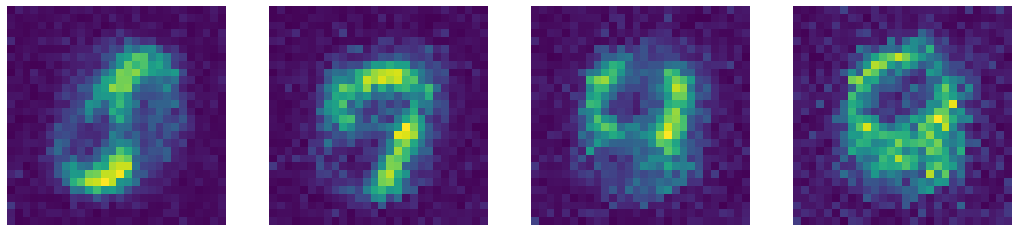

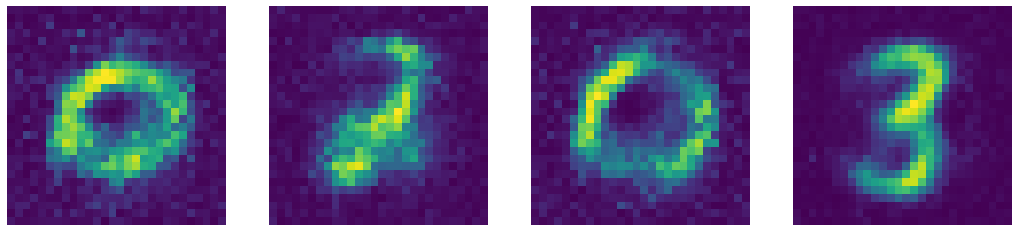

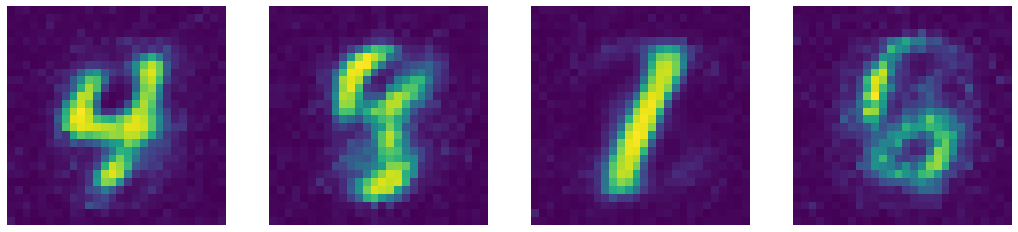

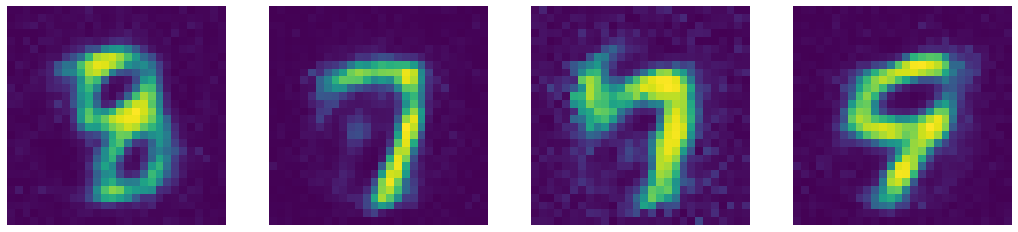

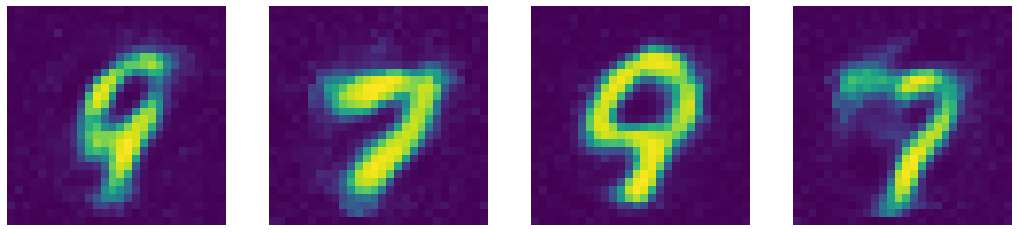

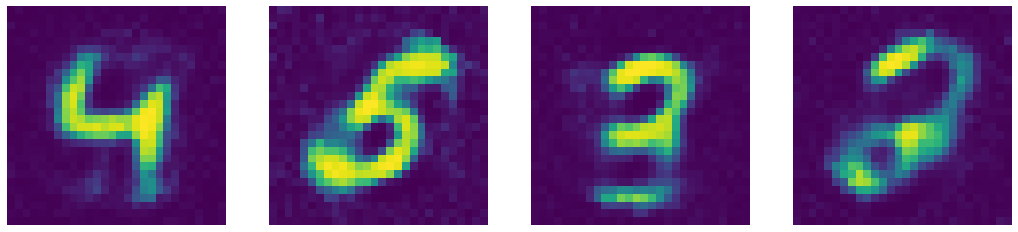

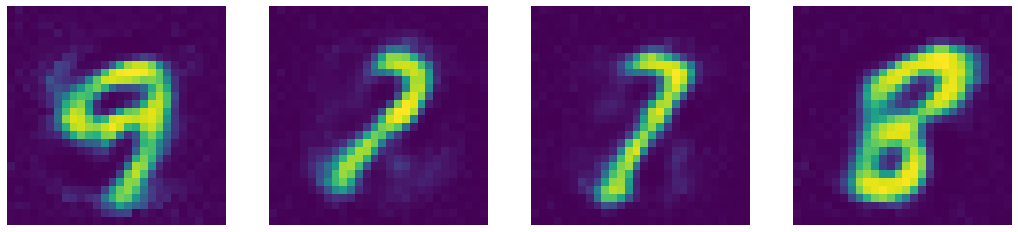

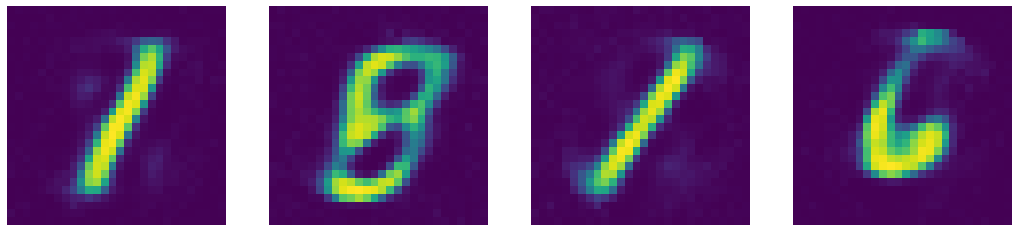

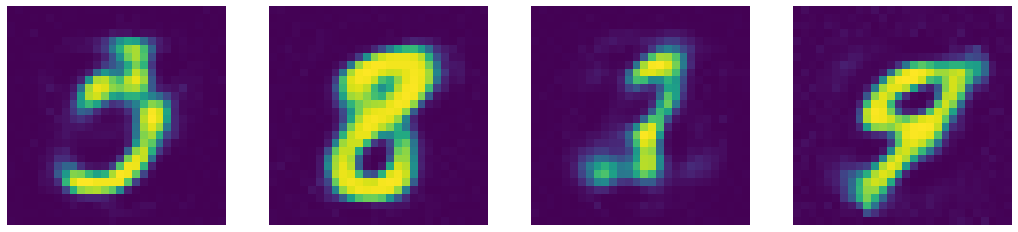

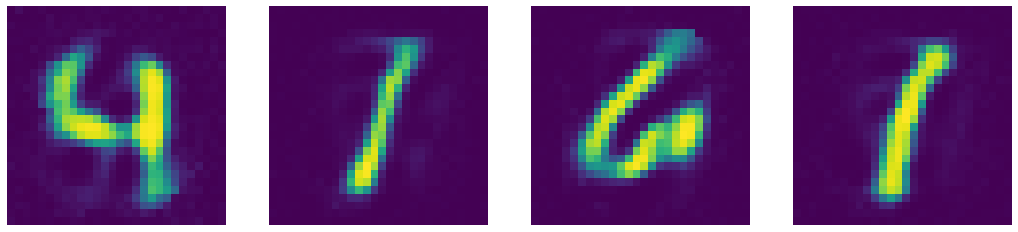

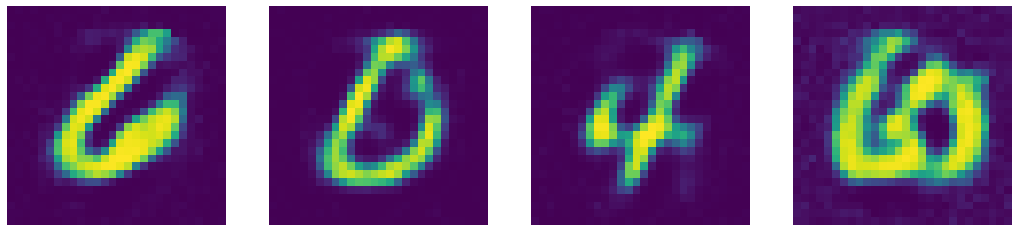

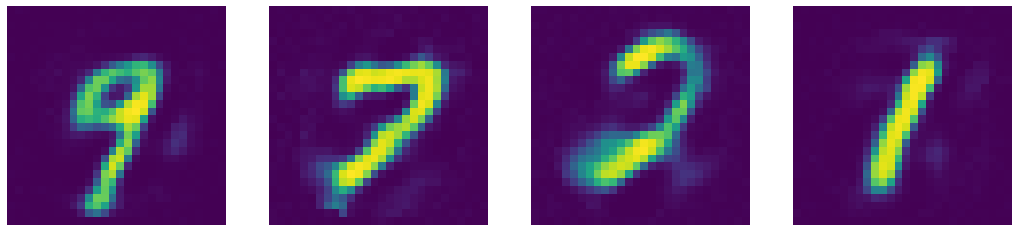

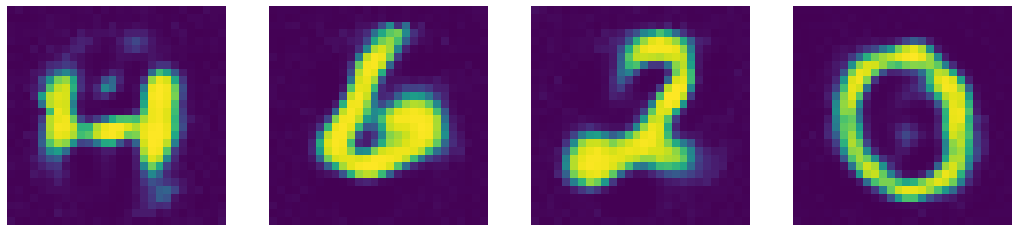

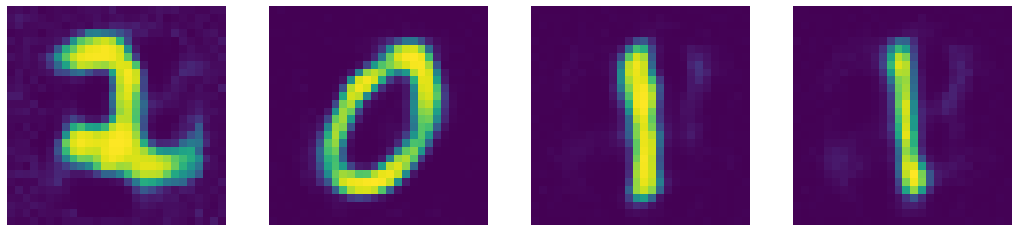

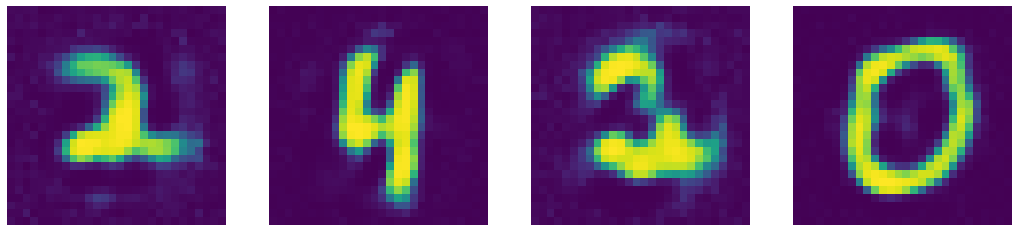

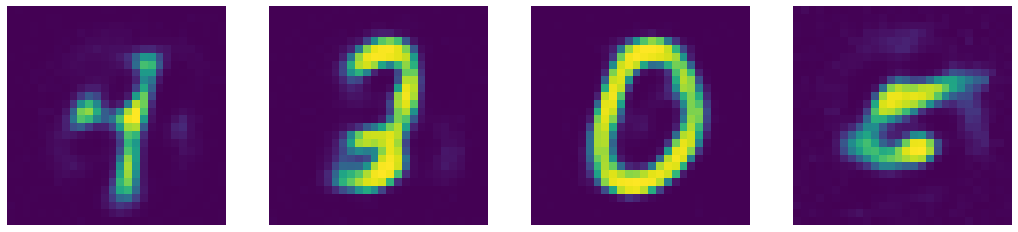

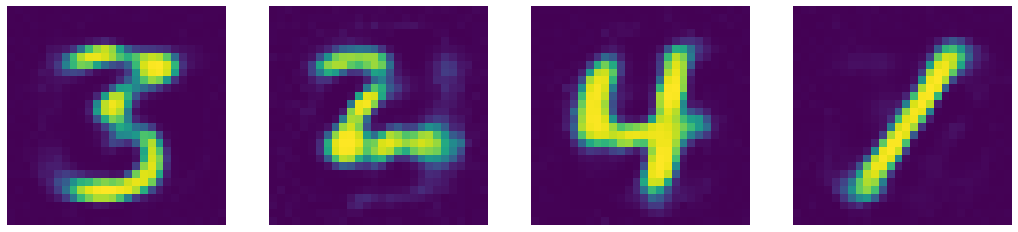

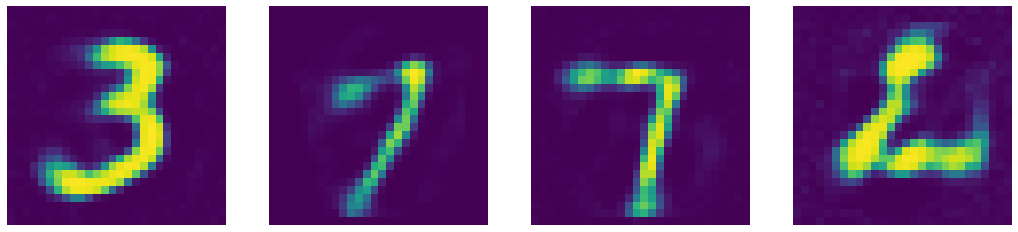

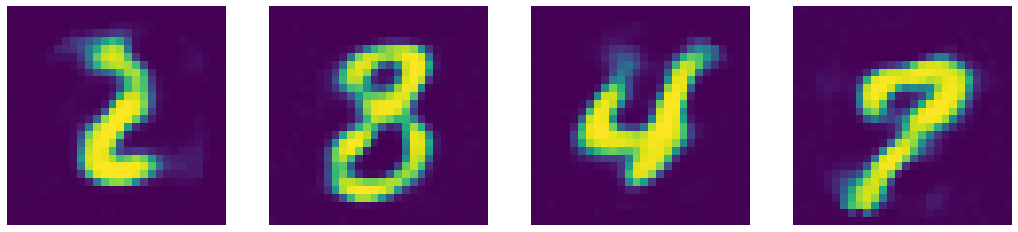

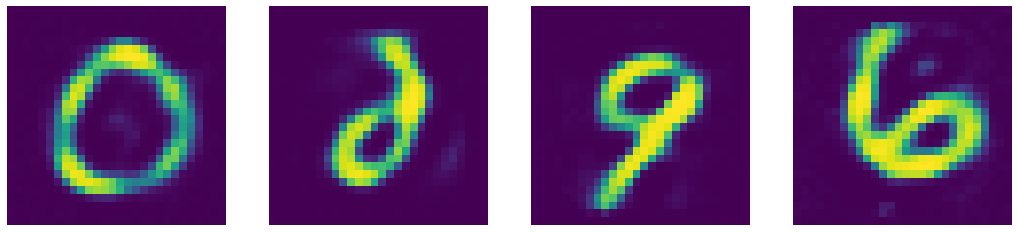

In [17]:
# Train standard or denoising autoencoder (AE)

num_epochs = 20
# do = nn.Dropout()  # comment out for standard AE
for epoch in range(num_epochs):
    for batch in dataloader:
        img, _ = batch
        img = img.to(device)
        img = img.view(img.size(0), -1)
        # noise = do(torch.ones(img.shape)).to(device)
        # img_bad = (img * noise).to(device)  # comment out for standard AE
        # ===================forward=====================
        output = model(img)  # feed <img> (for std AE) or <img_bad> (for denoising AE)
        loss = criterion(output, img.data)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print(f'epoch [{epoch + 1}/{num_epochs}], loss:{loss.item():.4f}')
    display_images(None, output)  # pass (None, output) for std AE, (img_bad, output) for denoising AE

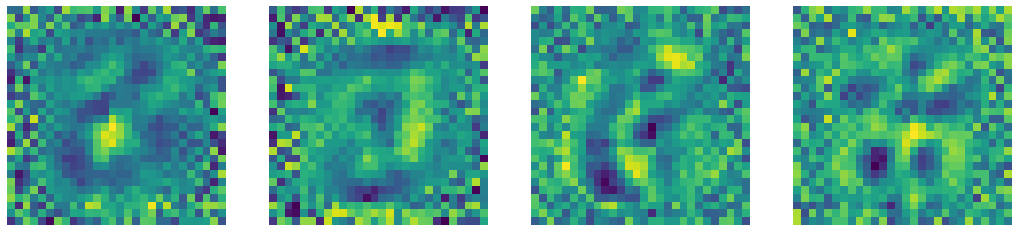

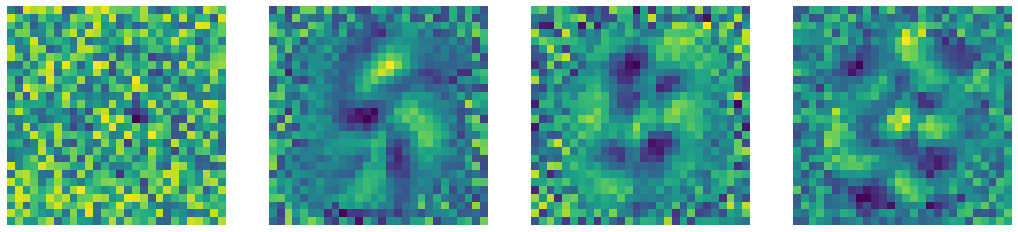

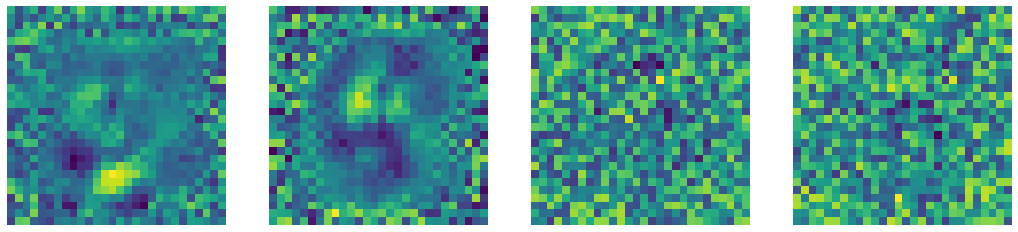

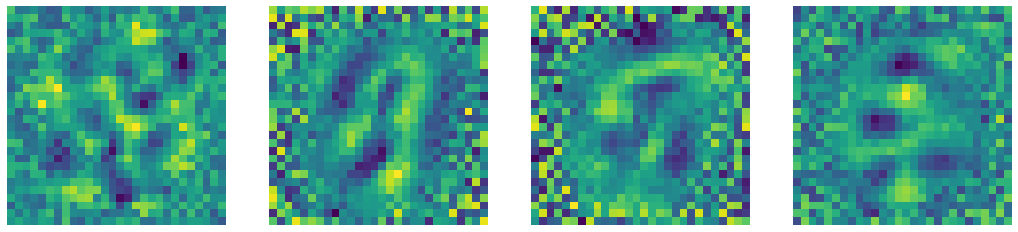

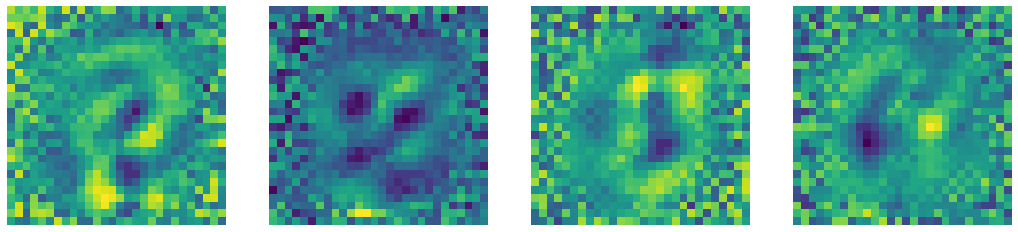

In [13]:
# Visualise a few kernels of the encoder

display_images(None, model.encoder[0].weight, 5)

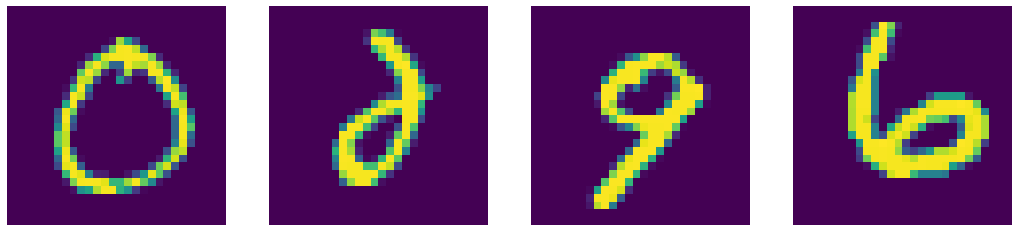

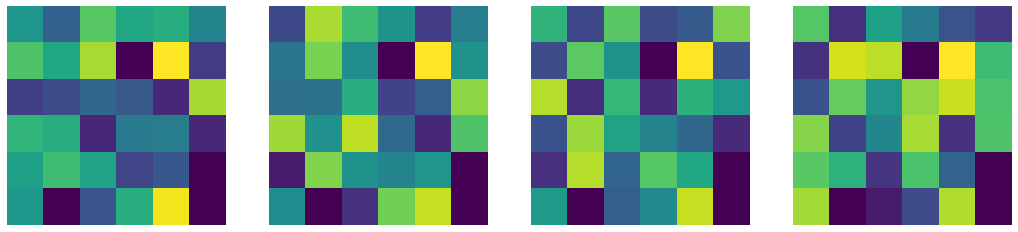

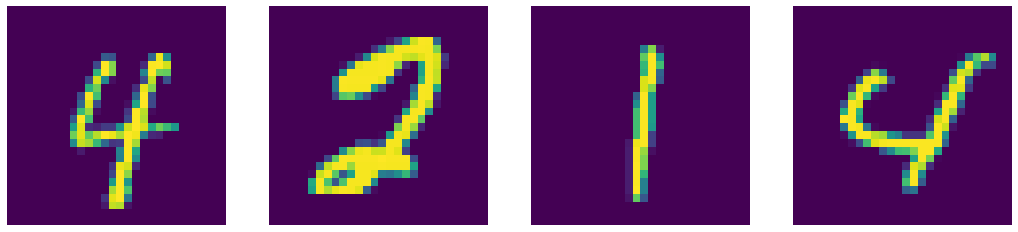

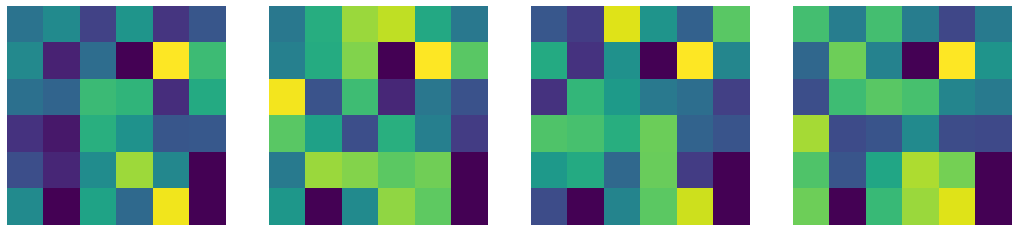

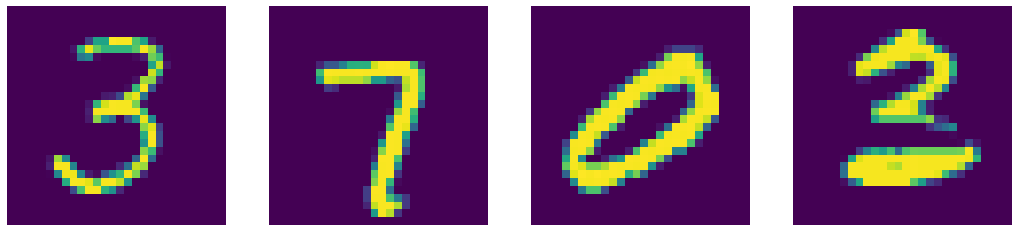

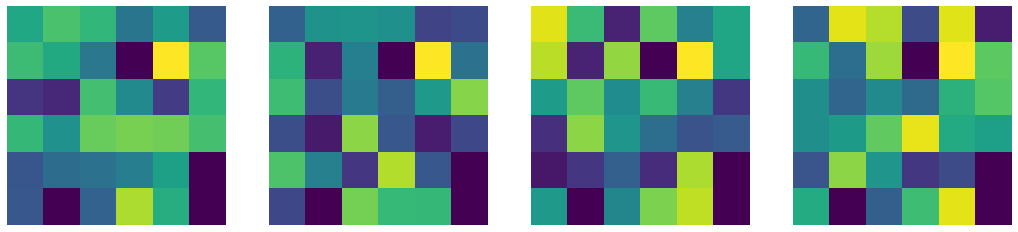

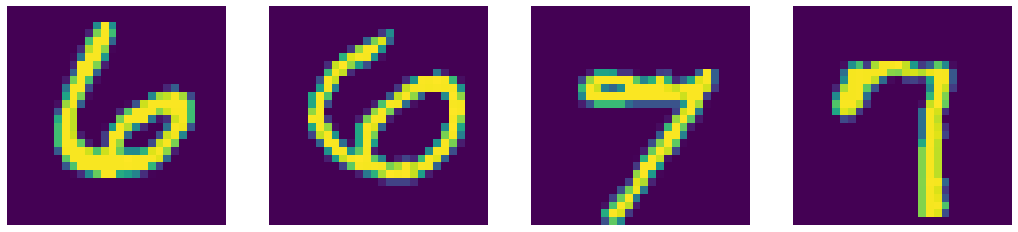

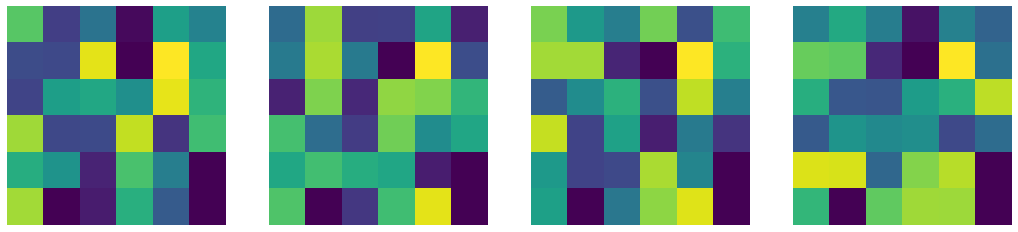

In [21]:
# visualize a few of the hidden representations
feat = model.get_features(img)
display_images(img, feat, n = 4, w_out=6, h_out=6)

## Overcomplete shallow AE

In [22]:
# Define model architecture and reconstruction loss

# n = 28 x 28 = 784
d = 30*30   #500  # for denoising AE (over-complete hidden layer)

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, d),
            nn.Tanh(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(d, 28 * 28),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def get_features(self, x):
        x = self.encoder(x)
        return x
    
model = Autoencoder().to(device)
criterion = nn.MSELoss()

In [23]:
# Configure the optimiser

learning_rate = 1e-3

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

*Comment* or *un-comment out* a few lines of code to seamlessly switch between *standard AE* and *denoising one*.

Don't forget to **(1)** change the size of the hidden layer accordingly, **(2)** re-generate the model, and **(3)** re-pass the parameters to the optimiser.

epoch [1/20], loss:0.0258
epoch [2/20], loss:0.0145
epoch [3/20], loss:0.0086
epoch [4/20], loss:0.0076
epoch [5/20], loss:0.0066
epoch [6/20], loss:0.0050
epoch [7/20], loss:0.0048
epoch [8/20], loss:0.0046
epoch [9/20], loss:0.0043
epoch [10/20], loss:0.0043
epoch [11/20], loss:0.0036
epoch [12/20], loss:0.0038
epoch [13/20], loss:0.0034
epoch [14/20], loss:0.0034
epoch [15/20], loss:0.0035
epoch [16/20], loss:0.0032
epoch [17/20], loss:0.0031
epoch [18/20], loss:0.0034
epoch [19/20], loss:0.0033
epoch [20/20], loss:0.0031


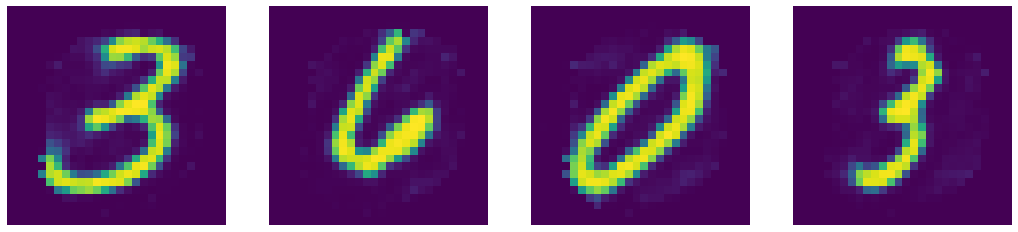

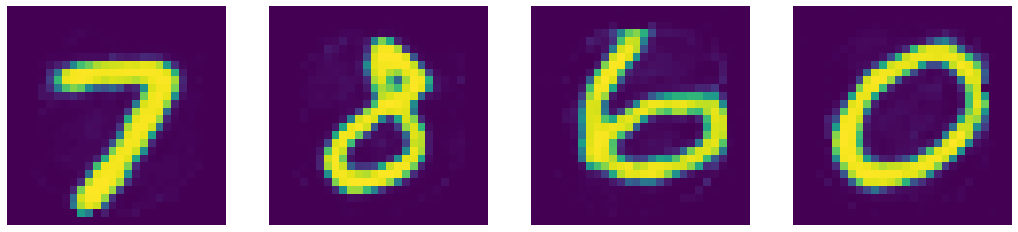

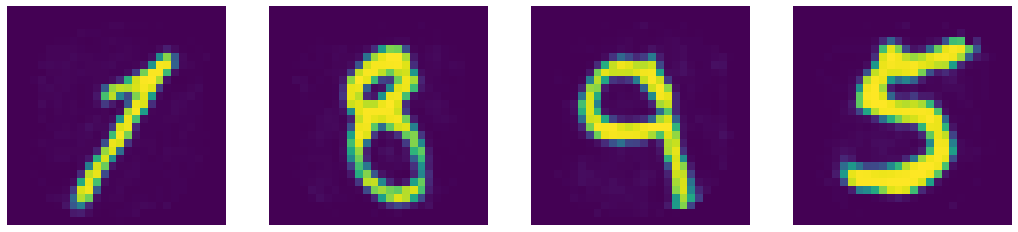

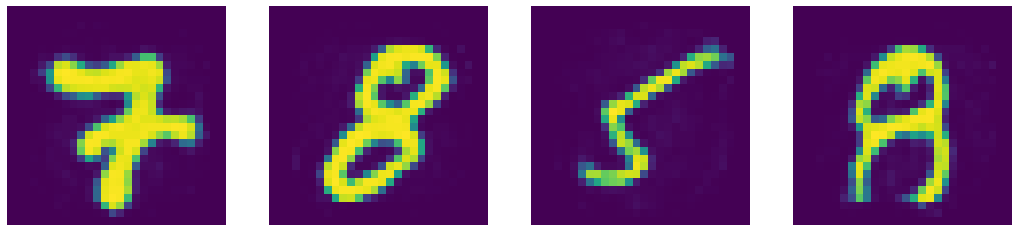

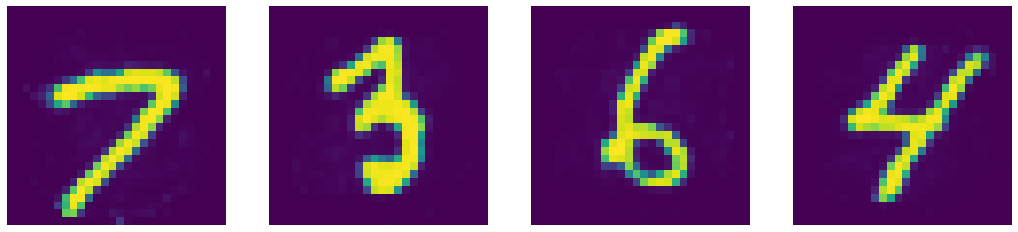

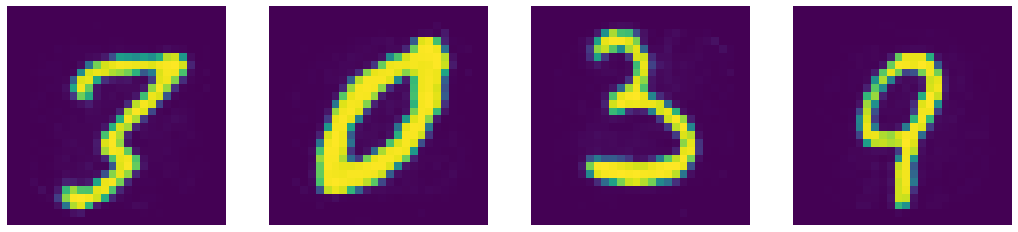

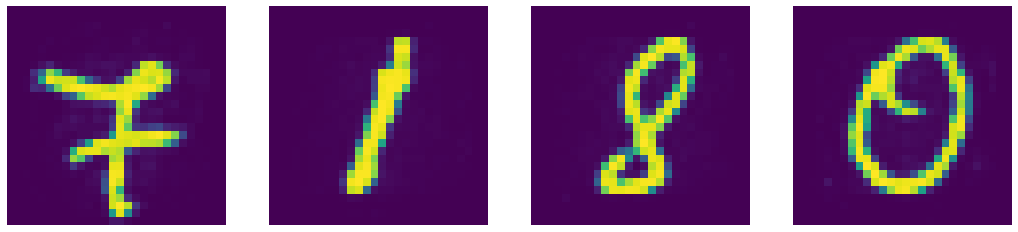

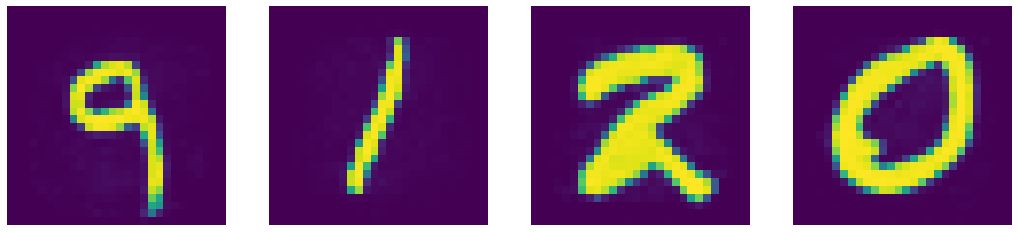

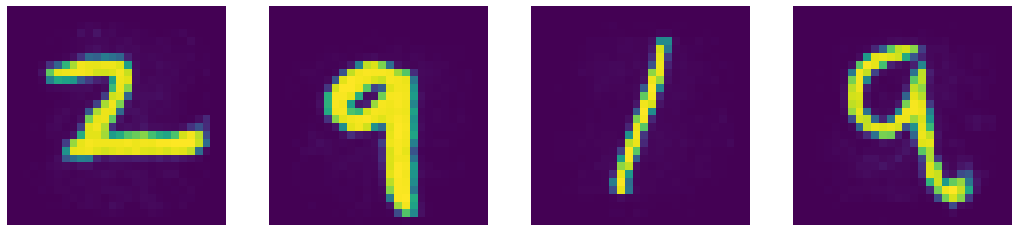

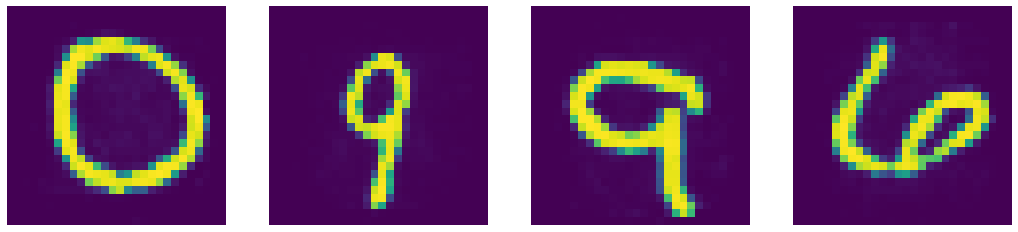

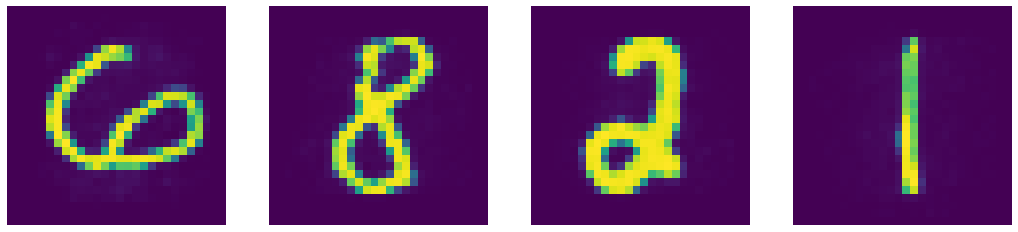

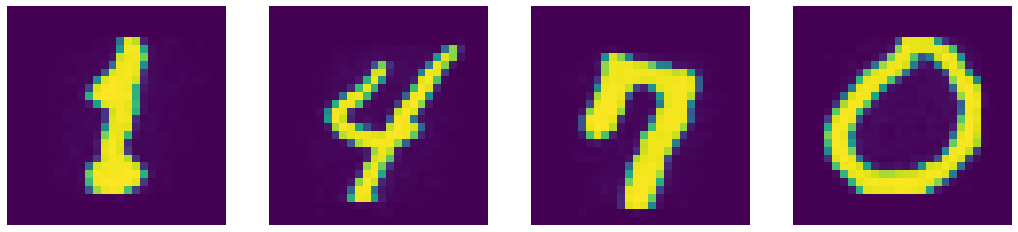

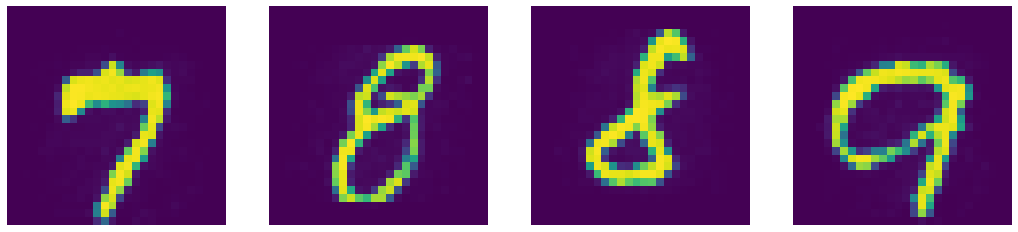

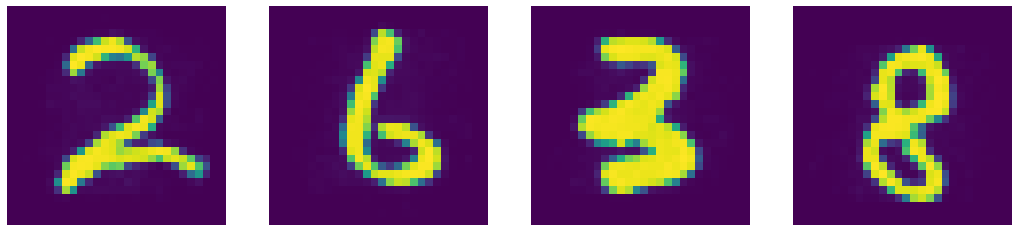

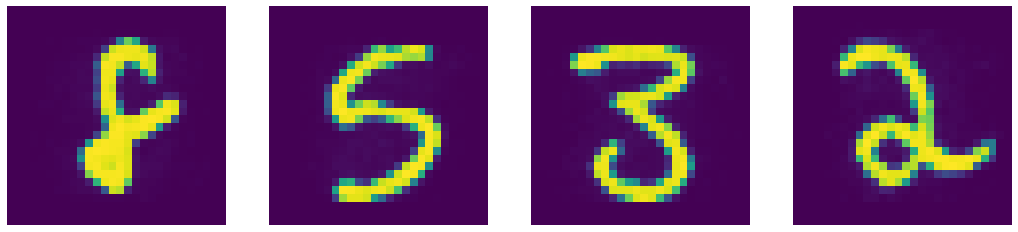

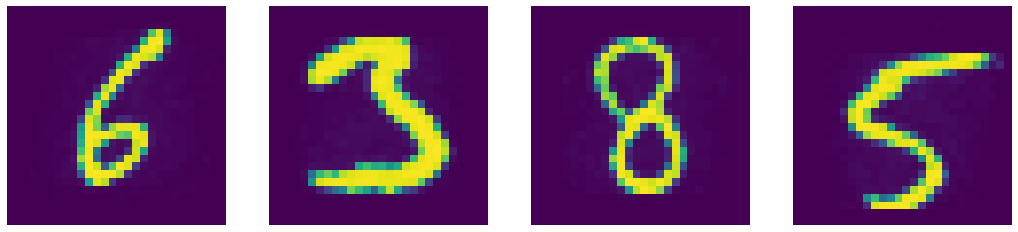

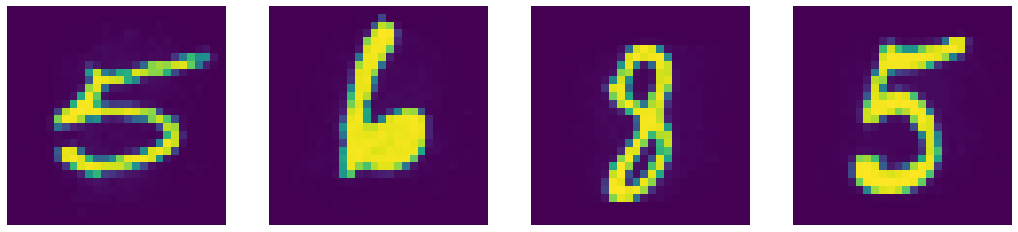

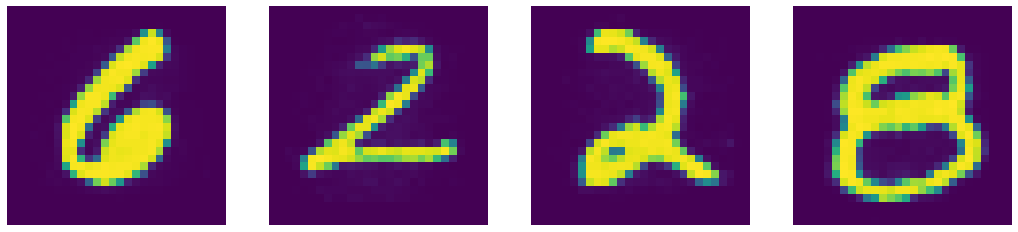

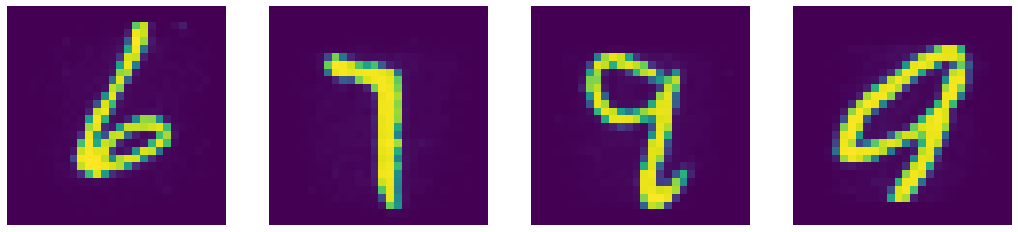

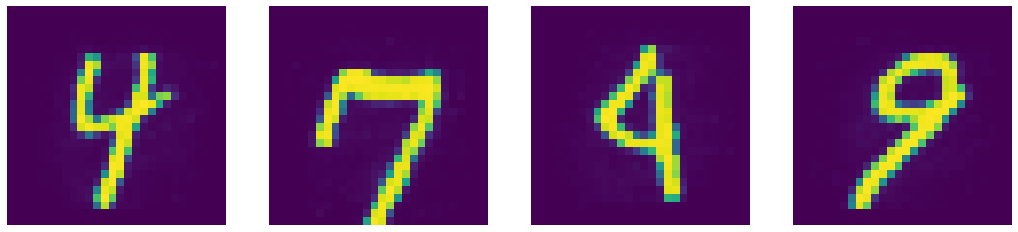

In [24]:
# Train standard or denoising autoencoder (AE)

num_epochs = 20
# do = nn.Dropout()  # comment out for standard AE
for epoch in range(num_epochs):
    for batch in dataloader:
        img, _ = batch
        img = img.to(device)
        img = img.view(img.size(0), -1)
        # noise = do(torch.ones(img.shape)).to(device)
        # img_bad = (img * noise).to(device)  # comment out for standard AE
        # ===================forward=====================
        output = model(img)  # feed <img> (for std AE) or <img_bad> (for denoising AE)
        loss = criterion(output, img.data)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print(f'epoch [{epoch + 1}/{num_epochs}], loss:{loss.item():.4f}')
    display_images(None, output)  # pass (None, output) for std AE, (img_bad, output) for denoising AE

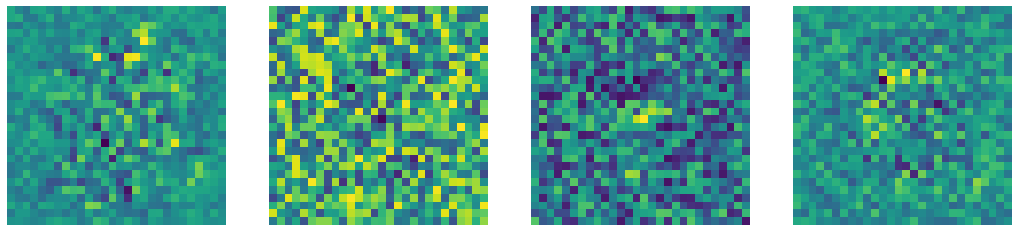

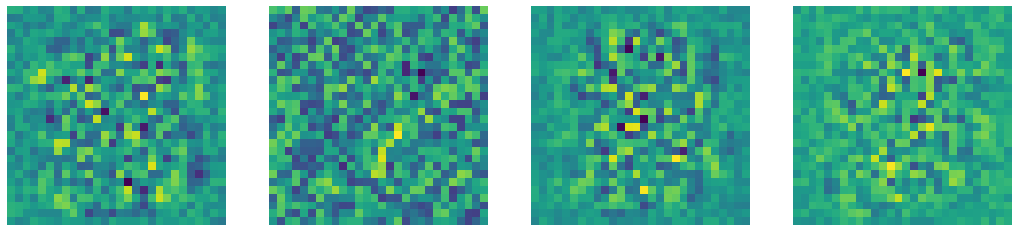

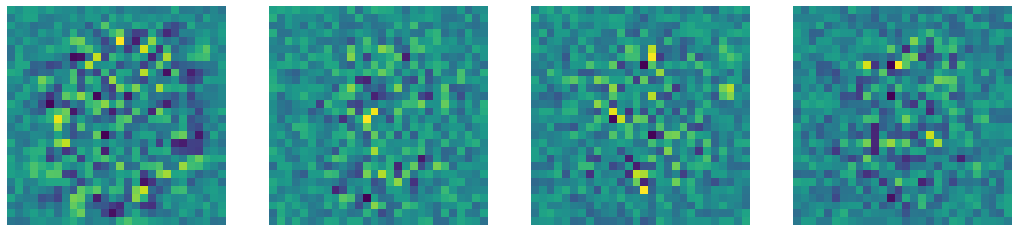

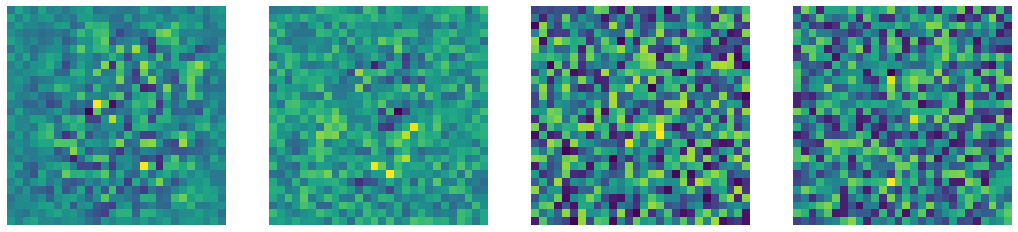

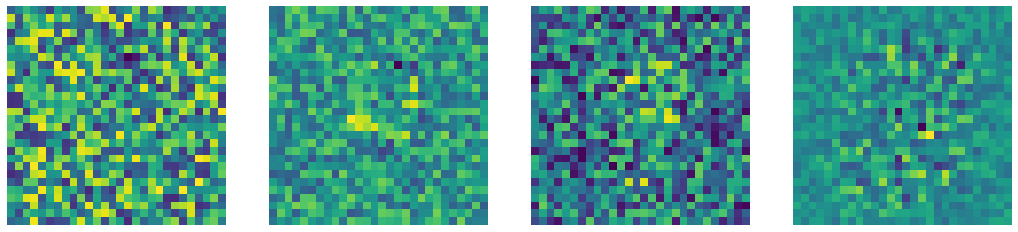

In [25]:
# Visualise a few kernels of the encoder

display_images(None, model.encoder[0].weight, 5)

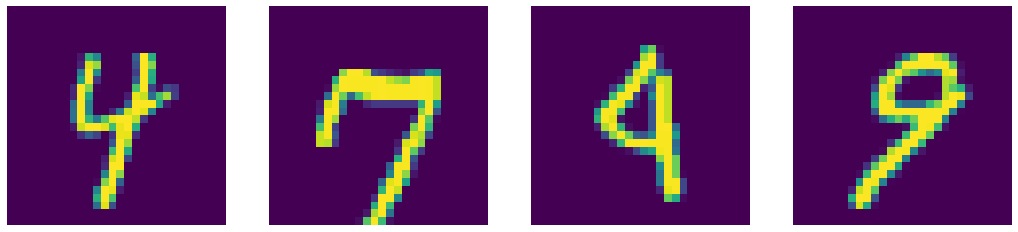

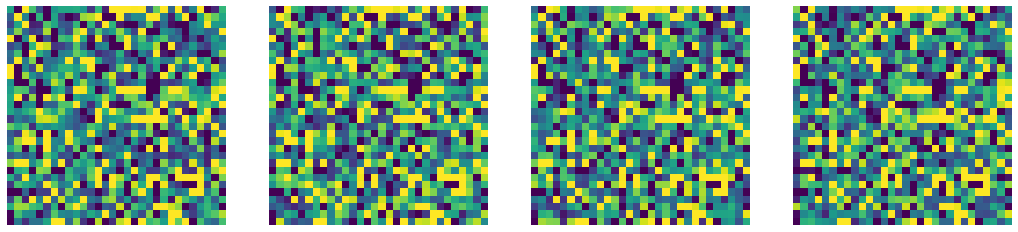

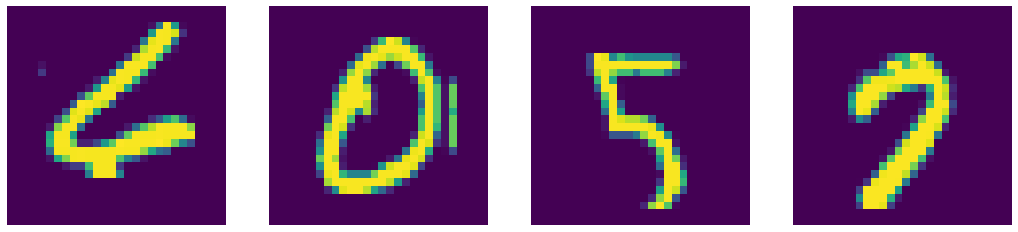

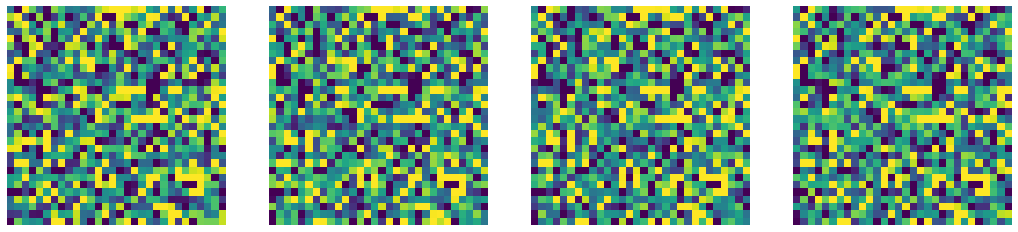

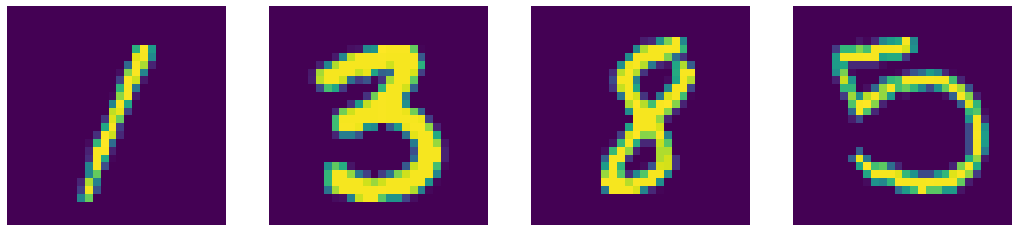

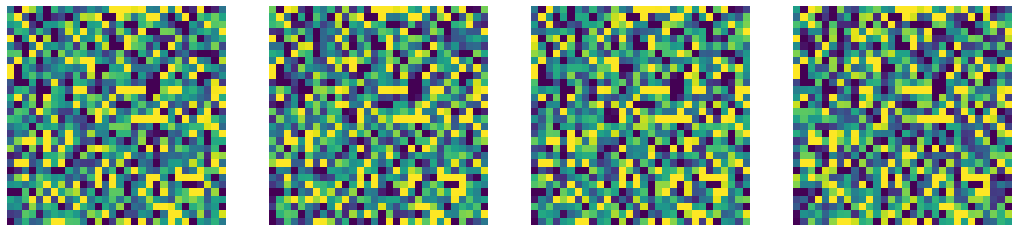

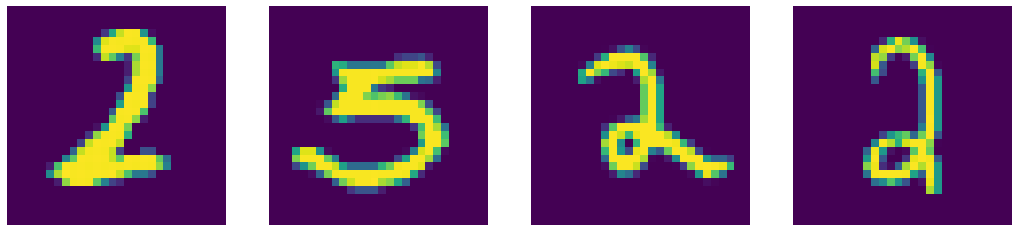

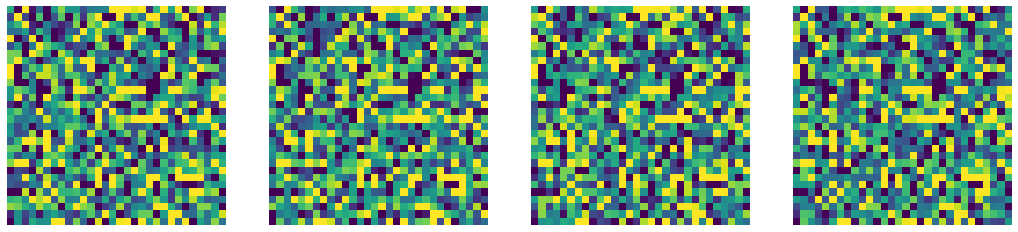

In [26]:
# visualize a few of the hidden representations
feat = model.get_features(img)
display_images(img, feat, n = 4, w_out=30, h_out=30)

## Undercomplete Convolutional AE

In [74]:
# Define model architecture and reconstruction loss

# n = 28 x 28 = 784
d = 36 #30  # for standard AE (under-complete hidden layer)
# d = 500  # for denoising AE (over-complete hidden layer)

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=5, padding=2),  # 28 x 28
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 14 x 14
            nn.Conv2d(64, 192, kernel_size=5, padding=2),  # 14 x 14
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 7 x 7
            nn.Conv2d(192, 256, kernel_size=3, padding=0),  # 5 x 5
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=0),  # 3 x 3
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=0),  # 1 x 1
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True))
        self.encoder_lin = nn.Sequential(
            nn.Linear(256, d),
            nn.Tanh()
        )
        
        self.decoder_lin = nn.Sequential(
            nn.Linear(d, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 64*16*16),
            nn.BatchNorm1d(64*16*16),
            nn.ReLU(inplace=True),
        )
        self.decoder_conv = nn.Sequential(
            #nn.ConvTranspose2d(256, 192, 2, stride=1),  # 2 x 2
            #nn.ReLU(inplace=True),
            #nn.ConvTranspose2d(192, 128, 2, stride=2),  # 4 x 4
            #nn.ReLU(inplace=True),
            #nn.ConvTranspose2d(128, 64, 7, stride=3),  # 16 x 16
            #nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, 7, stride=1),  # 22 x 22
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 1, 7, stride=1),  # 28 x 28
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.encoder_conv(x)
        x = x.view(x.size(0), -1)
        x = self.encoder_lin(x)
        
        x = self.decoder_lin(x)
        x = x.view(x.size(0), 64, 16, 16)
        x = self.decoder_conv(x)
        return x
    
    def get_features(self, x):
        x = self.encoder_conv(x)
        x = x.view(x.size(0), -1)
        x = self.encoder_lin(x)
        return x
    
model = Autoencoder().to(device)
criterion = nn.MSELoss()

In [75]:
# Configure the optimiser

learning_rate = 1e-3

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

*Comment* or *un-comment out* a few lines of code to seamlessly switch between *standard AE* and *denoising one*.

Don't forget to **(1)** change the size of the hidden layer accordingly, **(2)** re-generate the model, and **(3)** re-pass the parameters to the optimiser.

epoch [1/20], loss:0.0448
epoch [2/20], loss:0.0364
epoch [3/20], loss:0.0266
epoch [4/20], loss:0.0271
epoch [5/20], loss:0.0243
epoch [6/20], loss:0.0238
epoch [7/20], loss:0.0211
epoch [8/20], loss:0.0187
epoch [9/20], loss:0.0208
epoch [10/20], loss:0.0179
epoch [11/20], loss:0.0162
epoch [12/20], loss:0.0174
epoch [13/20], loss:0.0227
epoch [14/20], loss:0.0150
epoch [15/20], loss:0.0182
epoch [16/20], loss:0.0158
epoch [17/20], loss:0.0177
epoch [18/20], loss:0.0190
epoch [19/20], loss:0.0142
epoch [20/20], loss:0.0156


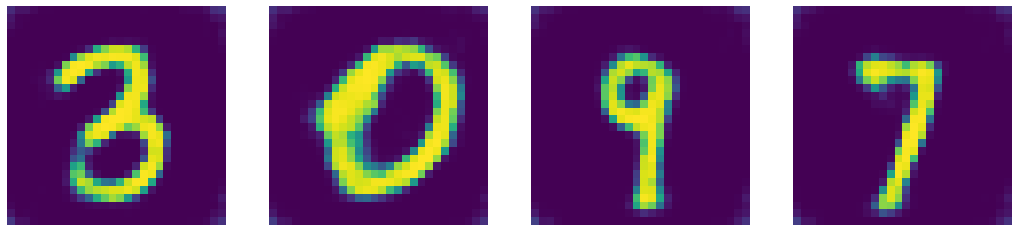

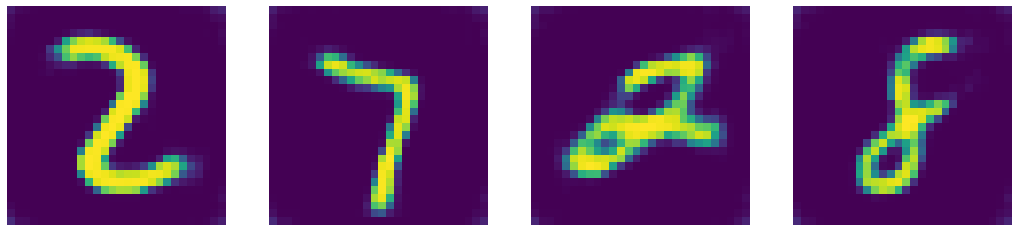

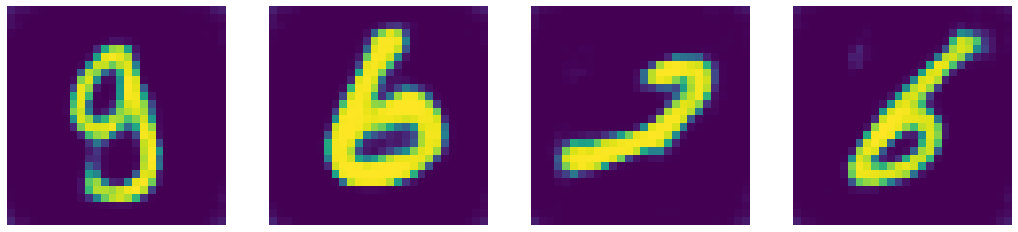

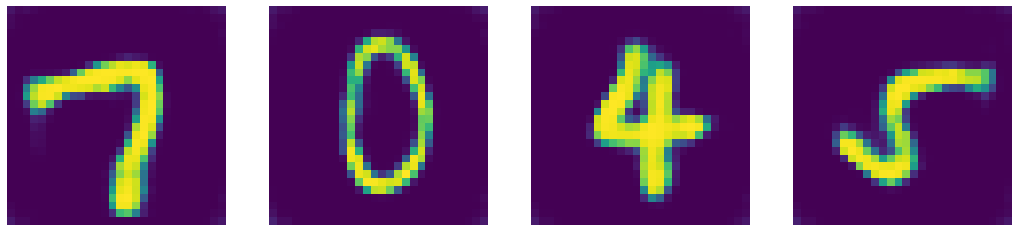

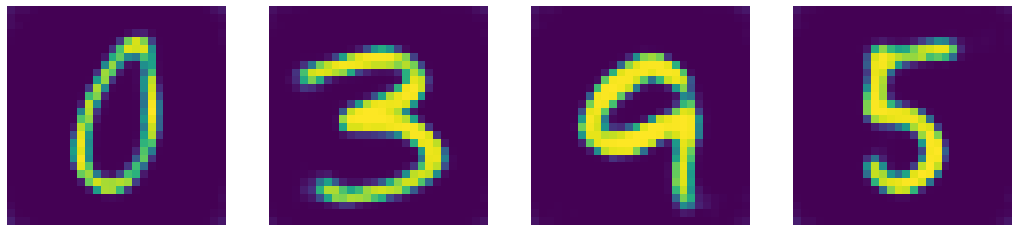

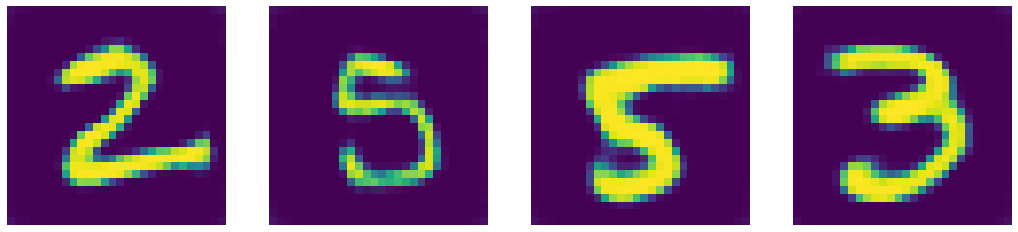

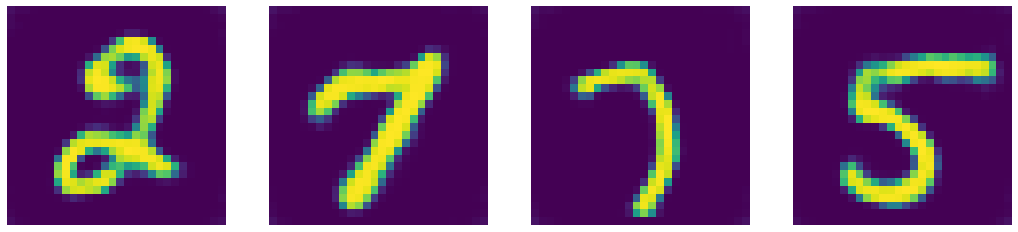

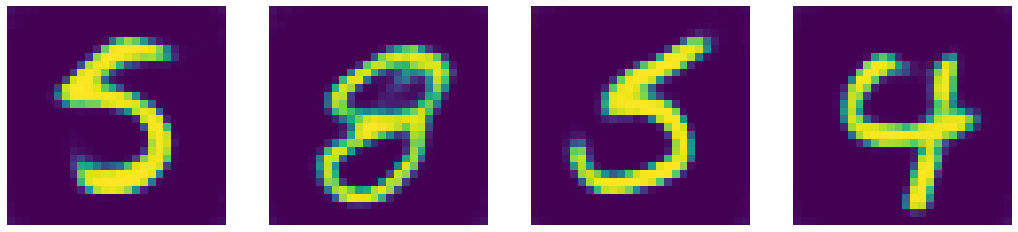

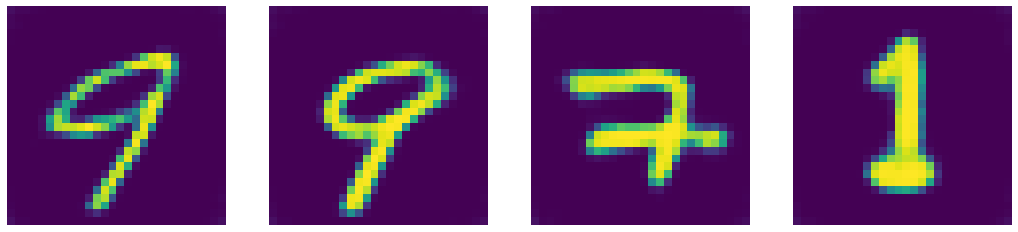

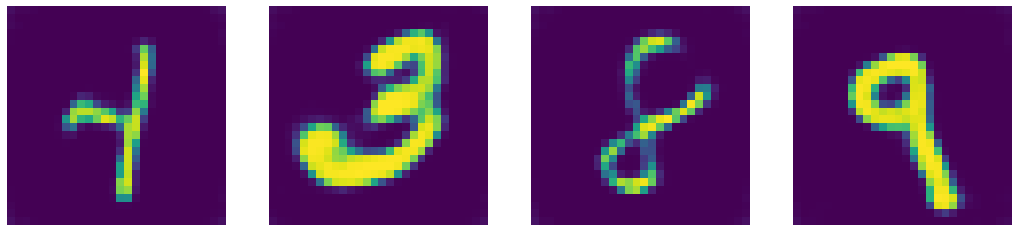

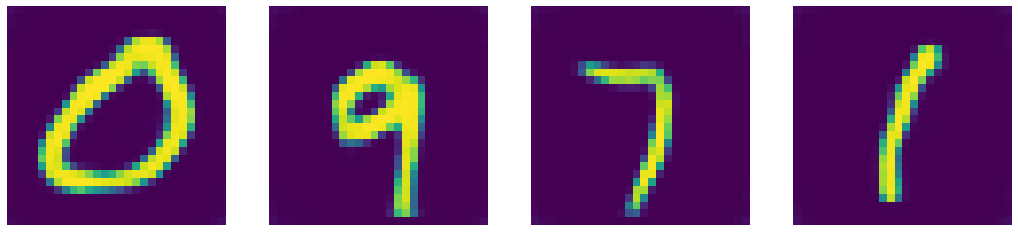

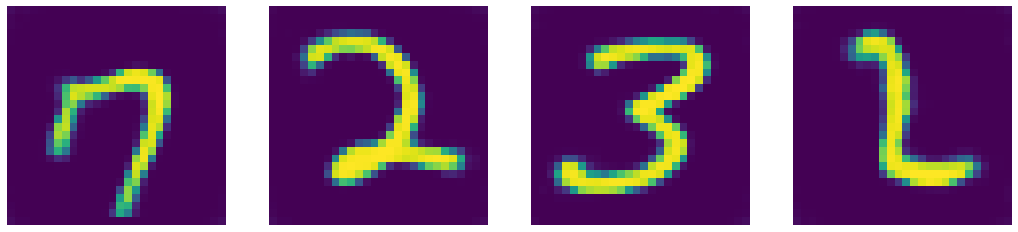

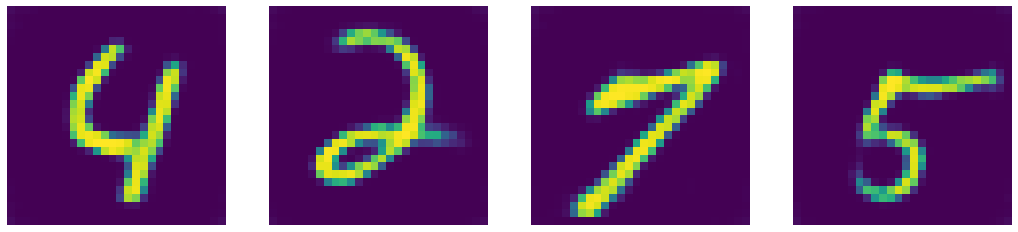

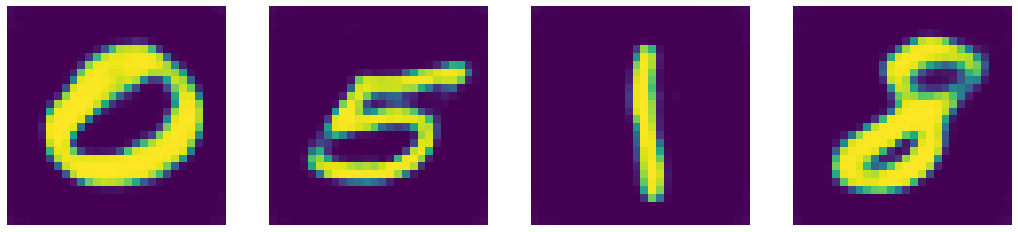

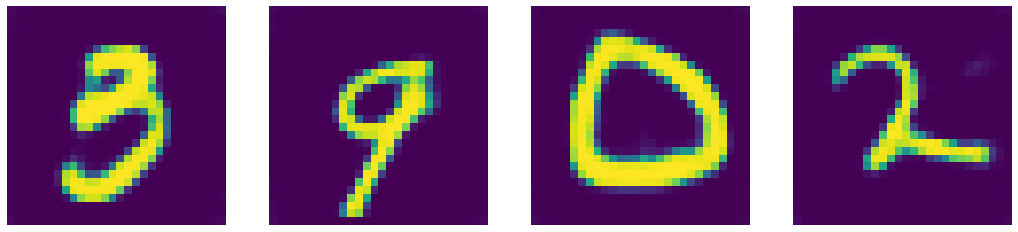

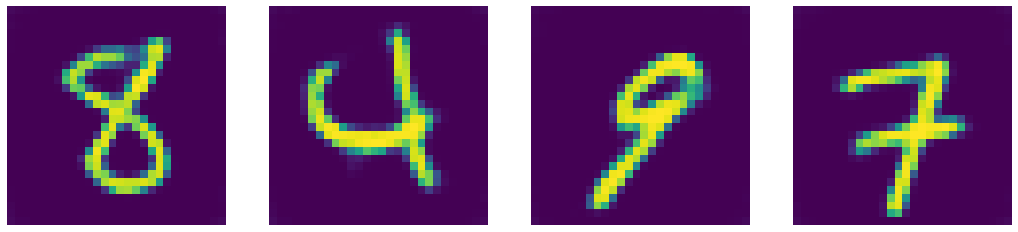

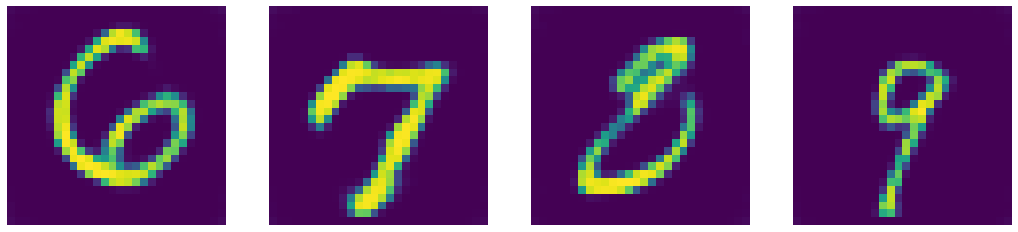

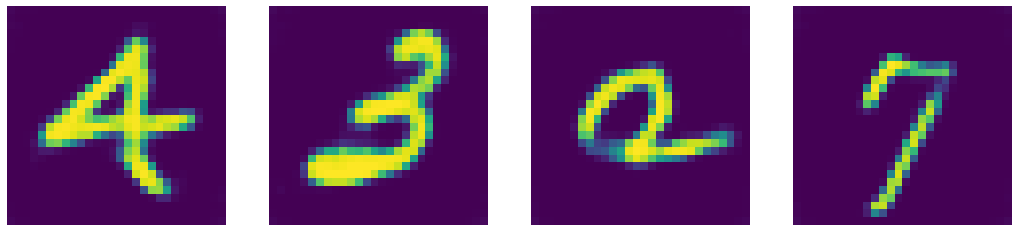

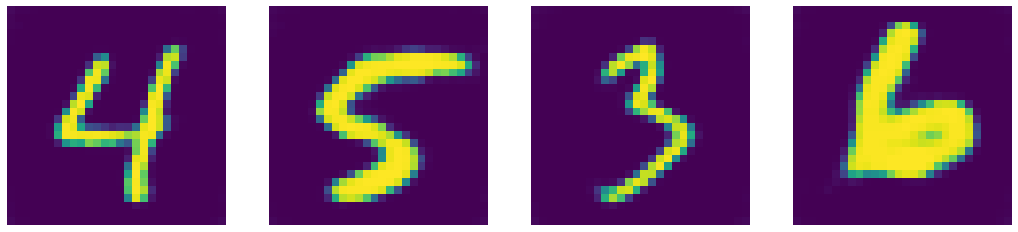

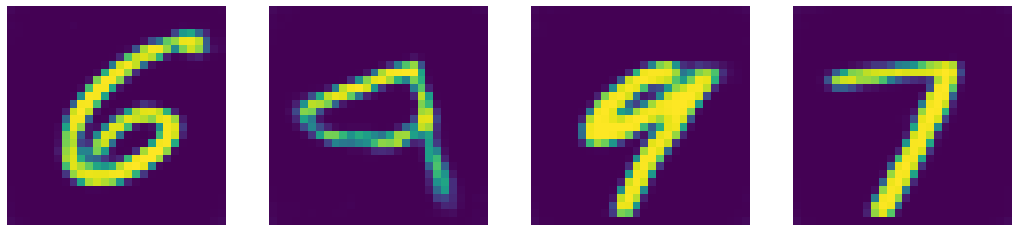

In [76]:
# Train standard or denoising autoencoder (AE)

num_epochs = 20
# do = nn.Dropout()  # comment out for standard AE
for epoch in range(num_epochs):
    for batch in dataloader:
        img, _ = batch
        img = img.to(device)
        #img = img.view(img.size(0), -1)
        # noise = do(torch.ones(img.shape)).to(device)
        # img_bad = (img * noise).to(device)  # comment out for standard AE
        # ===================forward=====================
        output = model(img)  # feed <img> (for std AE) or <img_bad> (for denoising AE)
        loss = criterion(output, img.data)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print(f'epoch [{epoch + 1}/{num_epochs}], loss:{loss.item():.4f}')
    display_images(None, output)  # pass (None, output) for std AE, (img_bad, output) for denoising AE

Train more epochs:

epoch [1/20], loss:0.0104
epoch [2/20], loss:0.0124
epoch [3/20], loss:0.0094
epoch [4/20], loss:0.0113
epoch [5/20], loss:0.0118
epoch [6/20], loss:0.0107
epoch [7/20], loss:0.0105
epoch [8/20], loss:0.0110
epoch [9/20], loss:0.0115
epoch [10/20], loss:0.0109
epoch [11/20], loss:0.0103
epoch [12/20], loss:0.0124
epoch [13/20], loss:0.0127
epoch [14/20], loss:0.0120
epoch [15/20], loss:0.0109
epoch [16/20], loss:0.0106
epoch [17/20], loss:0.0116
epoch [18/20], loss:0.0129
epoch [19/20], loss:0.0267
epoch [20/20], loss:0.0115


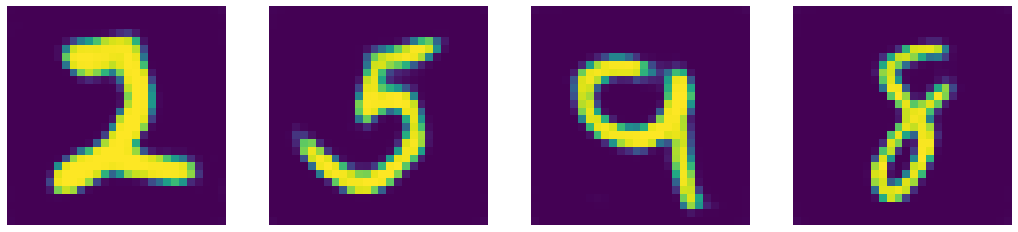

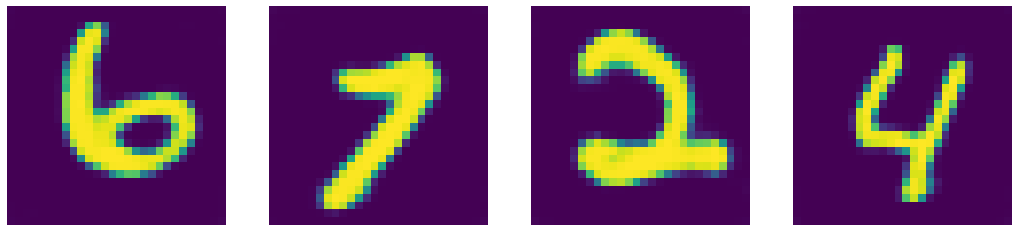

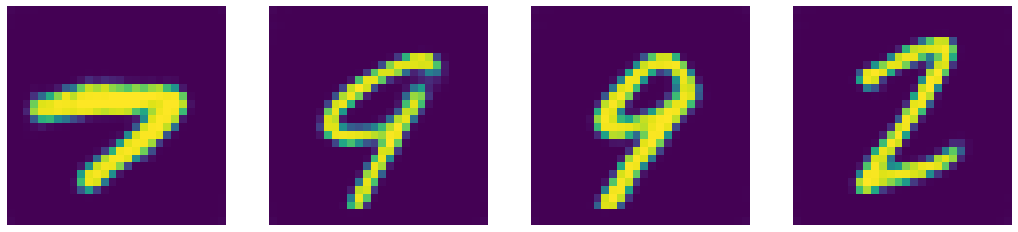

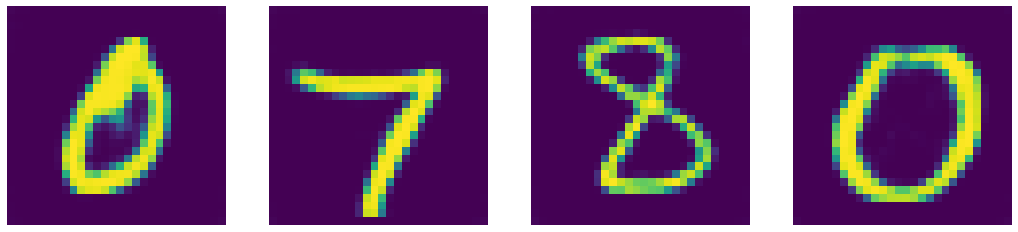

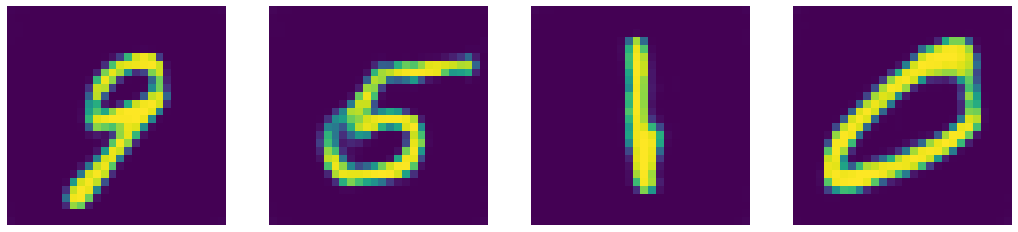

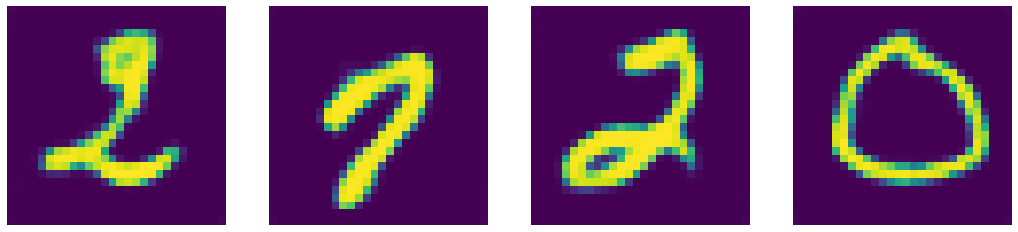

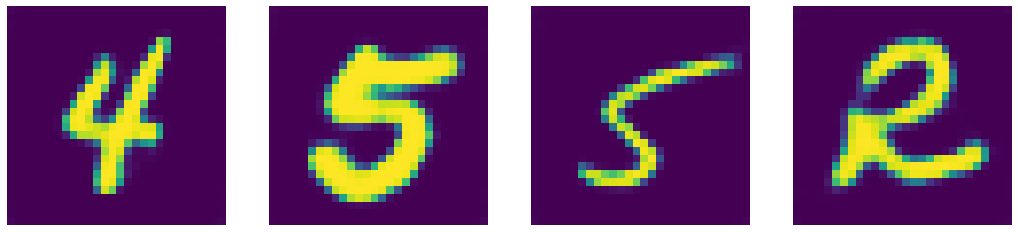

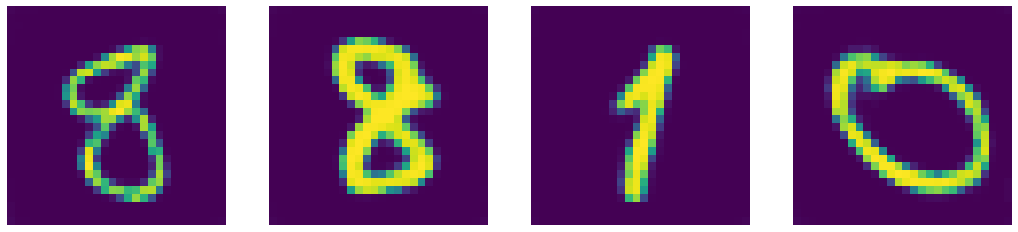

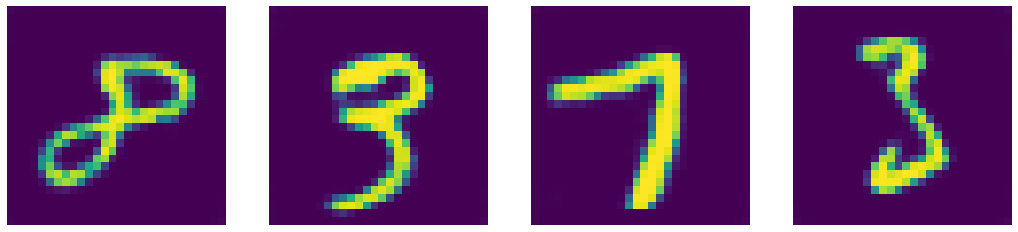

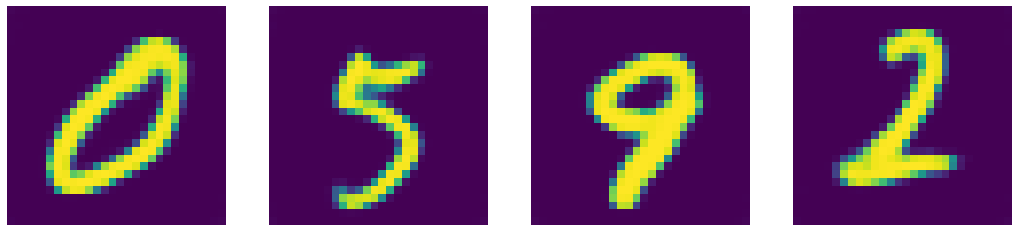

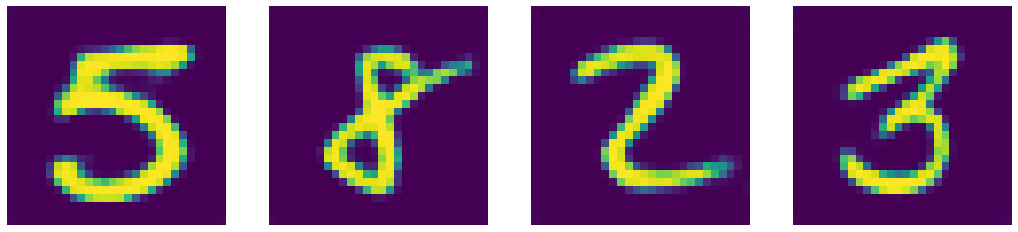

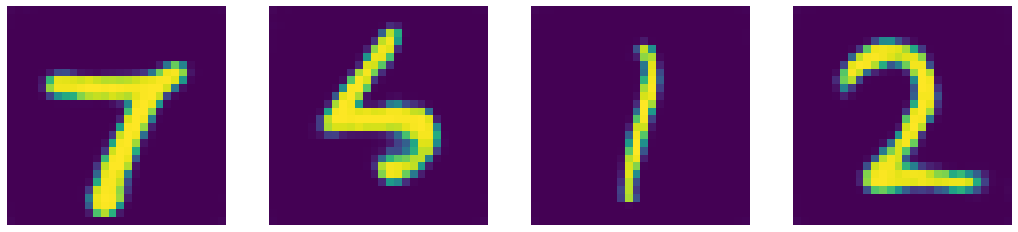

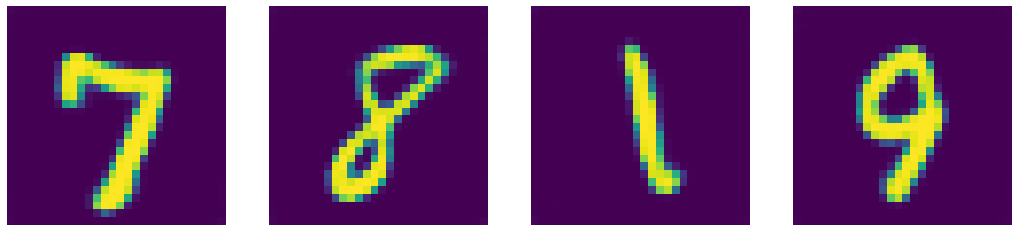

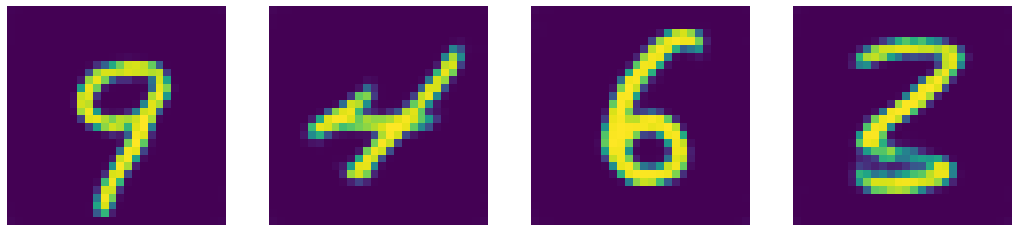

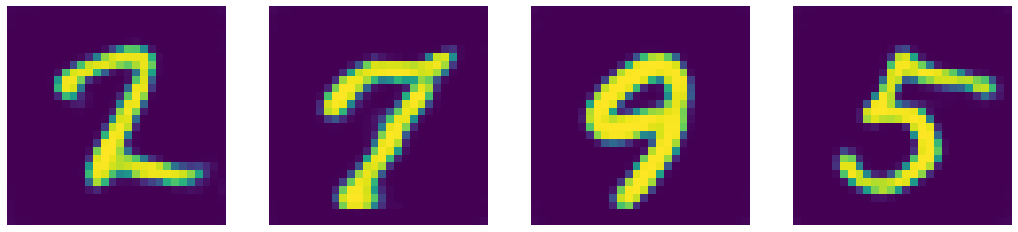

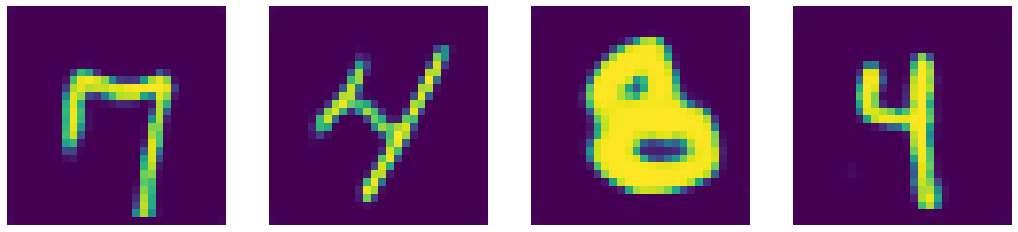

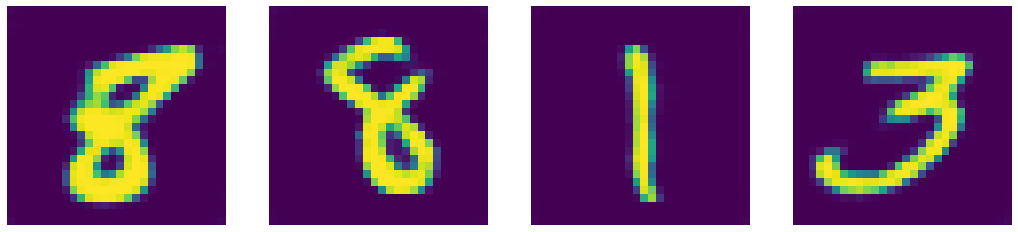

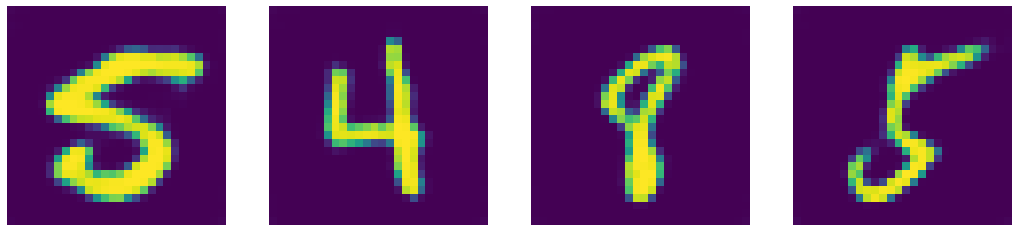

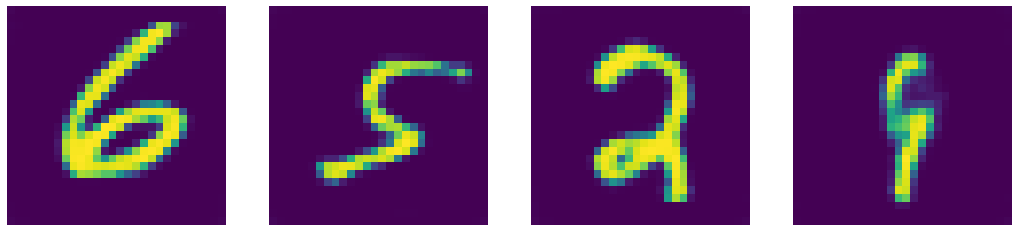

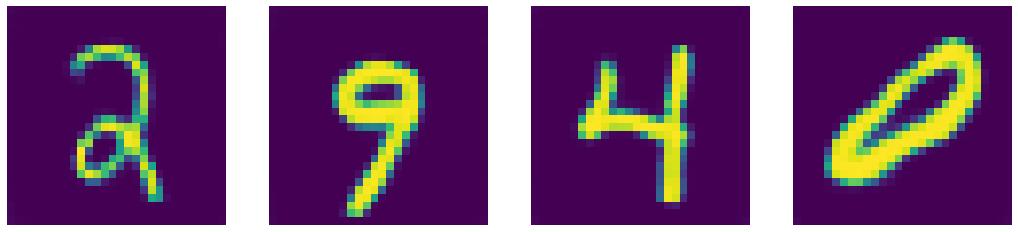

In [78]:
num_epochs = 20
learning_rate = 1e-5
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

for epoch in range(num_epochs):
    for batch in dataloader:
        img, _ = batch
        img = img.to(device)
        # ===================forward=====================
        output = model(img)
        loss = criterion(output, img.data)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print(f'epoch [{epoch + 1}/{num_epochs}], loss:{loss.item():.4f}')
    display_images(None, output)  # pass (None, output) for std AE, (img_bad, output) for denoising AE

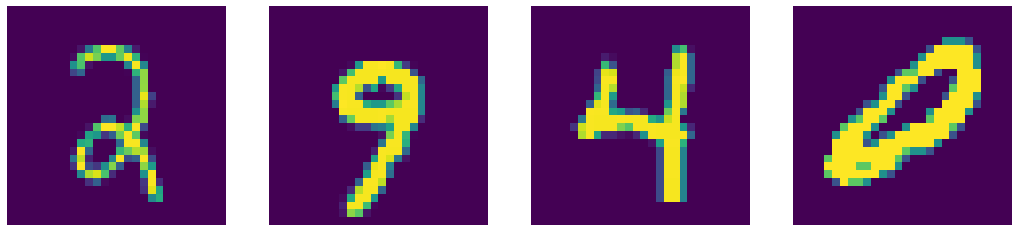

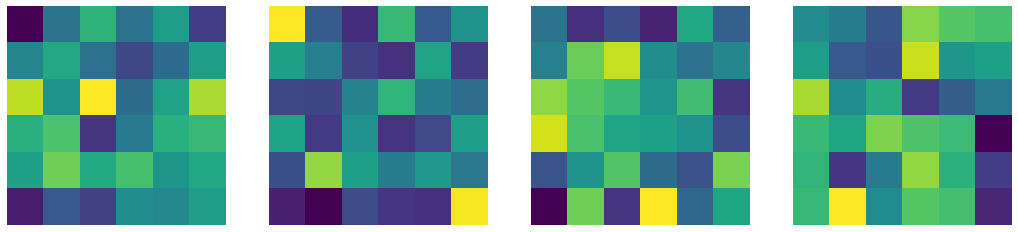

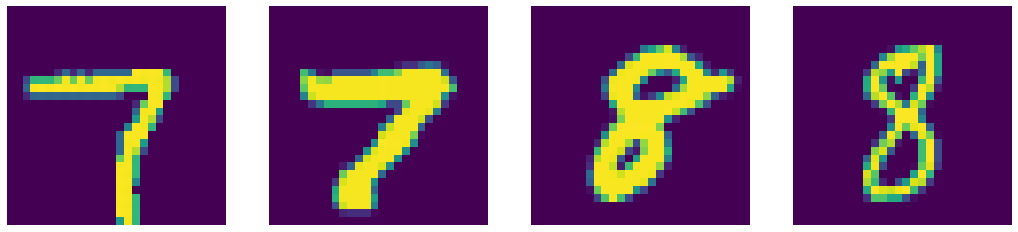

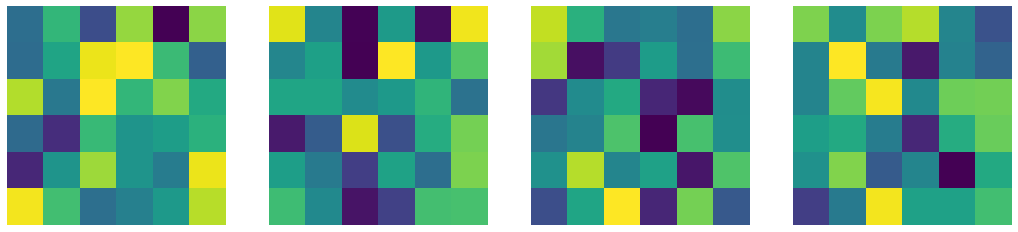

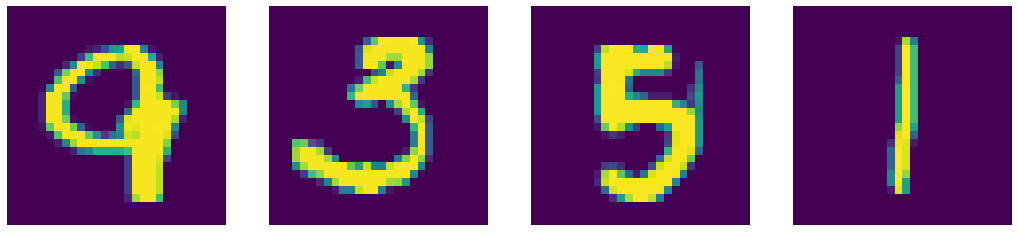

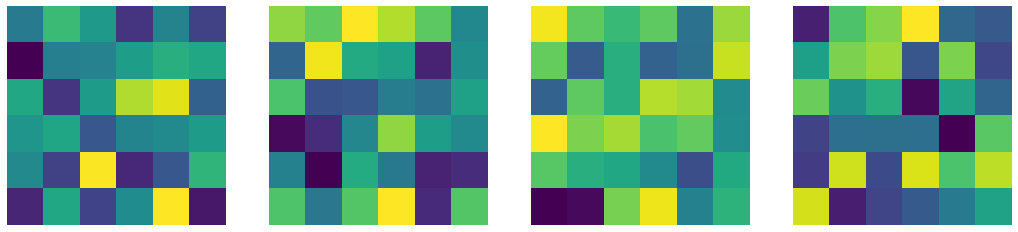

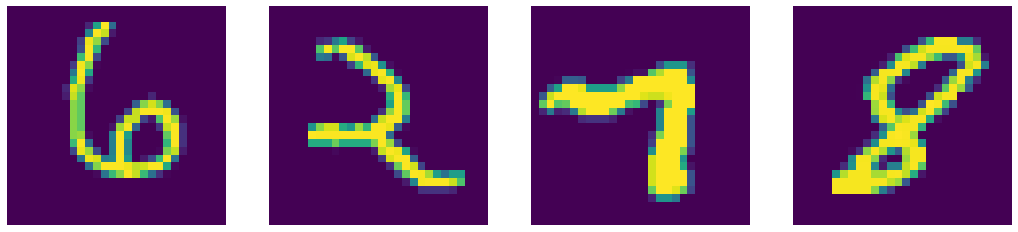

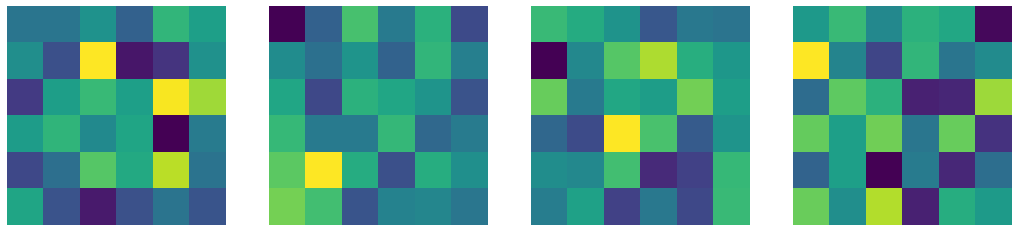

In [79]:
# visualize a few of the hidden representations
feat = model.get_features(img)
display_images(img, feat, n = 4, w_out=6, h_out=6)

## Overcomplete Convolutional AE

In [81]:
# Define model architecture and reconstruction loss

# n = 28 x 28 = 784
# d = 36 #30  # for standard AE (under-complete hidden layer)
d = 512  # for denoising AE (over-complete hidden layer)

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=5, padding=2),  # 28 x 28
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 14 x 14
            nn.Conv2d(64, 192, kernel_size=5, padding=2),  # 14 x 14
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 7 x 7
            nn.Conv2d(192, 256, kernel_size=3, padding=0),  # 5 x 5
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 512, kernel_size=3, padding=0),  # 3 x 3
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 1024, kernel_size=3, padding=0),  # 1 x 1
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True))
        self.encoder_lin = nn.Sequential(
            nn.Linear(1024, d),
            nn.Tanh()
        )
        
        self.decoder_lin = nn.Sequential(
            nn.Linear(d, 64*16*16),
            nn.BatchNorm1d(64*16*16),
            nn.ReLU(inplace=True),
        )
        self.decoder_conv = nn.Sequential(
            #nn.ConvTranspose2d(256, 192, 2, stride=1),  # 2 x 2
            #nn.ReLU(inplace=True),
            #nn.ConvTranspose2d(192, 128, 2, stride=2),  # 4 x 4
            #nn.ReLU(inplace=True),
            #nn.ConvTranspose2d(128, 64, 7, stride=3),  # 16 x 16
            #nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, 7, stride=1),  # 22 x 22
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 1, 7, stride=1),  # 28 x 28
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.encoder_conv(x)
        x = x.view(x.size(0), -1)
        x = self.encoder_lin(x)
        
        x = self.decoder_lin(x)
        x = x.view(x.size(0), 64, 16, 16)
        x = self.decoder_conv(x)
        return x
    
    def get_features(self, x):
        x = self.encoder_conv(x)
        x = x.view(x.size(0), -1)
        x = self.encoder_lin(x)
        return x
    
model = Autoencoder().to(device)
criterion = nn.MSELoss()

In [82]:
# Configure the optimiser

learning_rate = 1e-3

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

*Comment* or *un-comment out* a few lines of code to seamlessly switch between *standard AE* and *denoising one*.

Don't forget to **(1)** change the size of the hidden layer accordingly, **(2)** re-generate the model, and **(3)** re-pass the parameters to the optimiser.

epoch [1/20], loss:0.0349
epoch [2/20], loss:0.0247
epoch [3/20], loss:0.0184
epoch [4/20], loss:0.0180
epoch [5/20], loss:0.0170
epoch [6/20], loss:0.0130
epoch [7/20], loss:0.0149
epoch [8/20], loss:0.0147
epoch [9/20], loss:0.0133
epoch [10/20], loss:0.0122
epoch [11/20], loss:0.0109
epoch [12/20], loss:0.0116
epoch [13/20], loss:0.0108
epoch [14/20], loss:0.0116
epoch [15/20], loss:0.0105
epoch [16/20], loss:0.0110
epoch [17/20], loss:0.0098
epoch [18/20], loss:0.0085
epoch [19/20], loss:0.0109
epoch [20/20], loss:0.0092


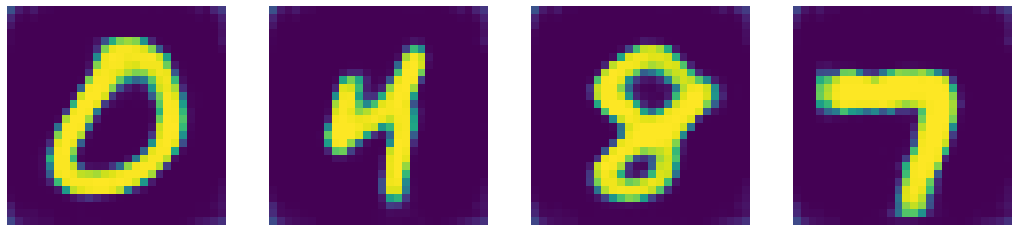

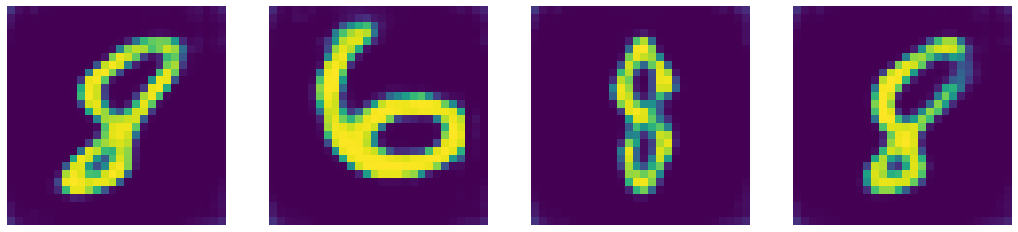

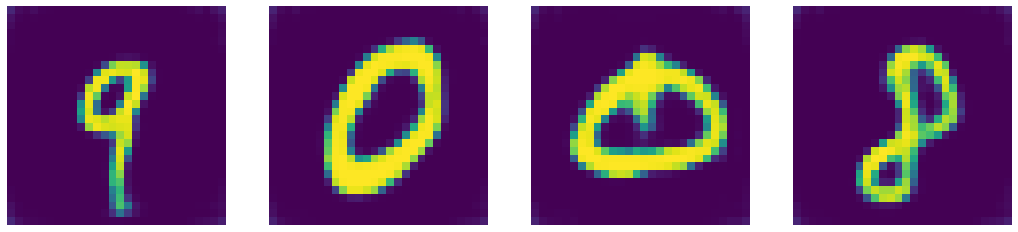

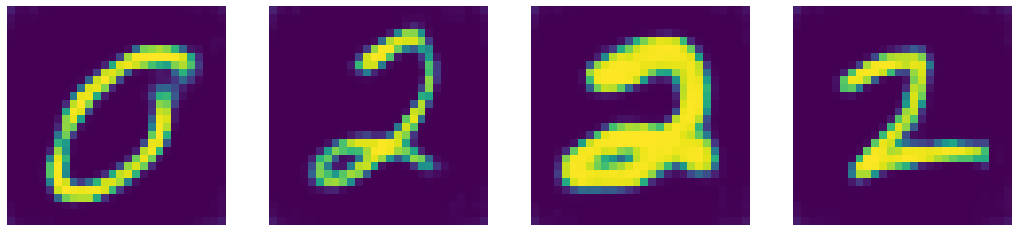

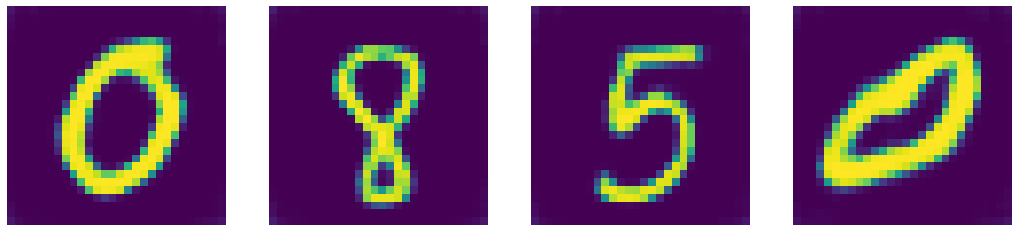

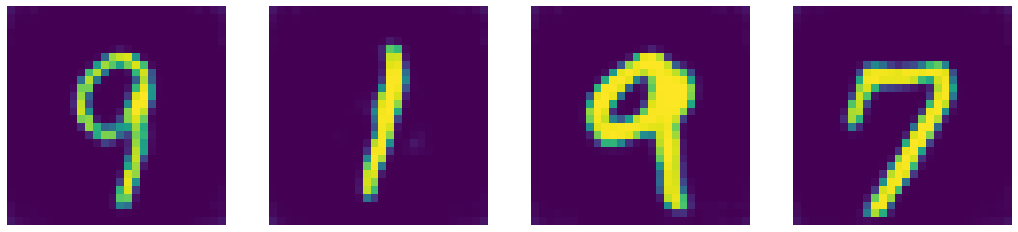

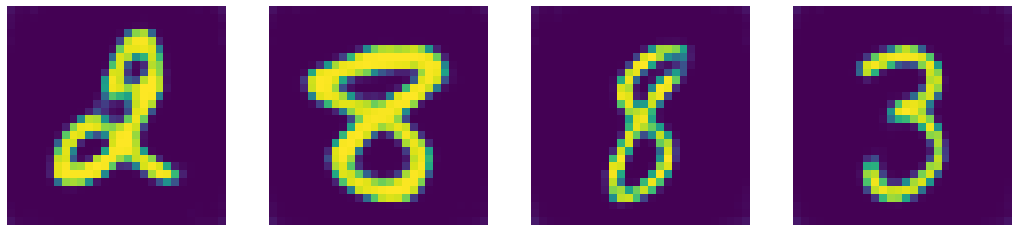

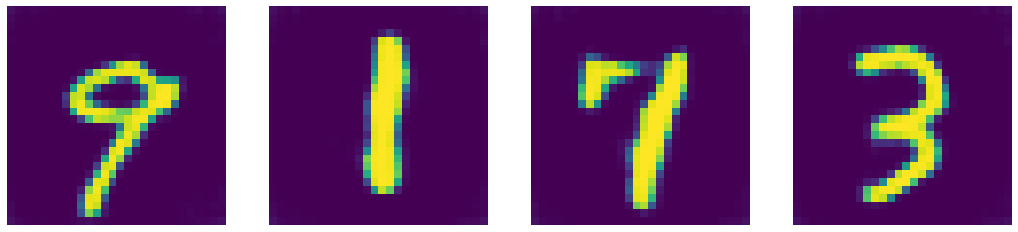

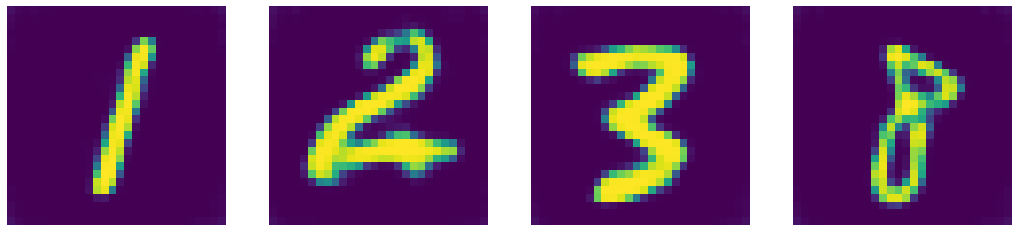

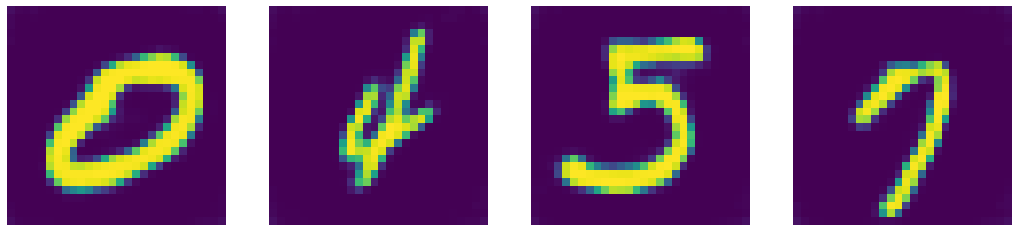

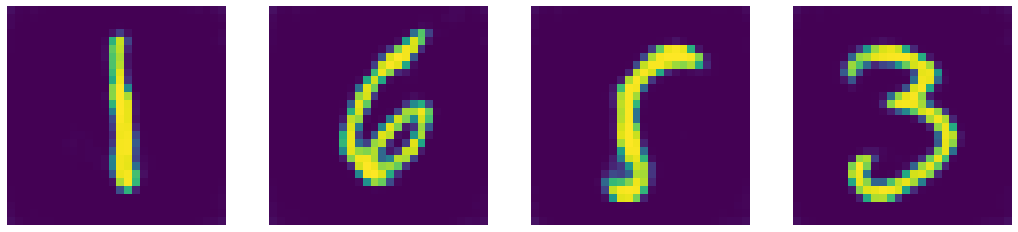

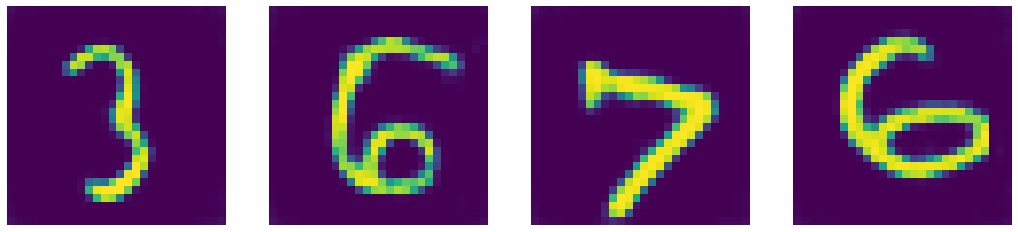

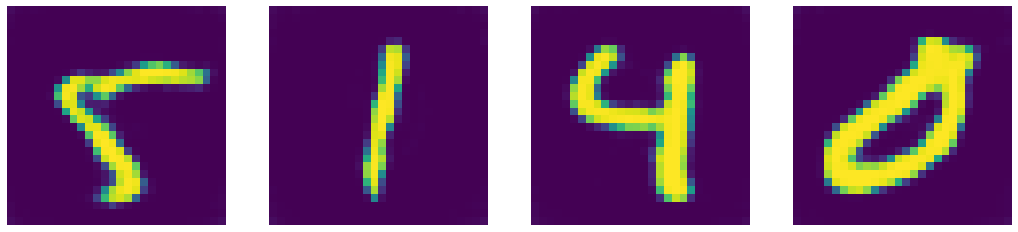

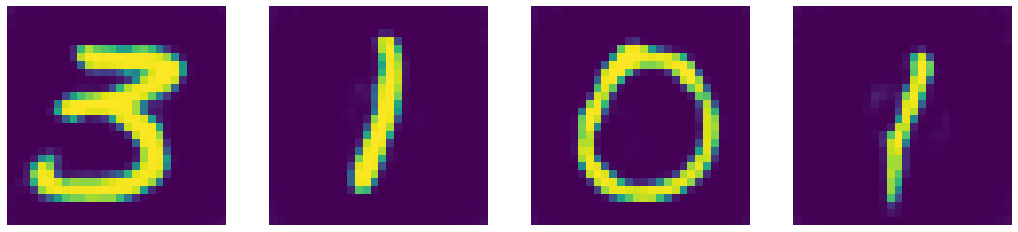

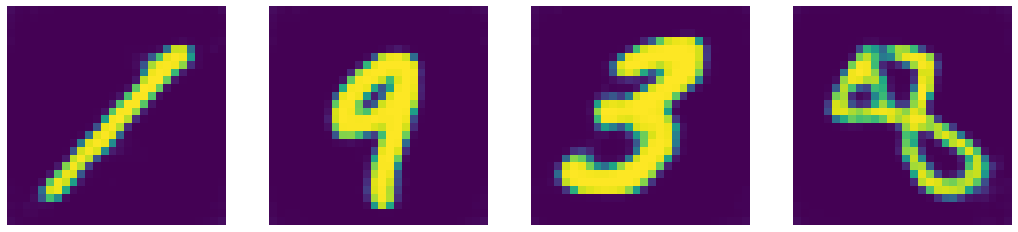

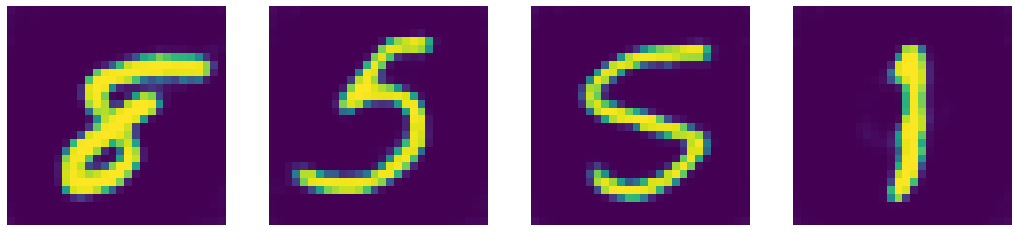

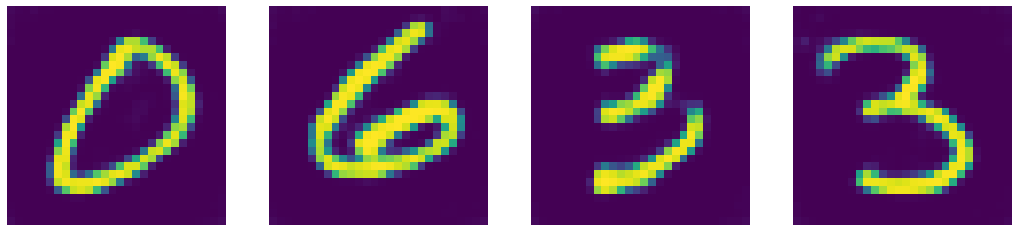

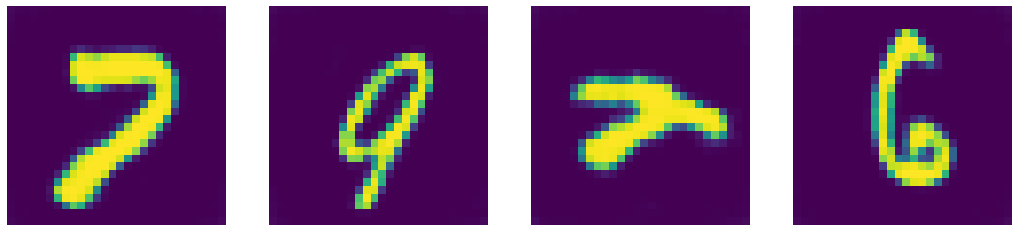

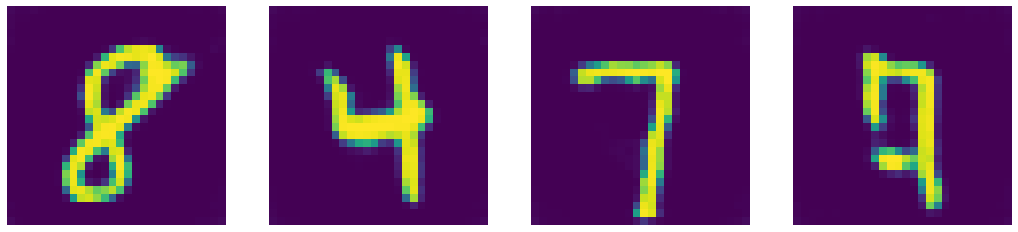

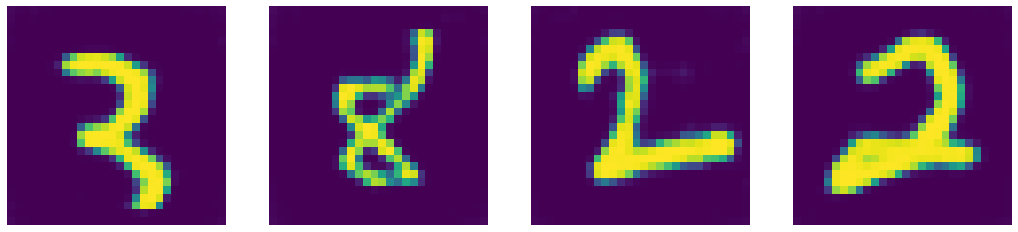

In [83]:
# Train standard or denoising autoencoder (AE)

num_epochs = 20
# do = nn.Dropout()  # comment out for standard AE
for epoch in range(num_epochs):
    for batch in dataloader:
        img, _ = batch
        img = img.to(device)
        #img = img.view(img.size(0), -1)
        # noise = do(torch.ones(img.shape)).to(device)
        # img_bad = (img * noise).to(device)  # comment out for standard AE
        # ===================forward=====================
        output = model(img)  # feed <img> (for std AE) or <img_bad> (for denoising AE)
        loss = criterion(output, img.data)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print(f'epoch [{epoch + 1}/{num_epochs}], loss:{loss.item():.4f}')
    display_images(None, output)  # pass (None, output) for std AE, (img_bad, output) for denoising AE

Train more epochs:

epoch [1/20], loss:0.0071
epoch [2/20], loss:0.0077
epoch [3/20], loss:0.0068
epoch [4/20], loss:0.0058
epoch [5/20], loss:0.0061
epoch [6/20], loss:0.0060
epoch [7/20], loss:0.0061
epoch [8/20], loss:0.0061
epoch [9/20], loss:0.0061
epoch [10/20], loss:0.0073
epoch [11/20], loss:0.0094
epoch [12/20], loss:0.0058
epoch [13/20], loss:0.0060
epoch [14/20], loss:0.0067
epoch [15/20], loss:0.0085
epoch [16/20], loss:0.0060
epoch [17/20], loss:0.0059
epoch [18/20], loss:0.0062
epoch [19/20], loss:0.0076
epoch [20/20], loss:0.0059


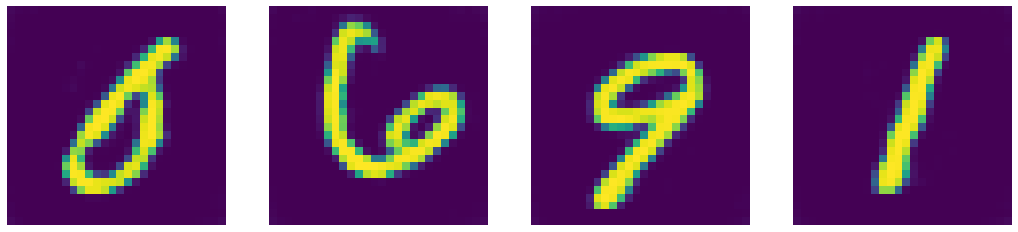

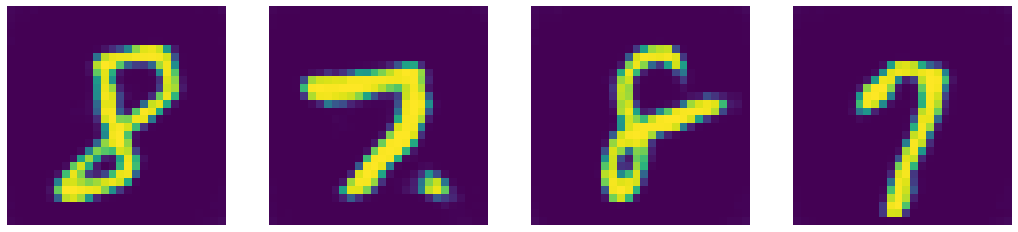

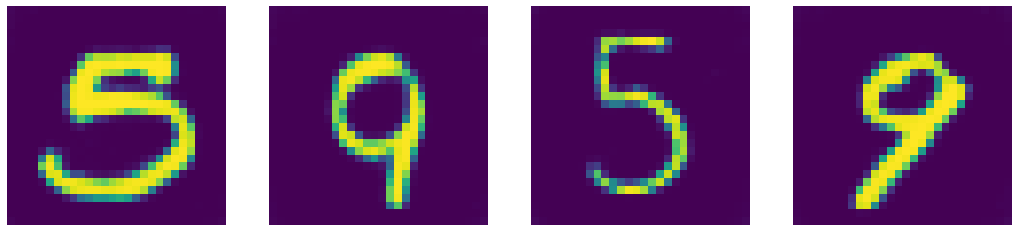

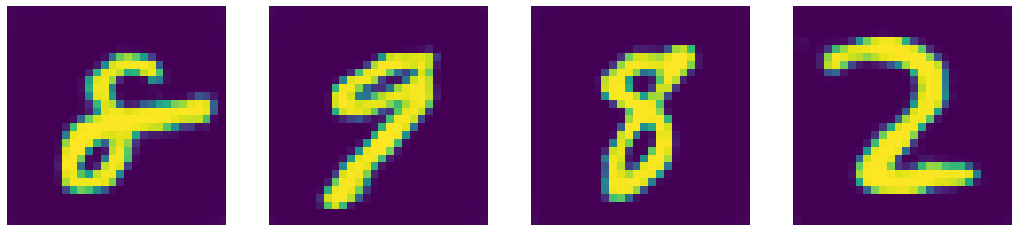

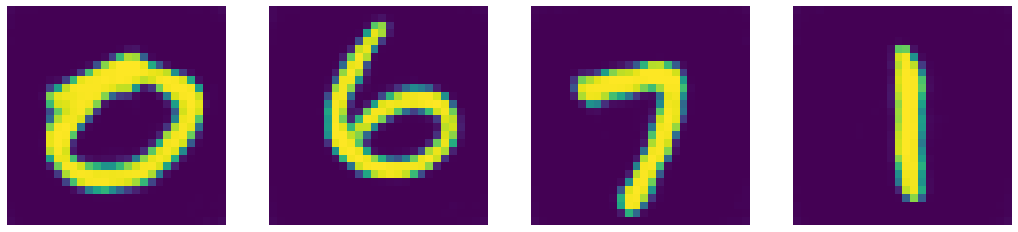

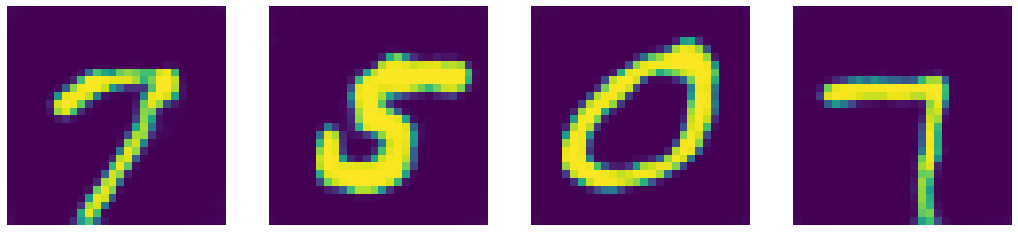

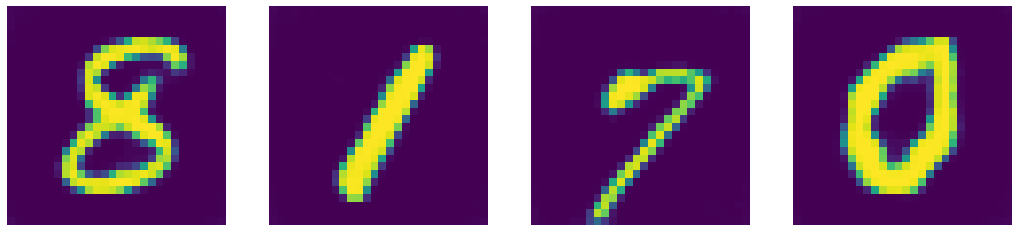

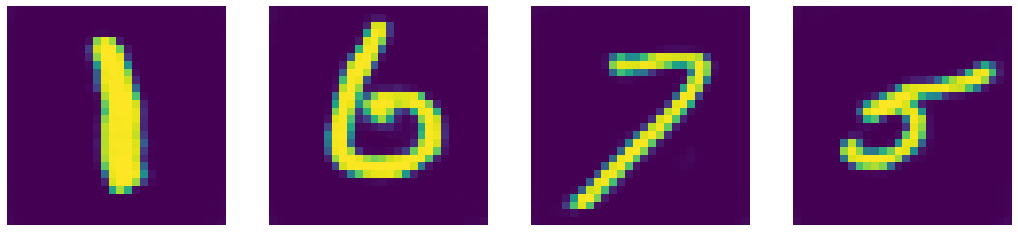

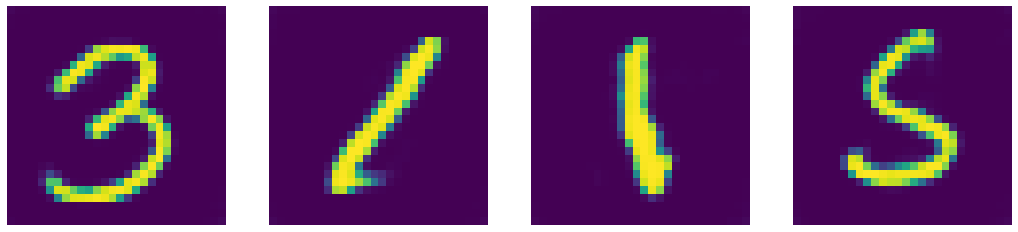

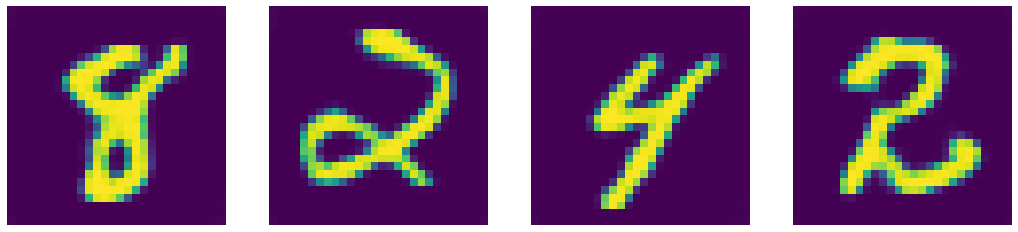

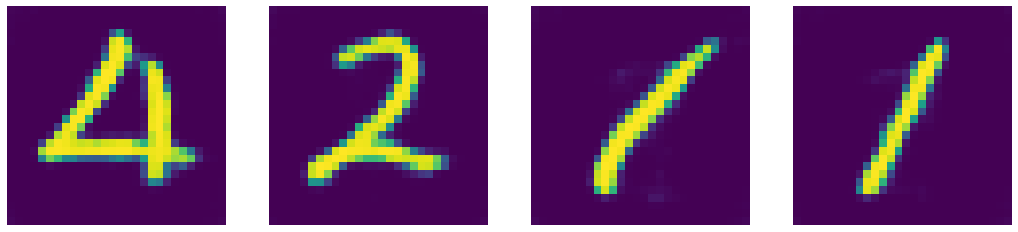

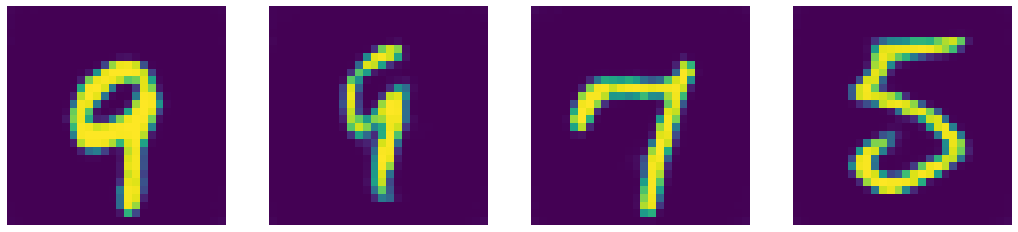

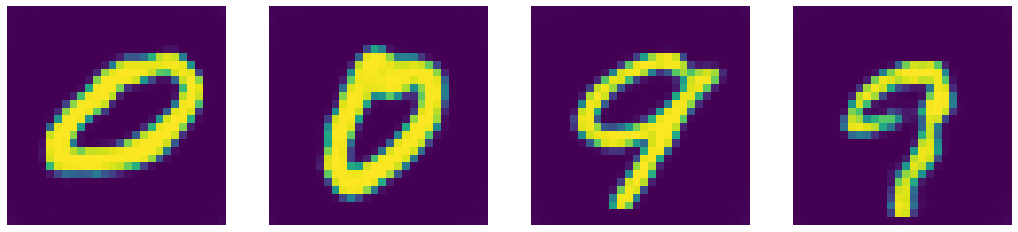

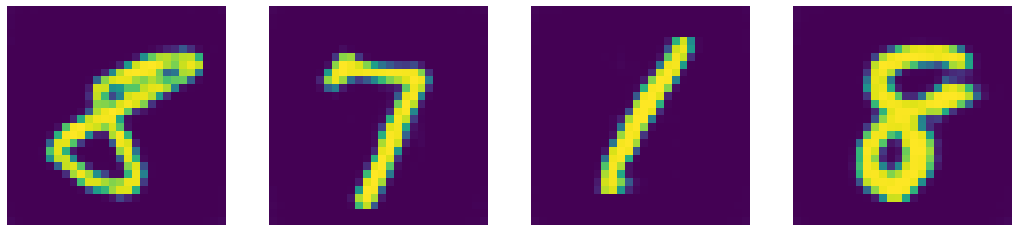

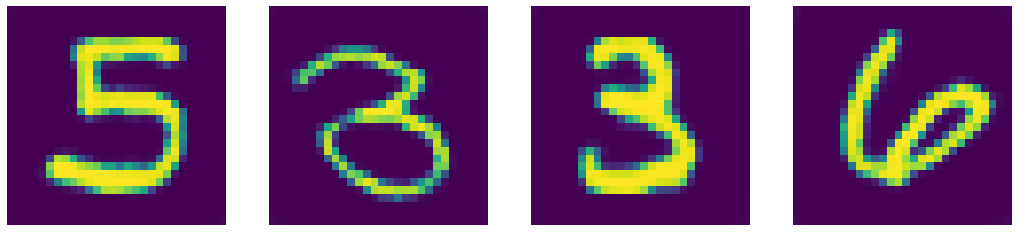

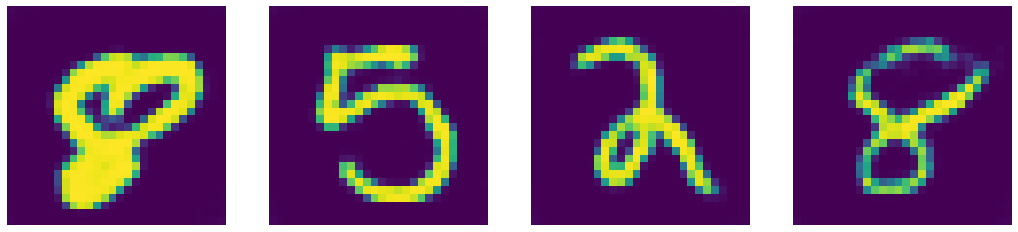

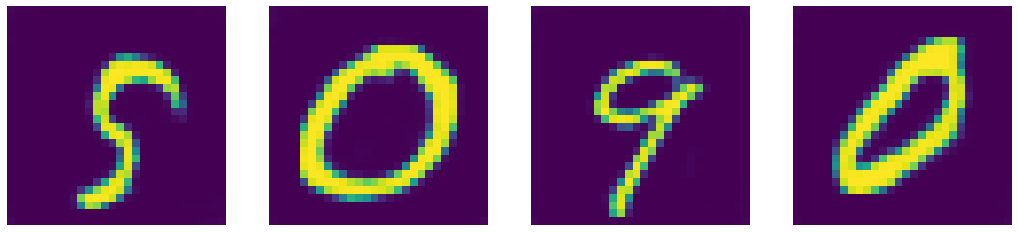

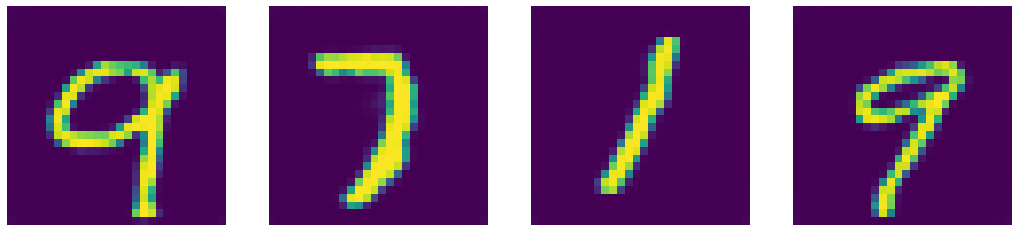

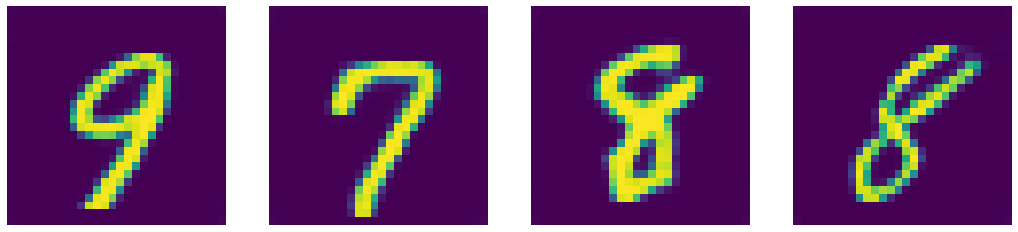

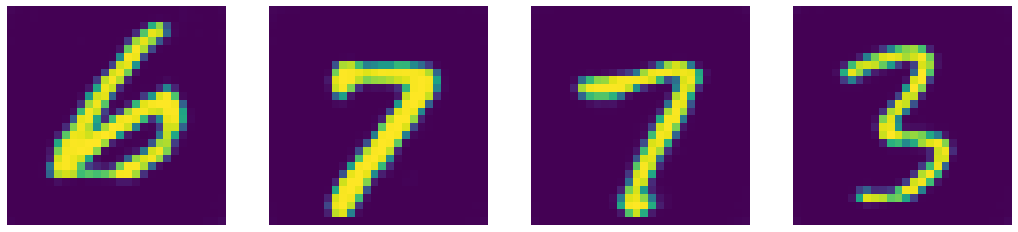

In [84]:
num_epochs = 20
learning_rate = 1e-4
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

for epoch in range(num_epochs):
    for batch in dataloader:
        img, _ = batch
        img = img.to(device)
        # ===================forward=====================
        output = model(img)
        loss = criterion(output, img.data)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print(f'epoch [{epoch + 1}/{num_epochs}], loss:{loss.item():.4f}')
    display_images(None, output)  # pass (None, output) for std AE, (img_bad, output) for denoising AE

epoch [1/20], loss:0.0051
epoch [2/20], loss:0.0062
epoch [3/20], loss:0.0048
epoch [4/20], loss:0.0062
epoch [5/20], loss:0.0050
epoch [6/20], loss:0.0057
epoch [7/20], loss:0.0047
epoch [8/20], loss:0.0055
epoch [9/20], loss:0.0048
epoch [10/20], loss:0.0053
epoch [11/20], loss:0.0044
epoch [12/20], loss:0.0045
epoch [13/20], loss:0.0052
epoch [14/20], loss:0.0047
epoch [15/20], loss:0.0061
epoch [16/20], loss:0.0054
epoch [17/20], loss:0.0044
epoch [18/20], loss:0.0053
epoch [19/20], loss:0.0055
epoch [20/20], loss:0.0054


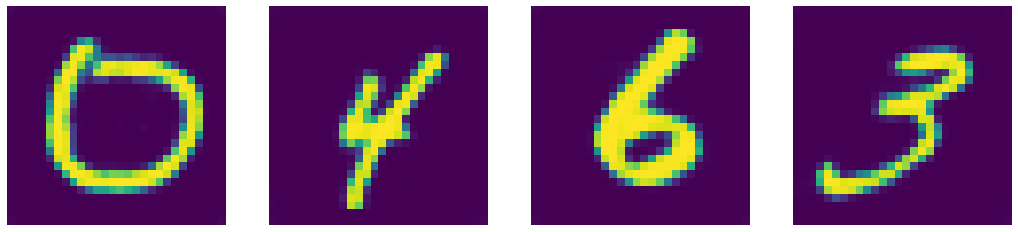

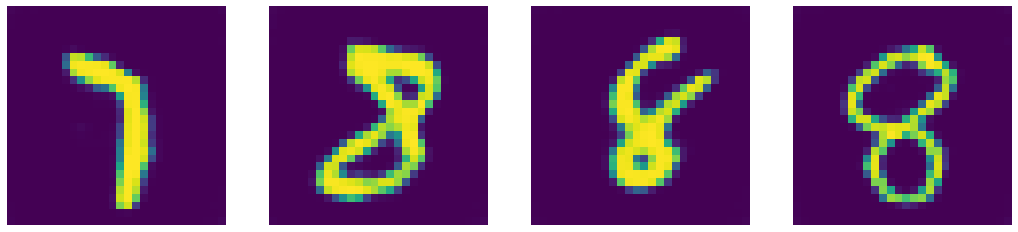

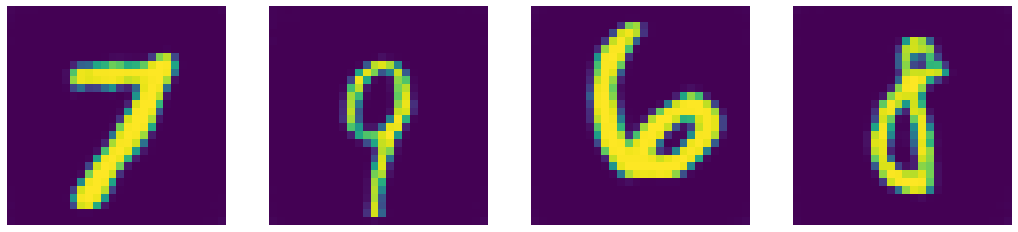

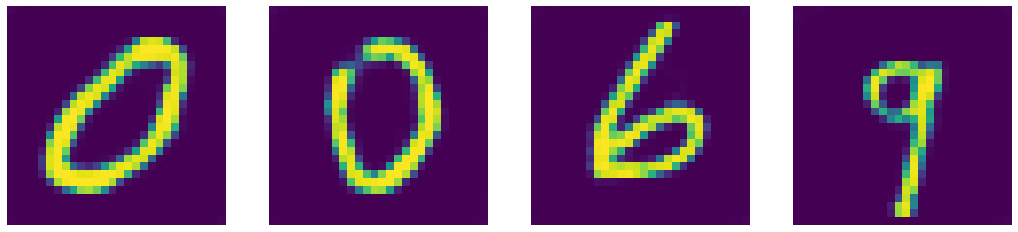

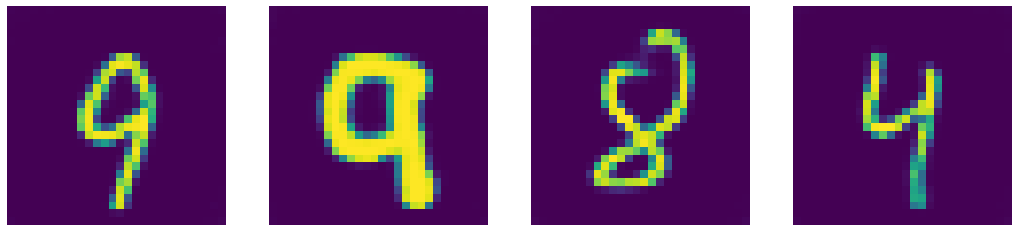

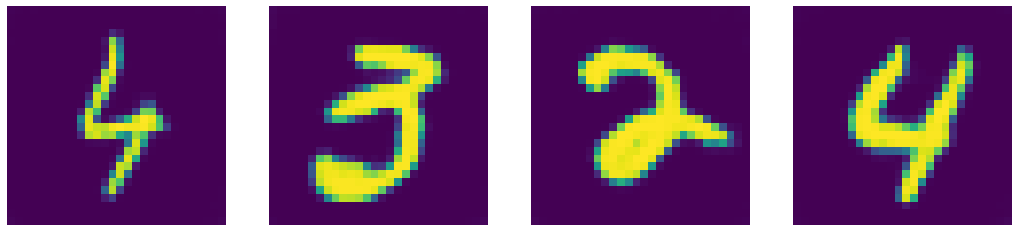

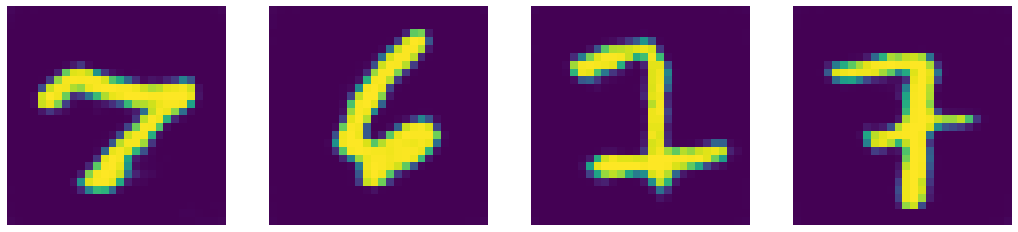

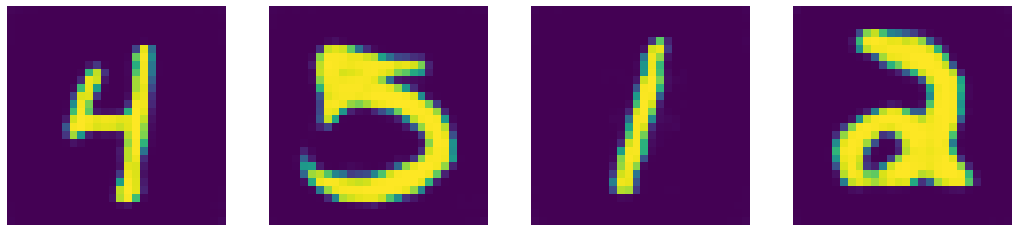

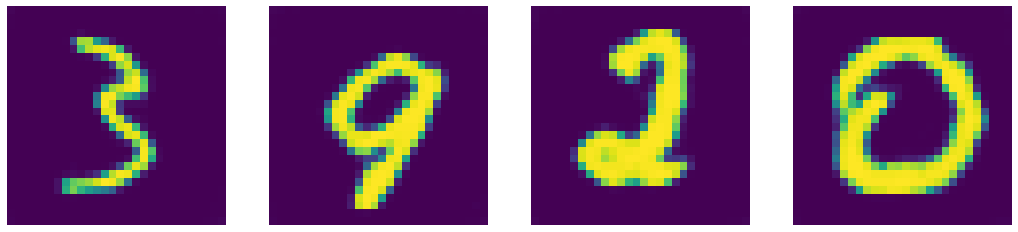

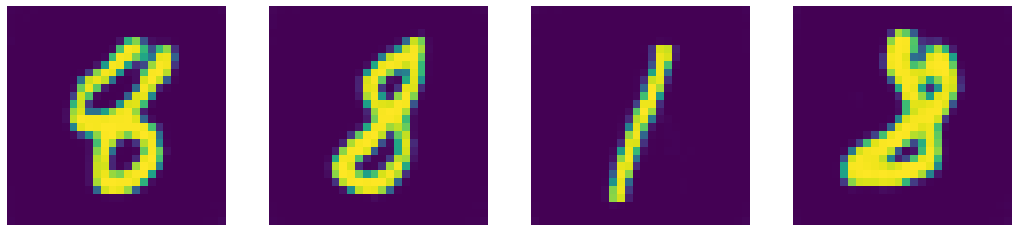

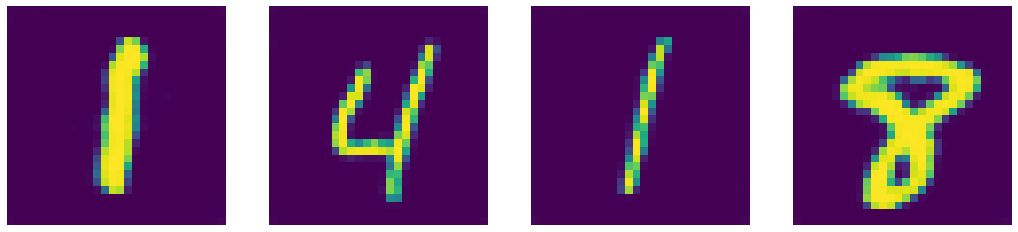

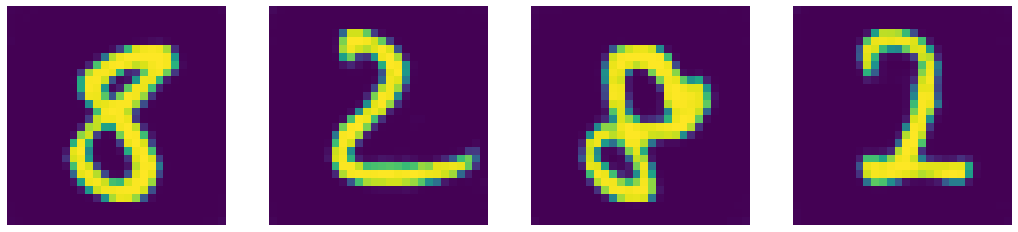

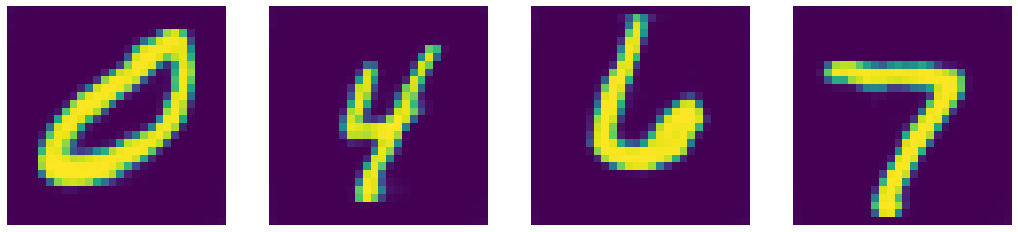

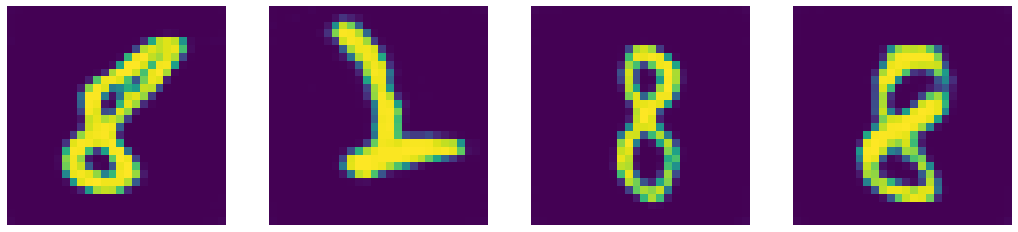

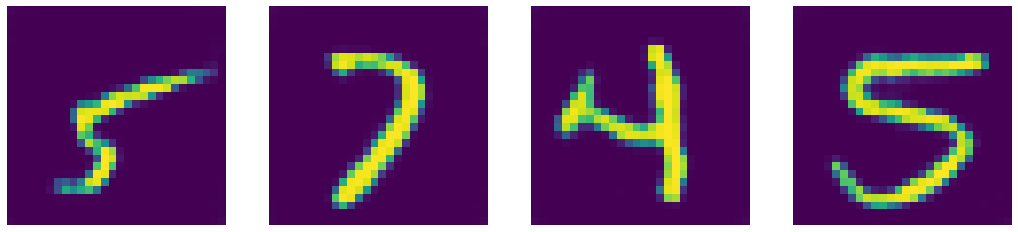

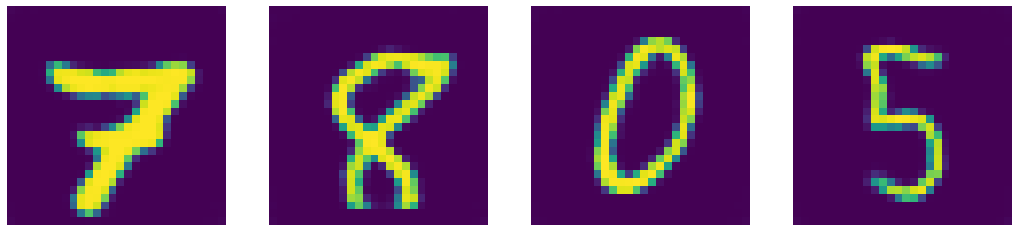

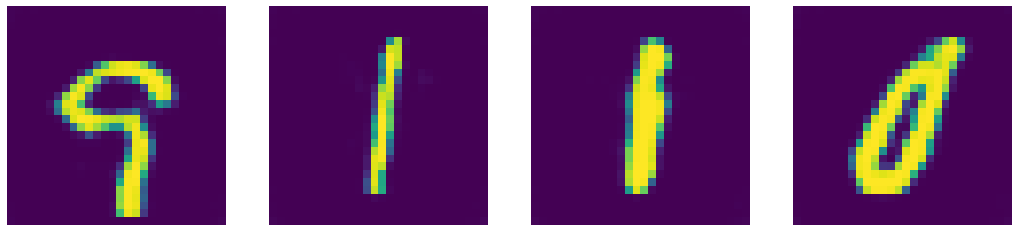

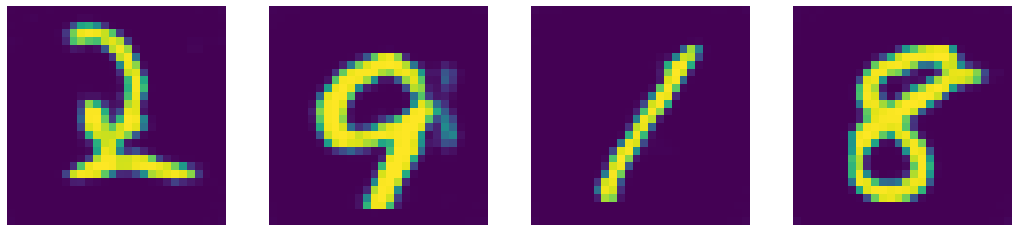

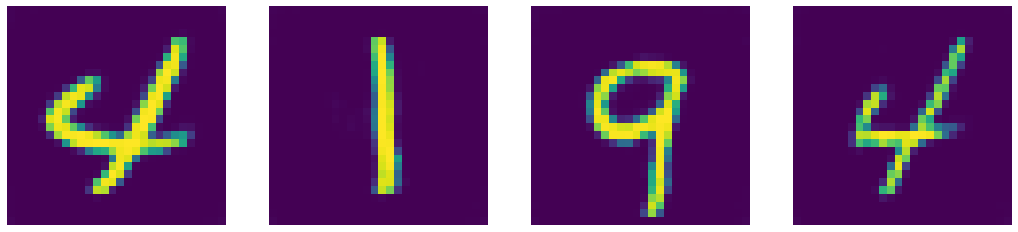

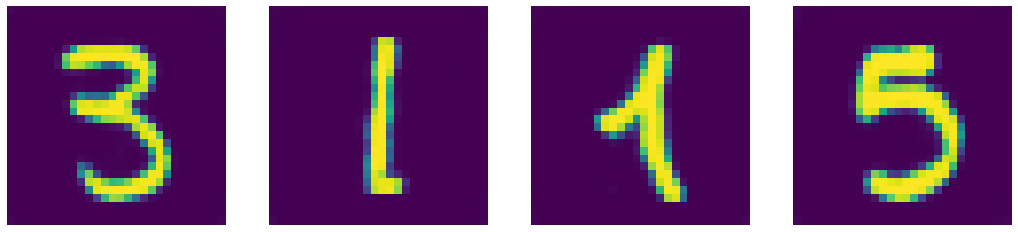

In [85]:
num_epochs = 20
learning_rate = 1e-5
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

for epoch in range(num_epochs):
    for batch in dataloader:
        img, _ = batch
        img = img.to(device)
        # ===================forward=====================
        output = model(img)
        loss = criterion(output, img.data)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print(f'epoch [{epoch + 1}/{num_epochs}], loss:{loss.item():.4f}')
    display_images(None, output)  # pass (None, output) for std AE, (img_bad, output) for denoising AE

In [91]:
512 / 16

32.0

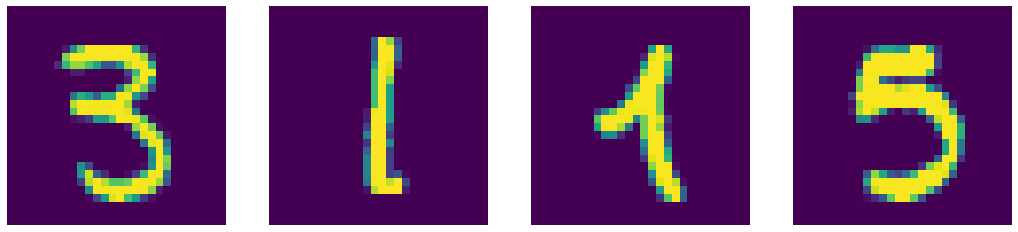

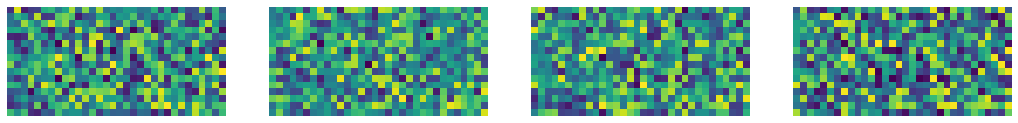

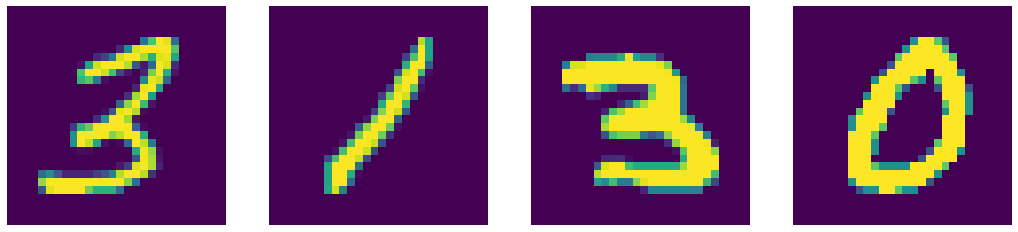

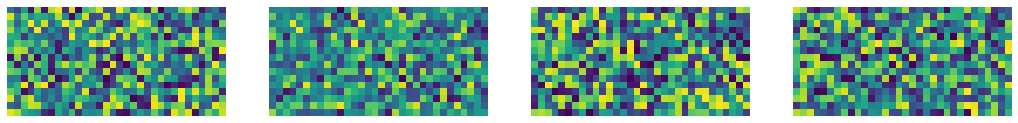

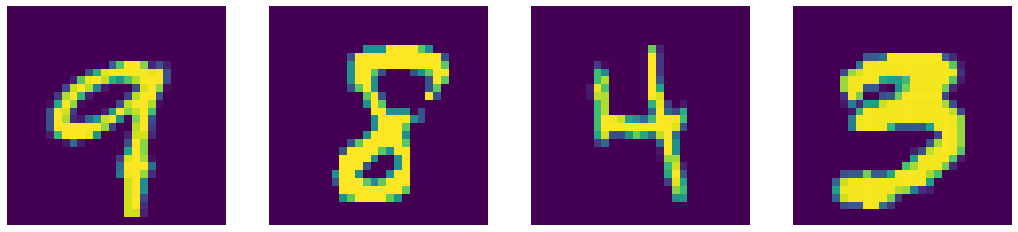

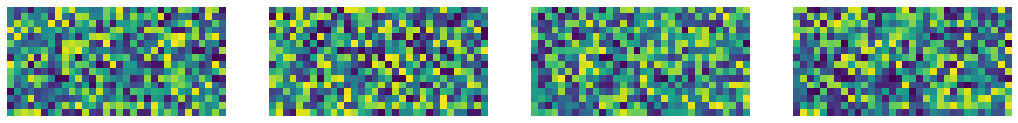

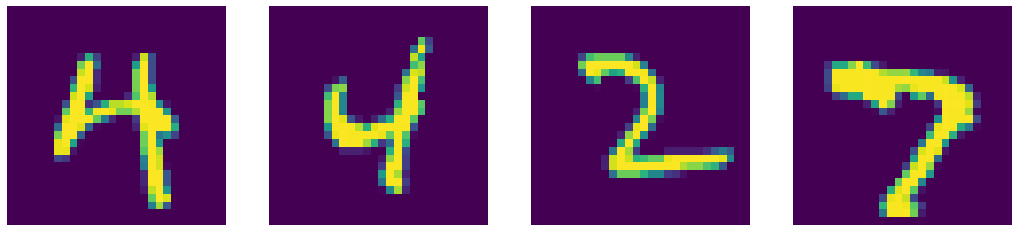

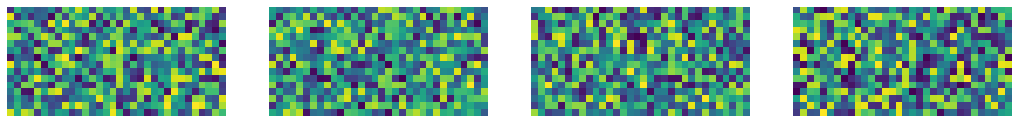

In [92]:
# visualize a few of the hidden representations
feat = model.get_features(img)
display_images(img, feat, n = 4, w_out=16, h_out=32)

# Denoising AE

### Overcomplete & shallow

In [20]:
# Define model architecture and reconstruction loss

# n = 28 x 28 = 784
d = 30*30   #500  # for denoising AE (over-complete hidden layer)

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, d),
            nn.Tanh(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(d, 28 * 28),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def get_features(self, x):
        x = self.encoder(x)
        return x
    
model = Autoencoder().to(device)
criterion = nn.MSELoss()

In [21]:
# Configure the optimiser

learning_rate = 1e-3

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

*Comment* or *un-comment out* a few lines of code to seamlessly switch between *standard AE* and *denoising one*.

Don't forget to **(1)** change the size of the hidden layer accordingly, **(2)** re-generate the model, and **(3)** re-pass the parameters to the optimiser.

epoch [1/20], loss:0.0640
epoch [2/20], loss:0.0515
epoch [3/20], loss:0.0504
epoch [4/20], loss:0.0442
epoch [5/20], loss:0.0447
epoch [6/20], loss:0.0414
epoch [7/20], loss:0.0423
epoch [8/20], loss:0.0444
epoch [9/20], loss:0.0363
epoch [10/20], loss:0.0393
epoch [11/20], loss:0.0374


<ipython-input-3-a84e5032819c>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(18, 6))
<ipython-input-3-a84e5032819c>:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(18, 6))


epoch [12/20], loss:0.0360
epoch [13/20], loss:0.0371
epoch [14/20], loss:0.0370
epoch [15/20], loss:0.0396
epoch [16/20], loss:0.0360
epoch [17/20], loss:0.0375
epoch [18/20], loss:0.0376
epoch [19/20], loss:0.0368
epoch [20/20], loss:0.0359


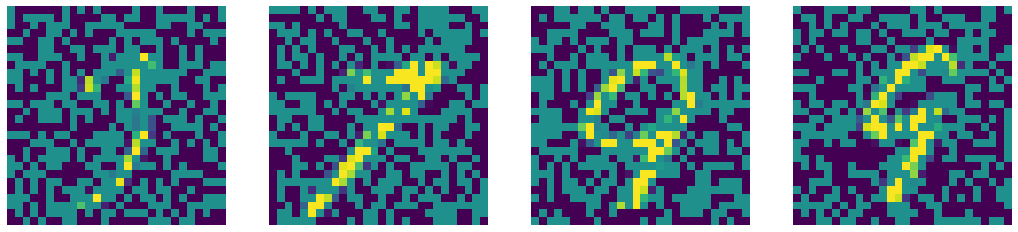

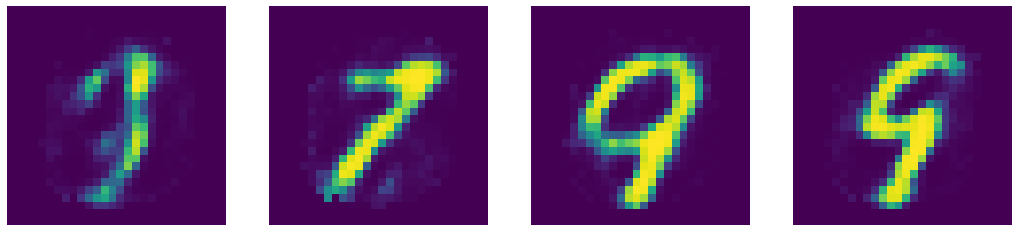

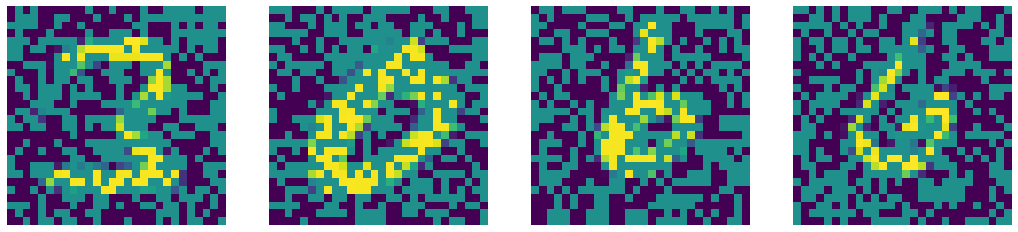

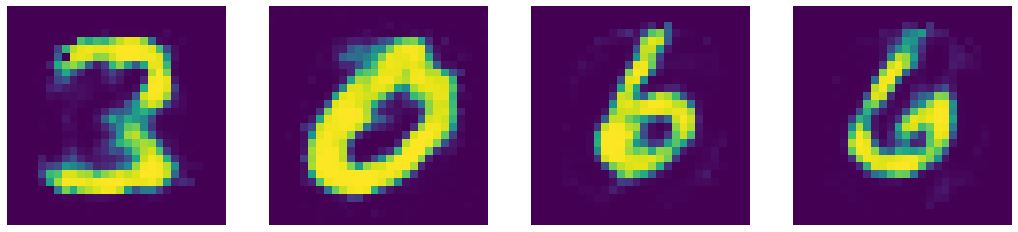

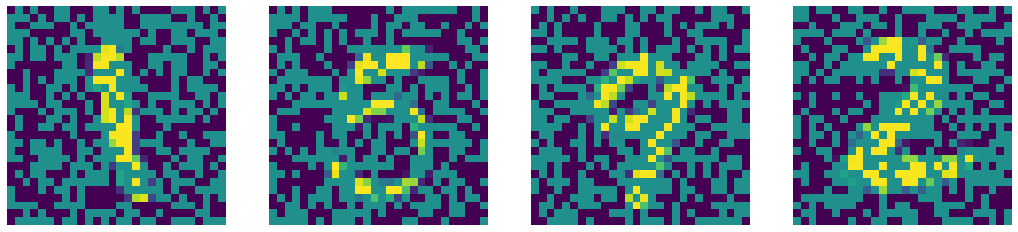

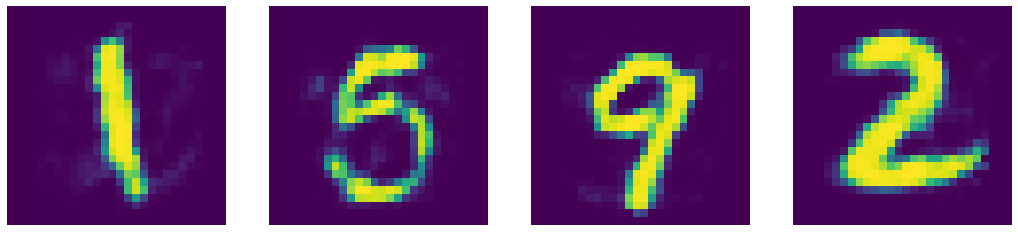

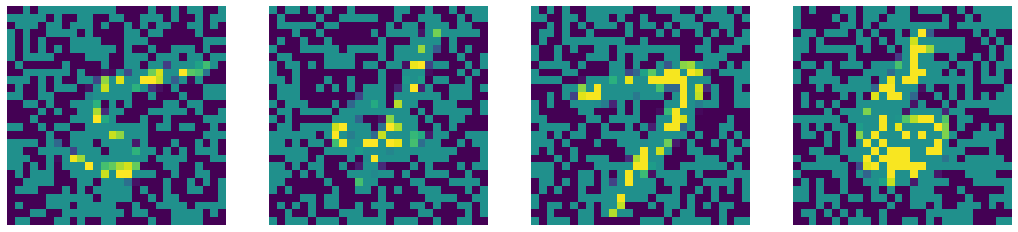

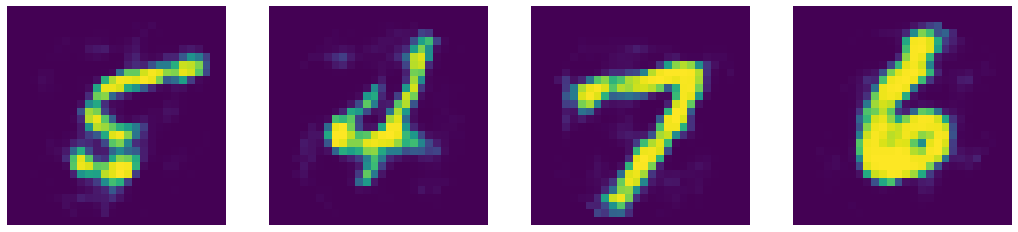

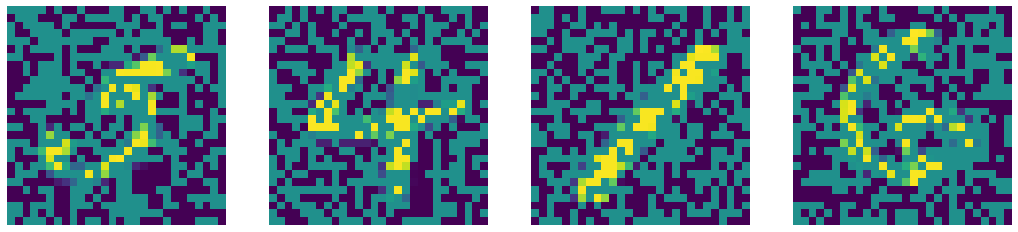

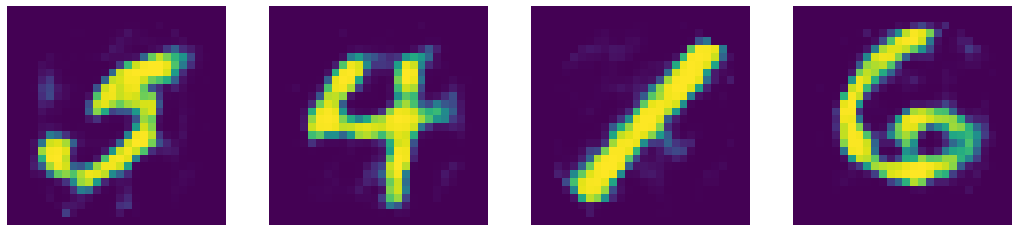

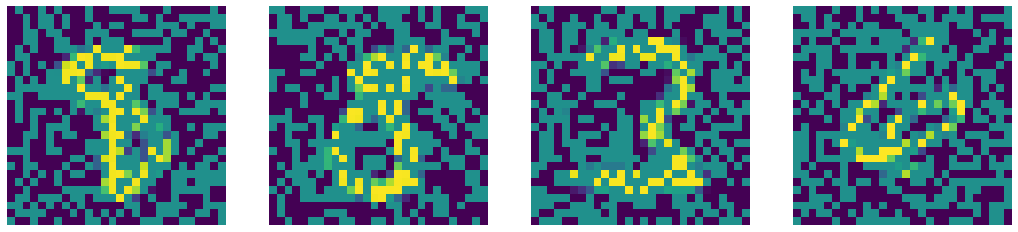

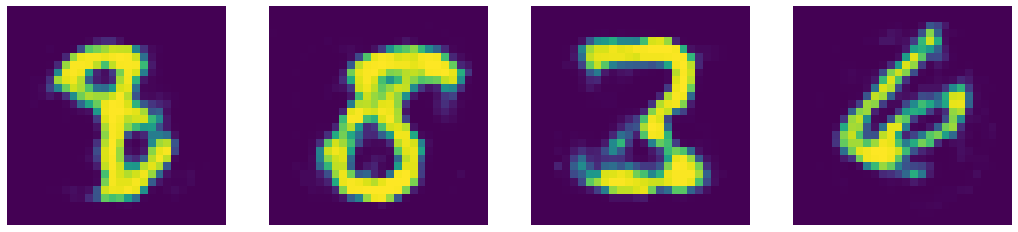

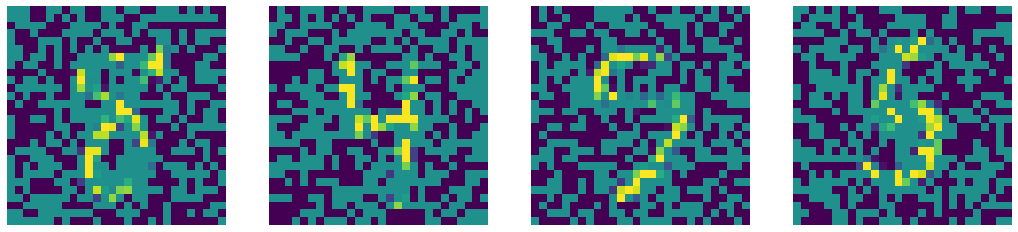

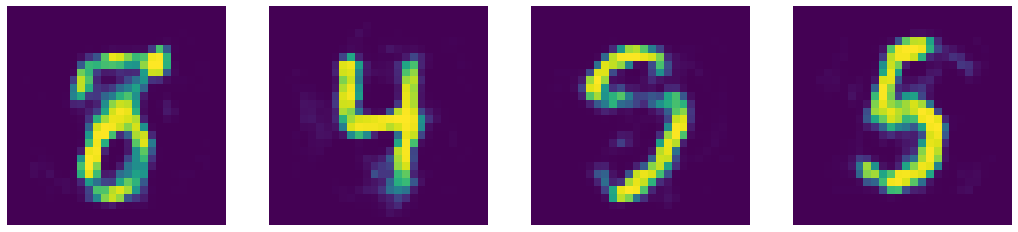

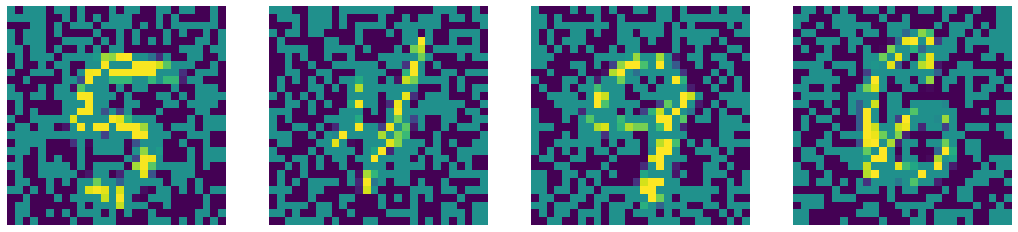

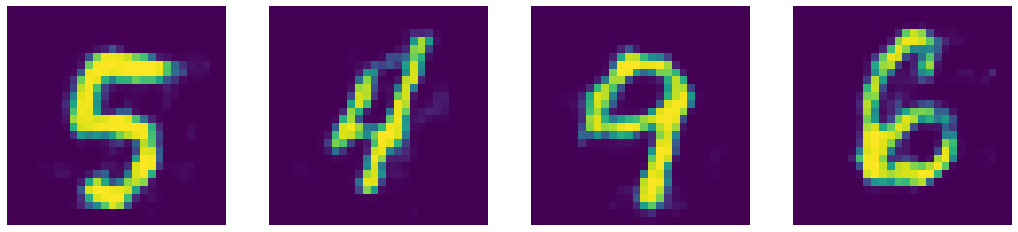

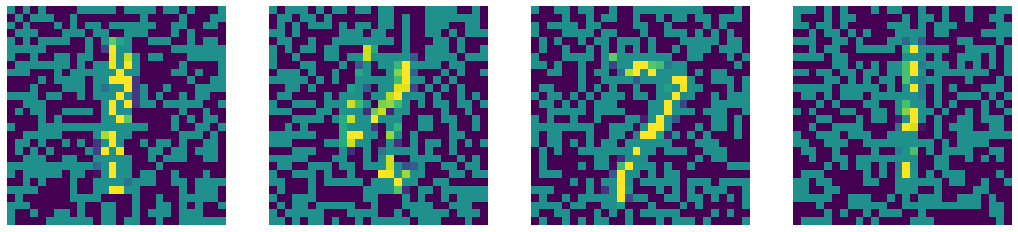

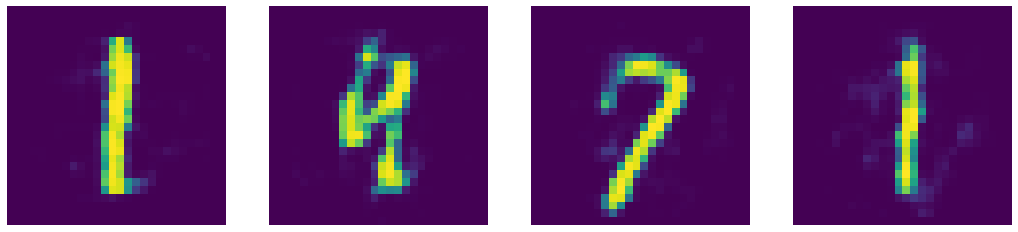

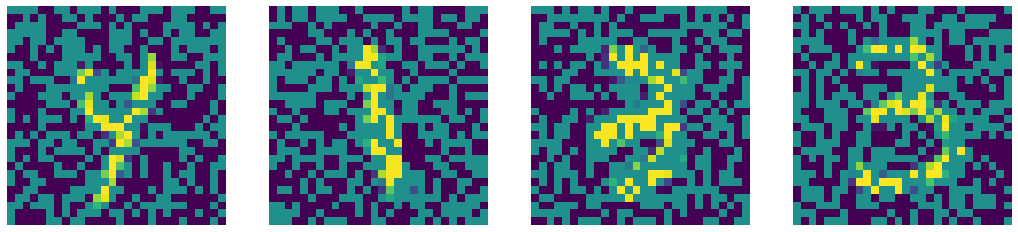

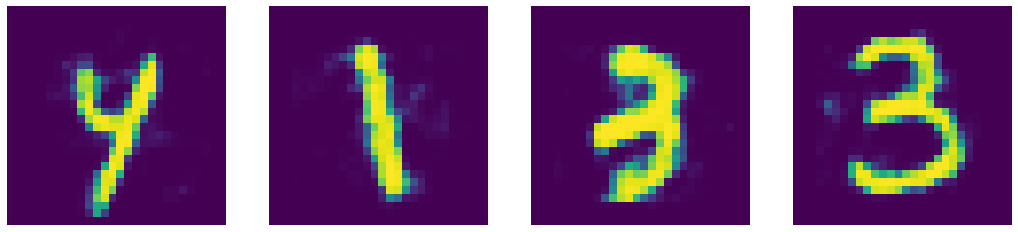

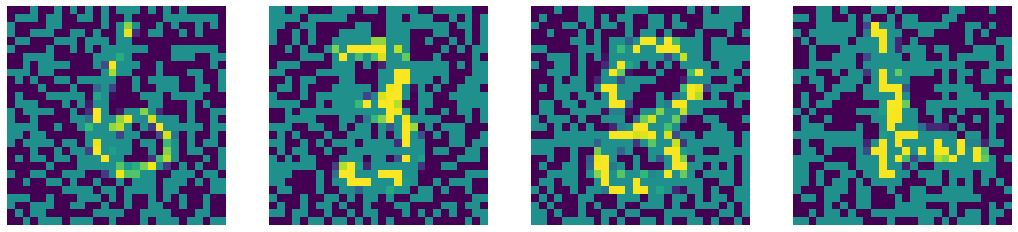

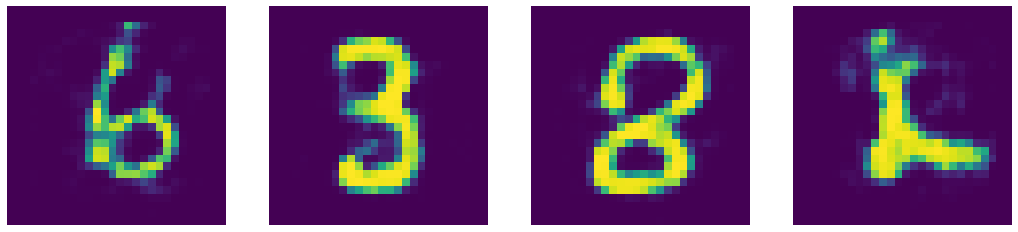

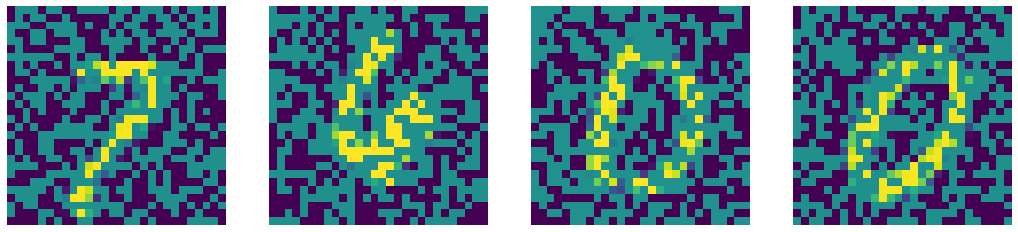

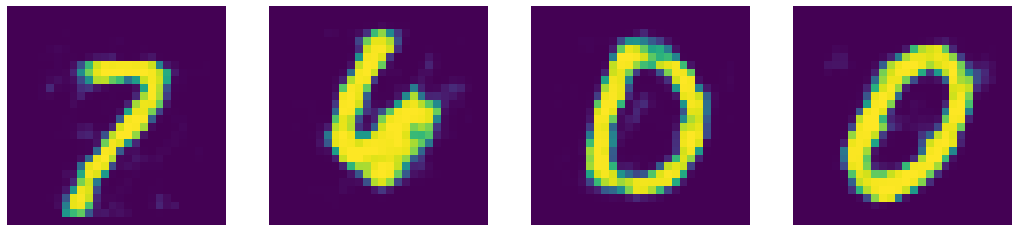

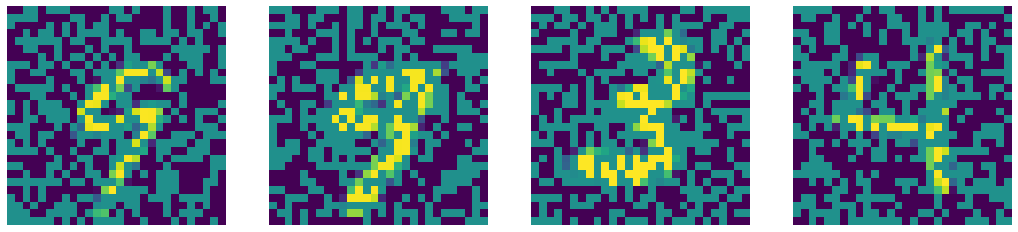

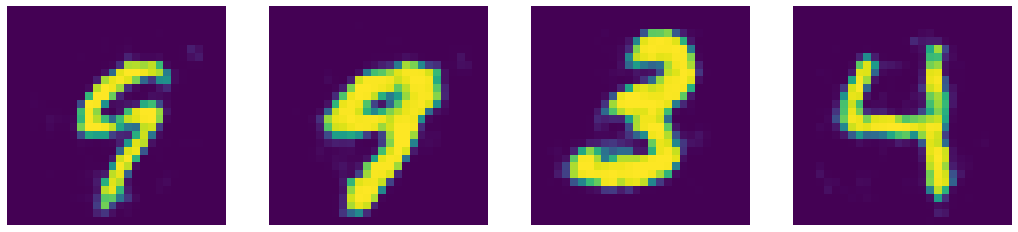

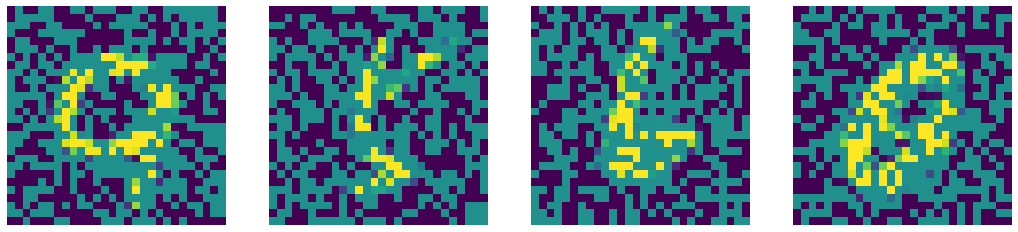

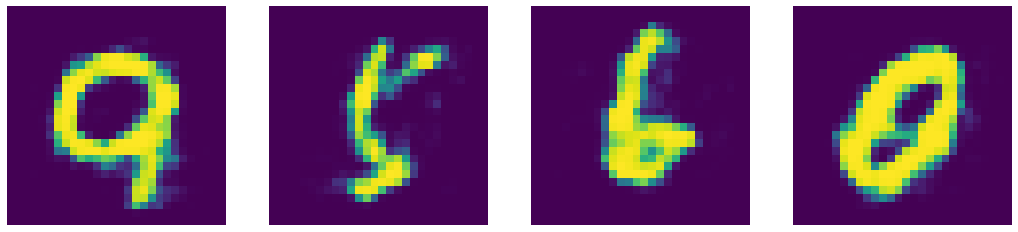

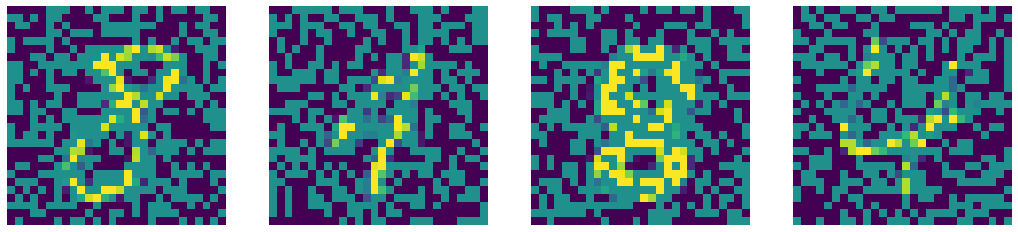

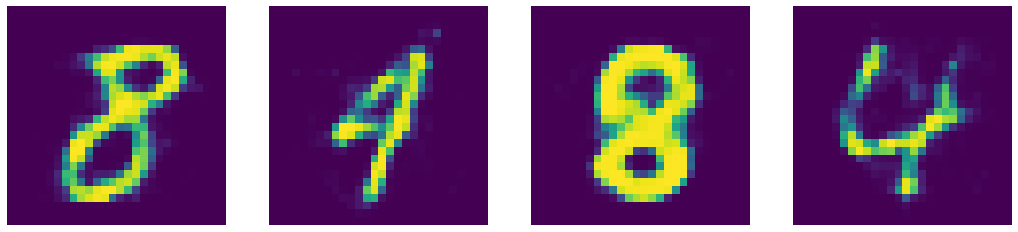

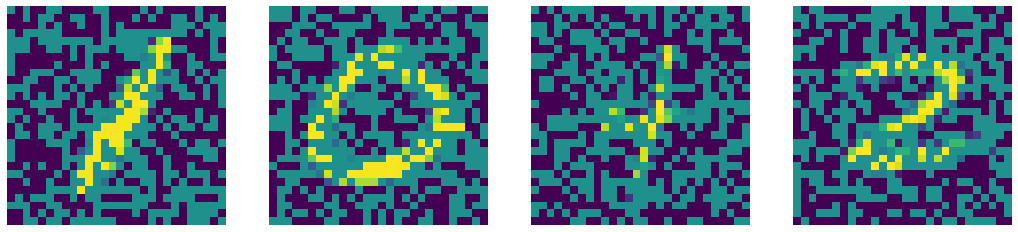

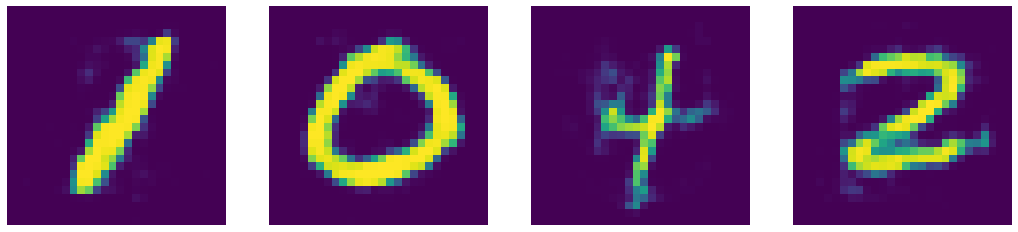

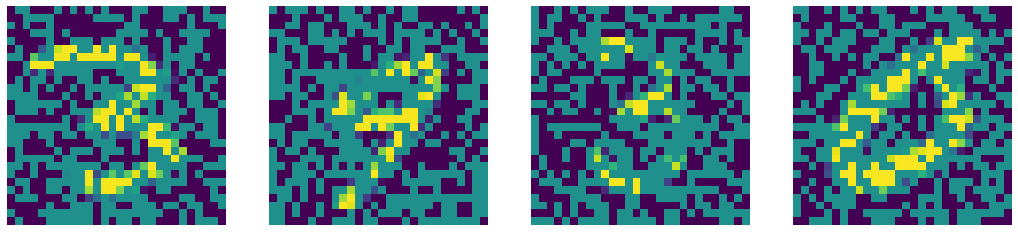

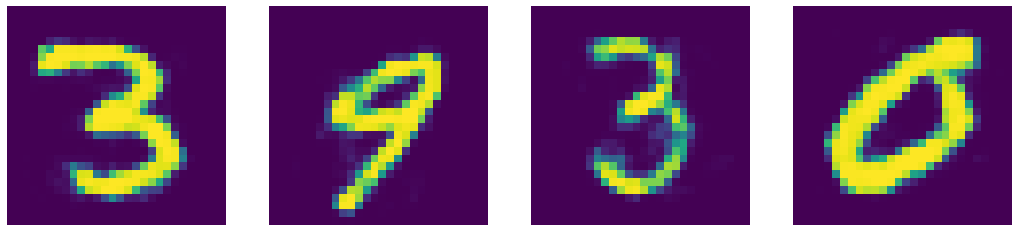

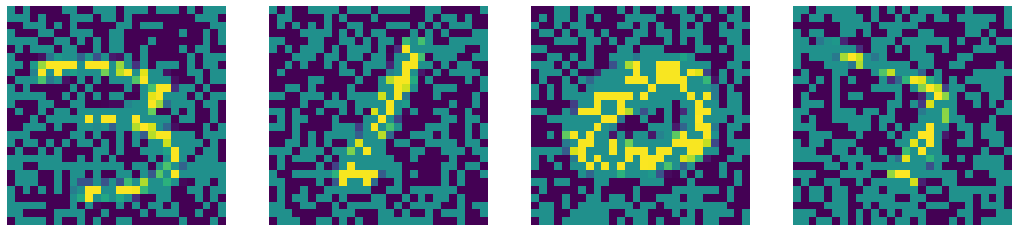

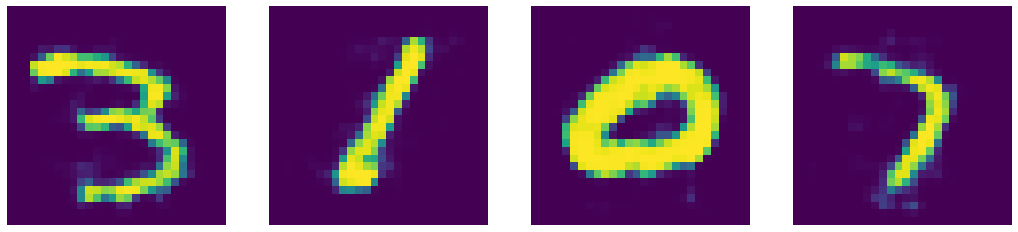

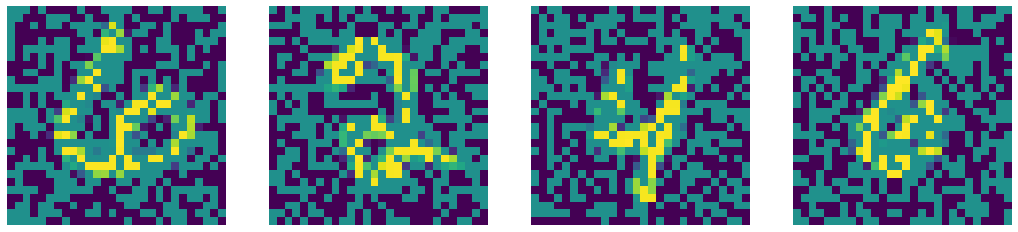

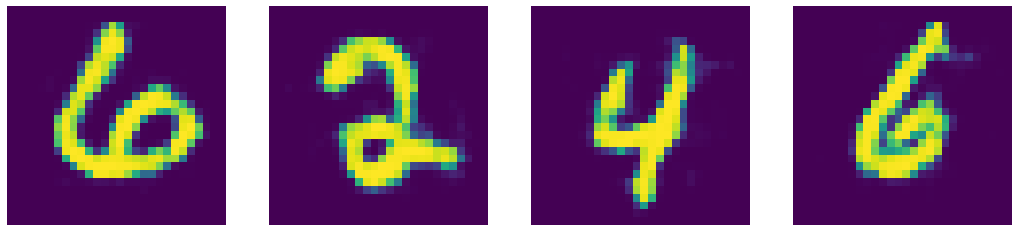

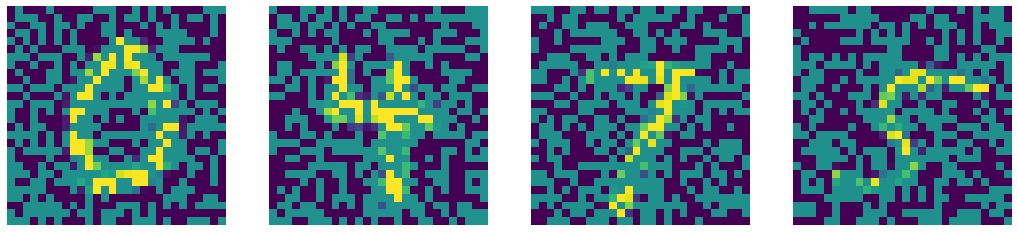

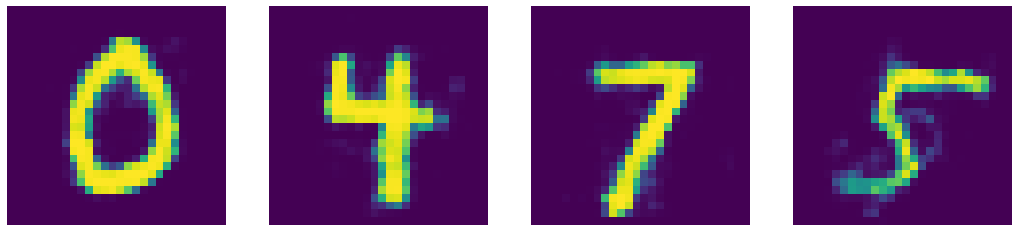

In [22]:
# Train standard or denoising autoencoder (AE)

num_epochs = 20
do = nn.Dropout()  # comment out for standard AE
for epoch in range(num_epochs):
    for batch in dataloader:
        img, _ = batch
        img = img.to(device)
        img = img.view(img.size(0), -1)
        noise = do(torch.ones(img.shape)).to(device)
        img_bad = (img * noise).to(device)  # comment out for standard AE
        # ===================forward=====================
        output = model(img_bad)  # feed <img> (for std AE) or <img_bad> (for denoising AE)
        loss = criterion(output, img.data)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print(f'epoch [{epoch + 1}/{num_epochs}], loss:{loss.item():.4f}')
    display_images(img_bad, output)  # pass (None, output) for std AE, (img_bad, output) for denoising AE

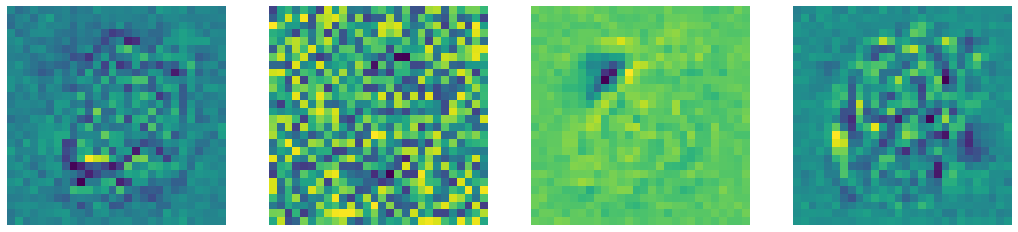

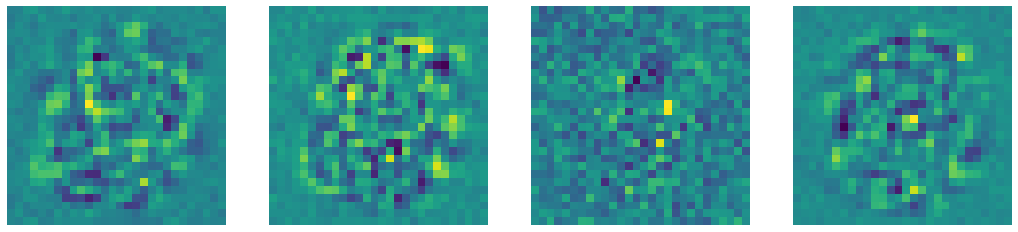

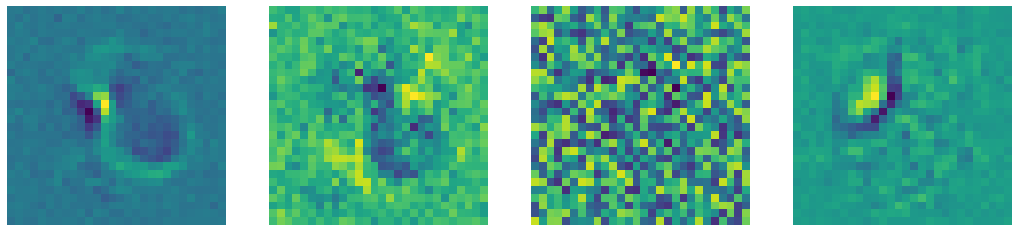

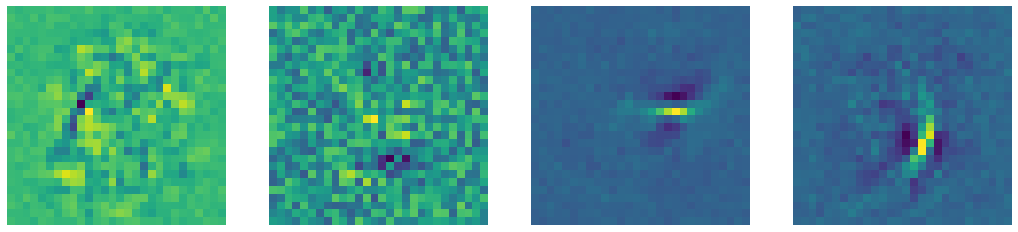

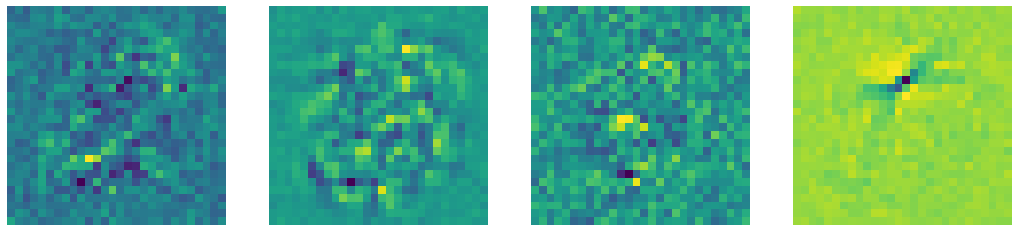

In [23]:
# Visualise a few kernels of the encoder

display_images(None, model.encoder[0].weight, 5)

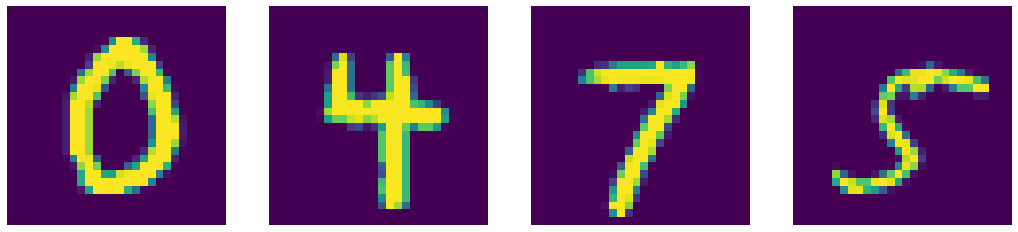

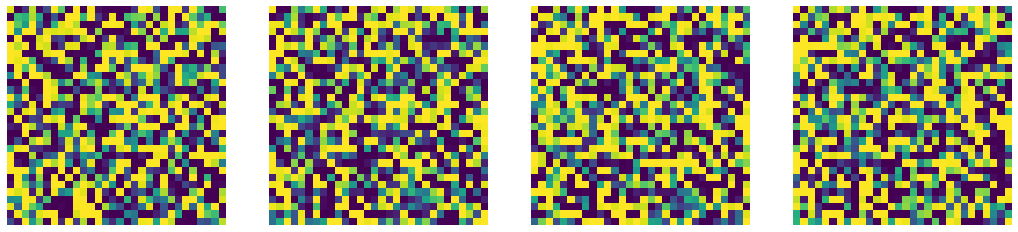

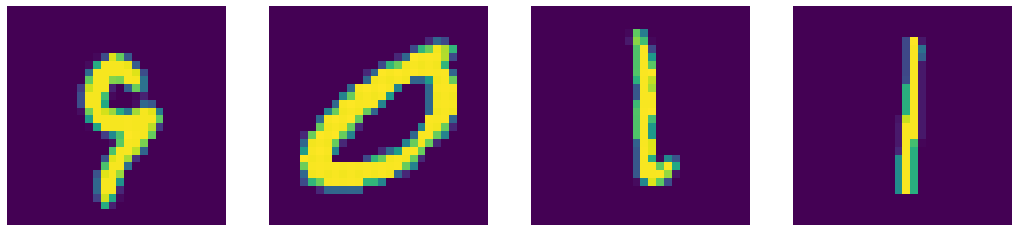

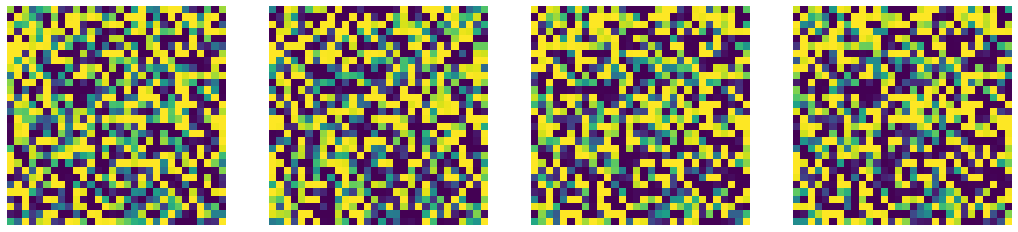

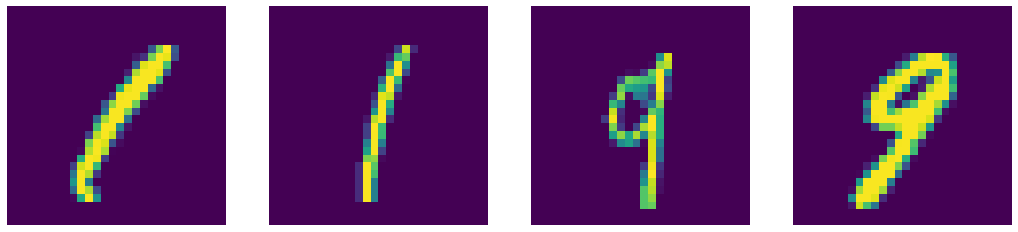

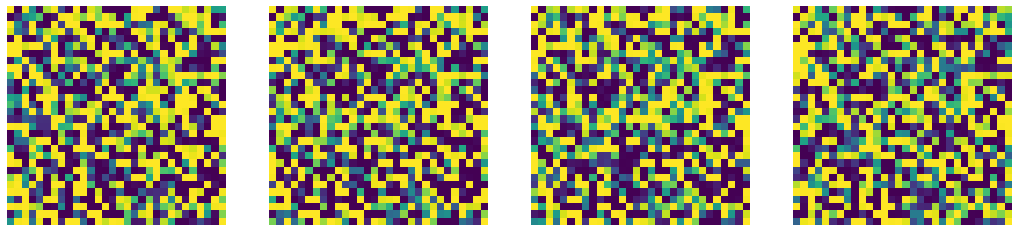

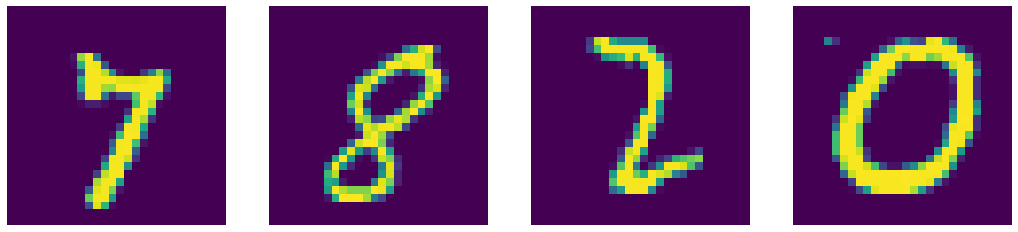

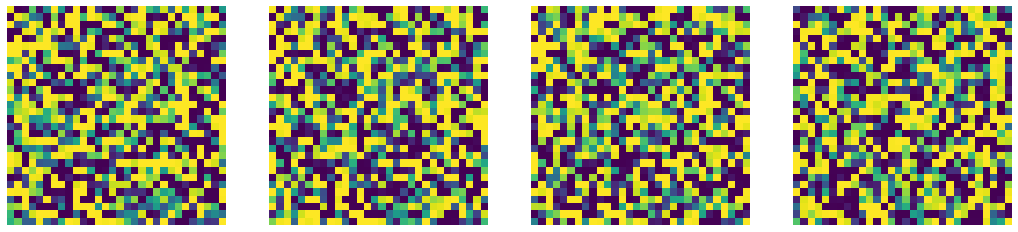

In [24]:
# visualize a few of the hidden representations
feat = model.get_features(img)
display_images(img, feat, n = 4, w_out=30, h_out=30)

### Comparison with traditional methods

In [25]:
# Let's compare the autoencoder inpainting capabilities vs. OpenCV
# RUN THIS ONLY AFTER HAVING TRAINED A DENOISING AE!!!

from cv2 import inpaint, INPAINT_NS, INPAINT_TELEA

In [26]:
# Inpaint with Telea and Navier-Stokes methods

dst_TELEA = list()
dst_NS = list()

for i in range(3, 7):
    corrupted_img = ((img_bad.data.cpu()[i].view(28, 28) / 4 + 0.5) * 255).byte().numpy()
    mask = 2 - noise.cpu()[i].view(28, 28).byte().numpy()
    dst_TELEA.append(inpaint(corrupted_img, mask, 3, INPAINT_TELEA))
    dst_NS.append(inpaint(corrupted_img, mask, 3, INPAINT_NS))

tns_TELEA = [torch.from_numpy(d) for d in dst_TELEA]
tns_NS = [torch.from_numpy(d) for d in dst_NS]

TELEA = torch.stack(tns_TELEA).float()
NS = torch.stack(tns_NS).float()

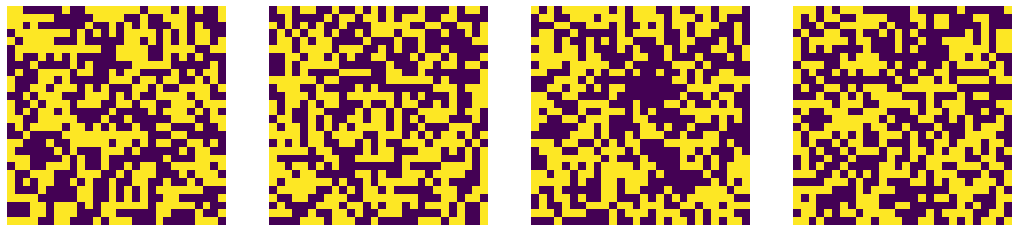

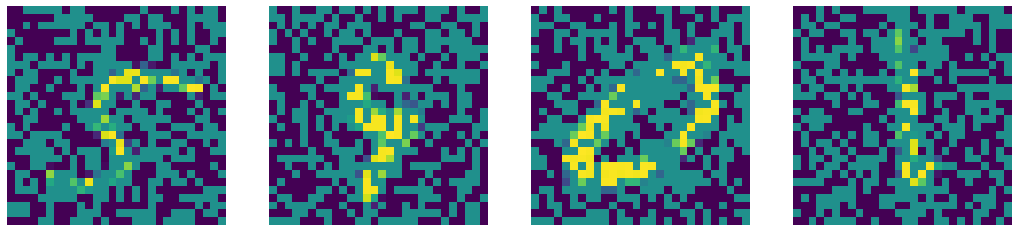

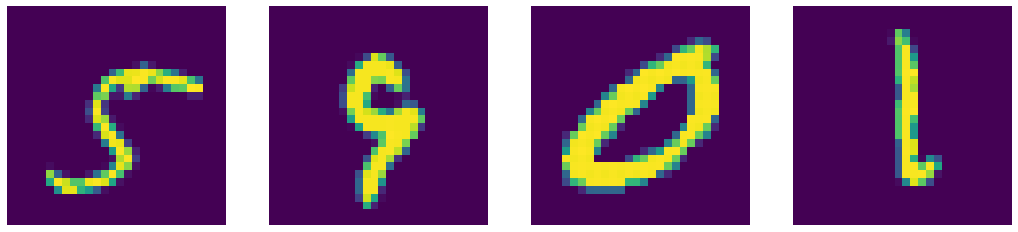

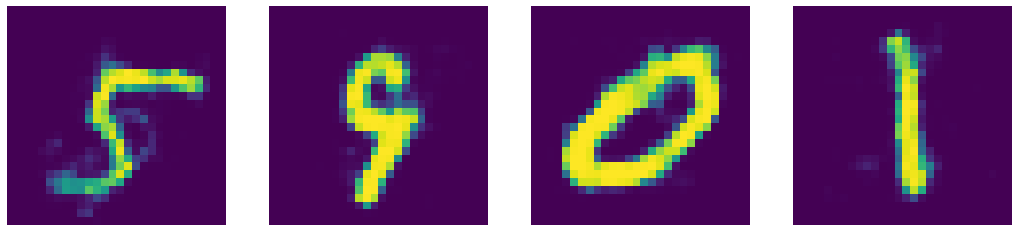

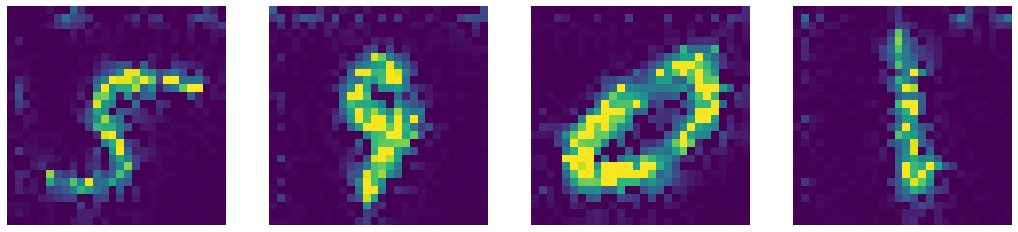

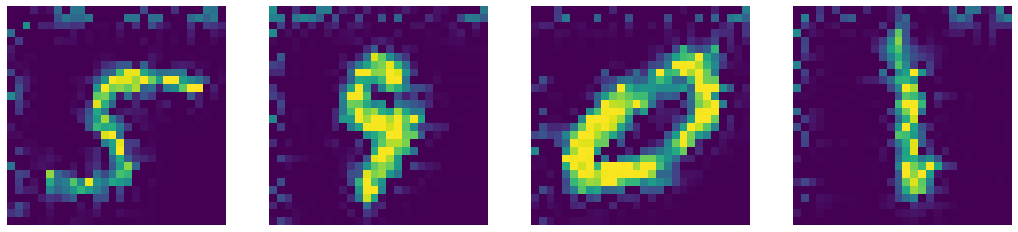

In [27]:
# Compare the results: [noise], [img + noise], [img], [AE, Telea, Navier-Stokes] inpainting

with torch.no_grad():
    display_images(noise[3:7], img_bad[3:7])
    display_images(img[3:7], output[3:7])
    display_images(TELEA, NS)

### Convolutional denoising AE

In [48]:
# Define model architecture and reconstruction loss

# n = 28 x 28 = 784
d = 512   #500  # for denoising AE (over-complete hidden layer)

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # n x 32 x 14 x 14
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # n x 64 x 7 x 7
            nn.Conv2d(64, 128, 3, padding=0),  # n x 128 x 5 x 5
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, 3, padding=0),  # n x 256 x 3 x 3
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 512, 3, padding=0),  # n x 512 x 1 x 1
            nn.Tanh()
        )
        
        self.decoder_lin = nn.Sequential(
            nn.Linear(d, 64*16*16),
            nn.BatchNorm1d(64*16*16),
            nn.ReLU(inplace=True),
        )
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7, stride=1),  # 22 x 22
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 1, 7, stride=1),  # 28 x 28
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder_conv(x)
        x = x.view(x.size(0), -1)
        
        x = self.decoder_lin(x)
        x = x.view(x.size(0), 64, 16, 16)
        x = self.decoder_conv(x)
        return x
    
    def get_features(self, x):
        x = self.encoder_conv(x)
        x = x.view(x.size(0), -1)
        return x
    
model = Autoencoder().to(device)
criterion = nn.MSELoss()

In [49]:
# Configure the optimiser

learning_rate = 1e-3

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

*Comment* or *un-comment out* a few lines of code to seamlessly switch between *standard AE* and *denoising one*.

Don't forget to **(1)** change the size of the hidden layer accordingly, **(2)** re-generate the model, and **(3)** re-pass the parameters to the optimiser.

epoch [1/20], loss:0.0511
epoch [2/20], loss:0.0392
epoch [3/20], loss:0.0344
epoch [4/20], loss:0.0279
epoch [5/20], loss:0.0288
epoch [6/20], loss:0.0272
epoch [7/20], loss:0.0249
epoch [8/20], loss:0.0257
epoch [9/20], loss:0.0235
epoch [10/20], loss:0.0261
epoch [11/20], loss:0.0247


<ipython-input-3-a84e5032819c>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(18, 6))
<ipython-input-3-a84e5032819c>:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(18, 6))


epoch [12/20], loss:0.0220
epoch [13/20], loss:0.0224
epoch [14/20], loss:0.0223
epoch [15/20], loss:0.0247
epoch [16/20], loss:0.0217
epoch [17/20], loss:0.0215
epoch [18/20], loss:0.0207
epoch [19/20], loss:0.0212
epoch [20/20], loss:0.0219


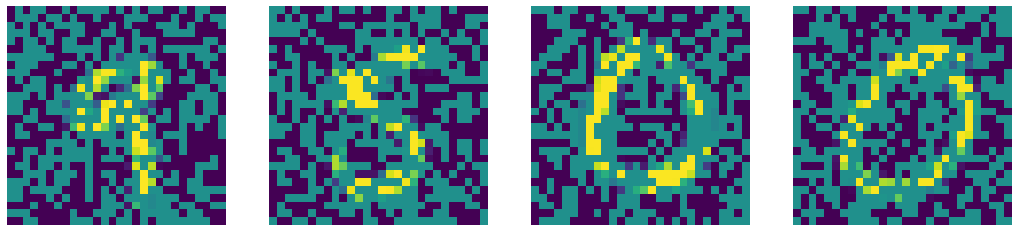

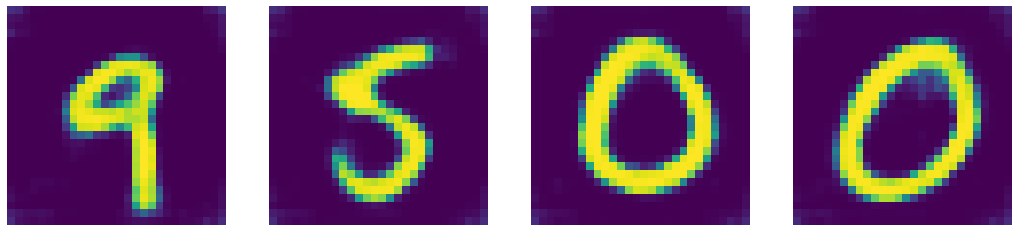

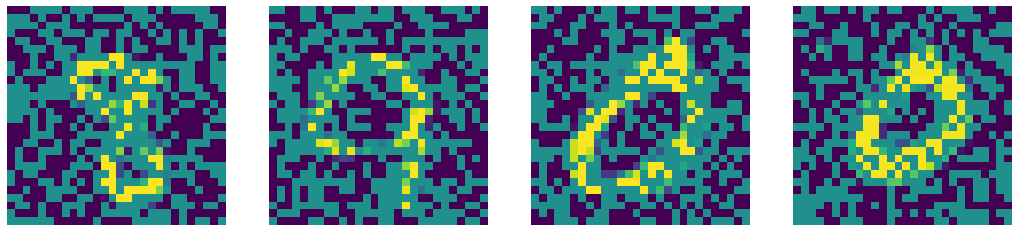

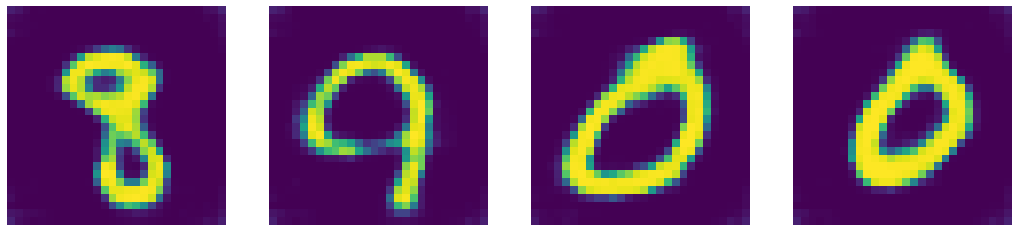

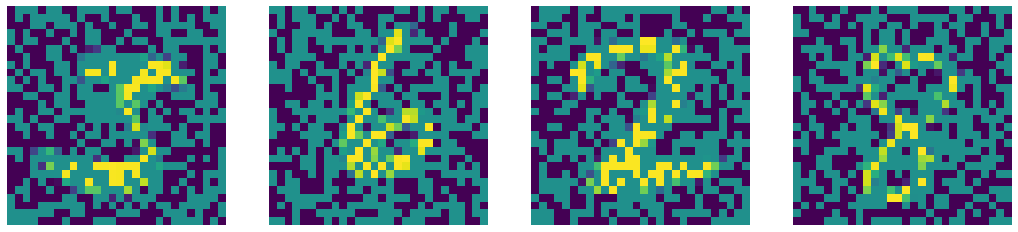

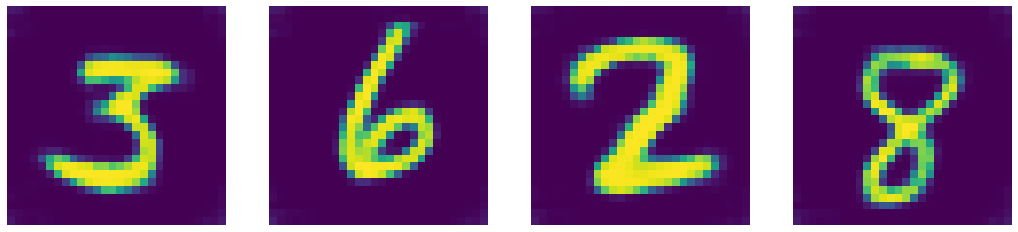

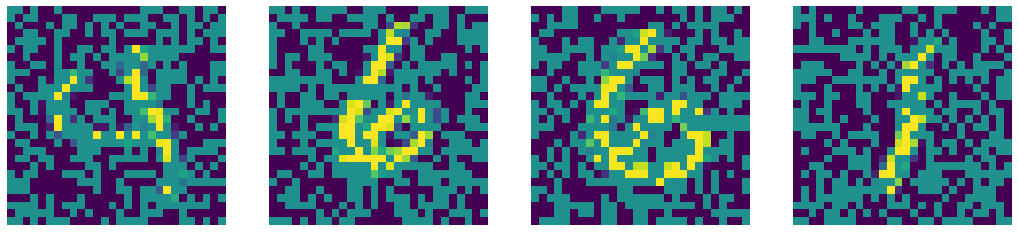

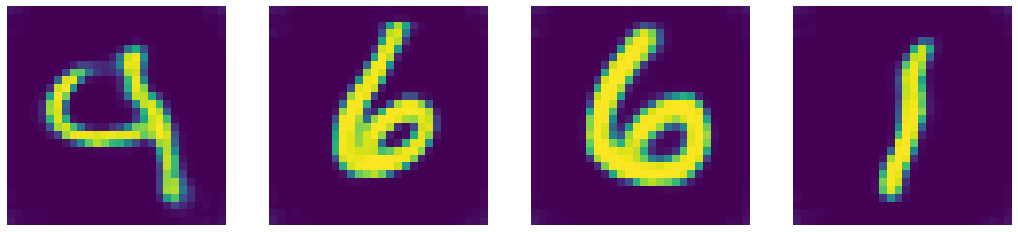

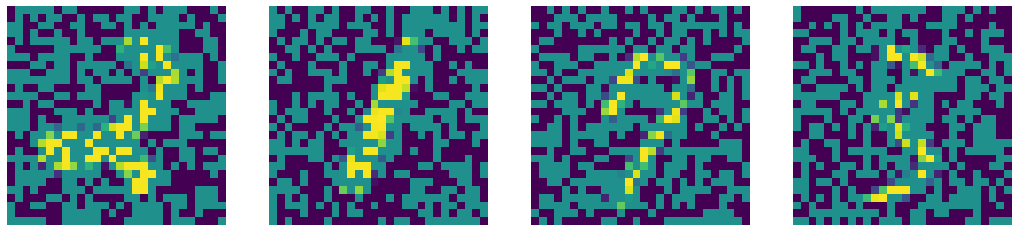

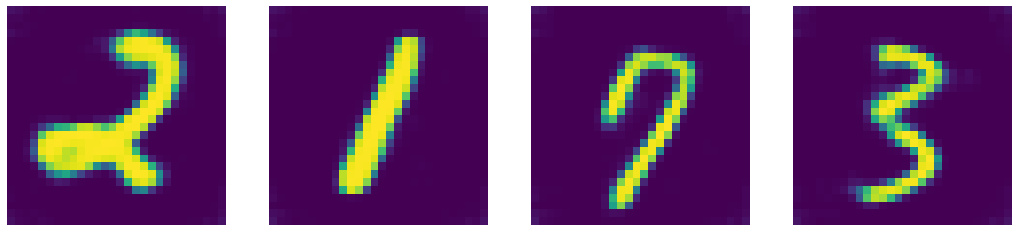

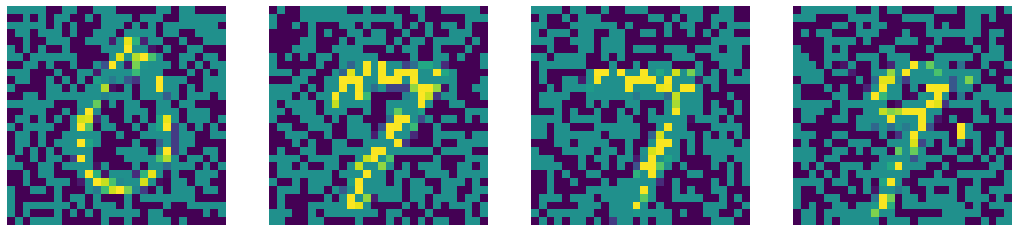

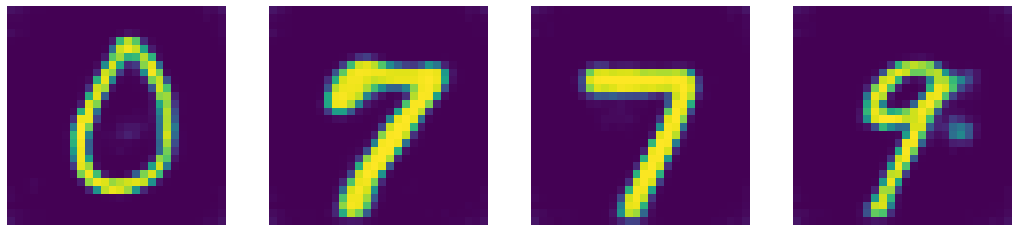

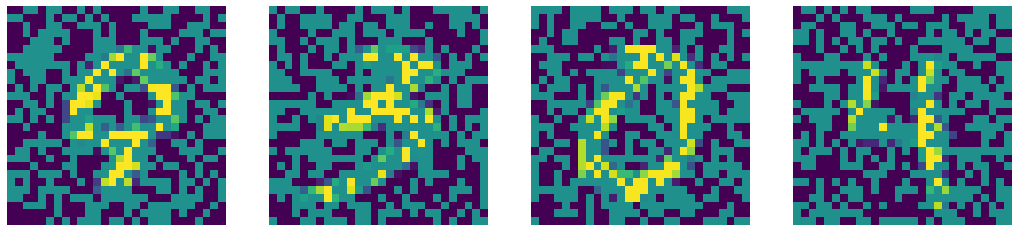

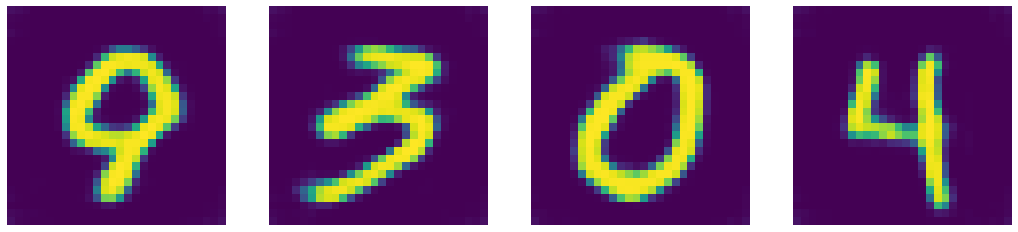

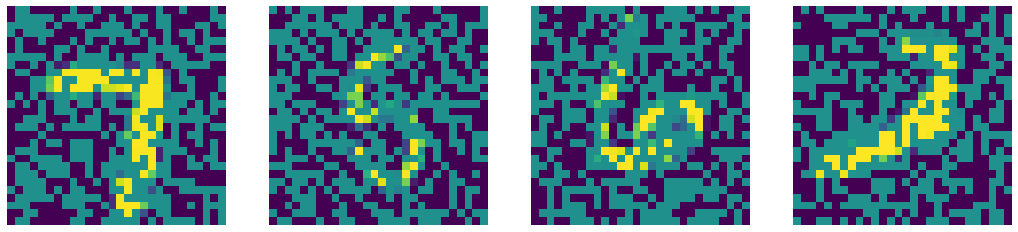

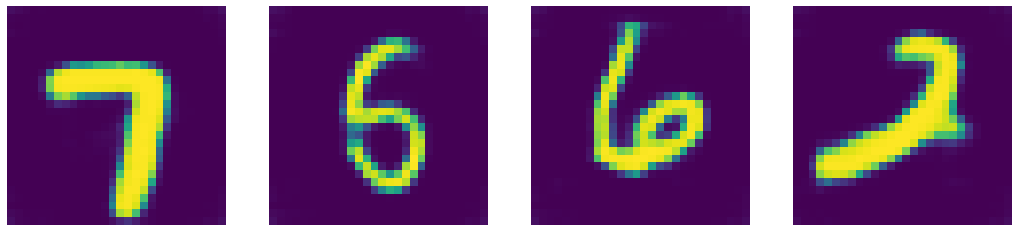

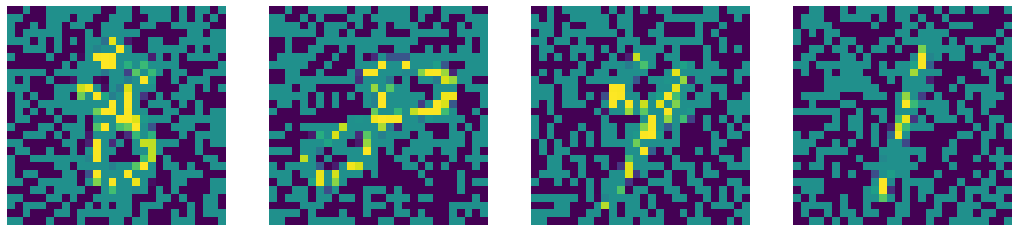

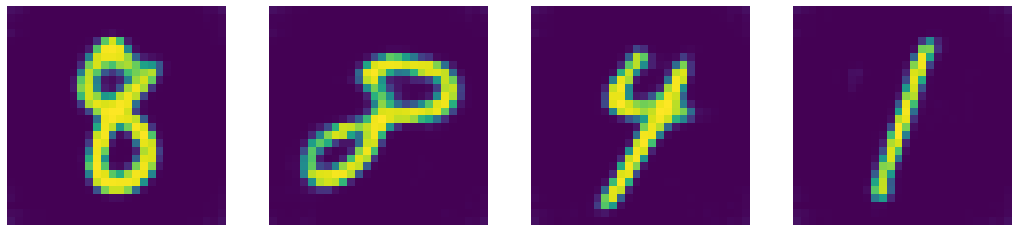

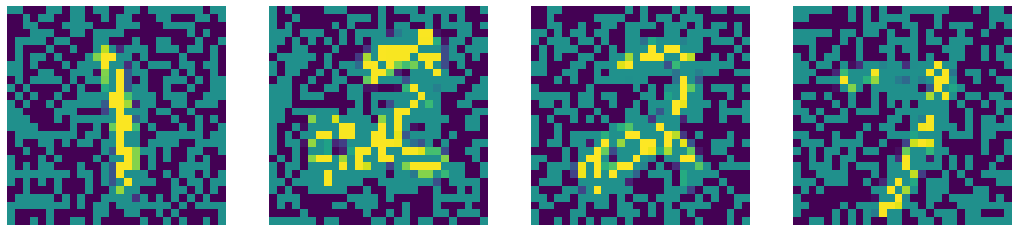

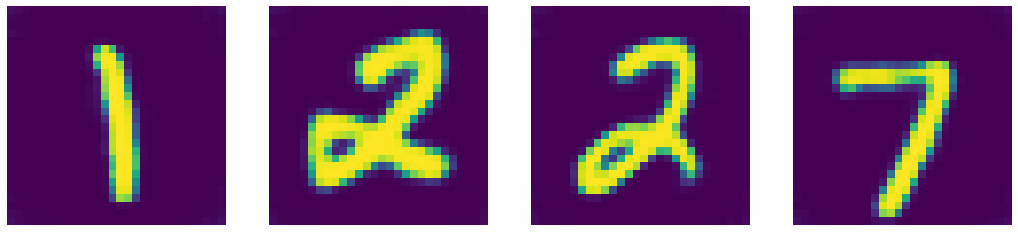

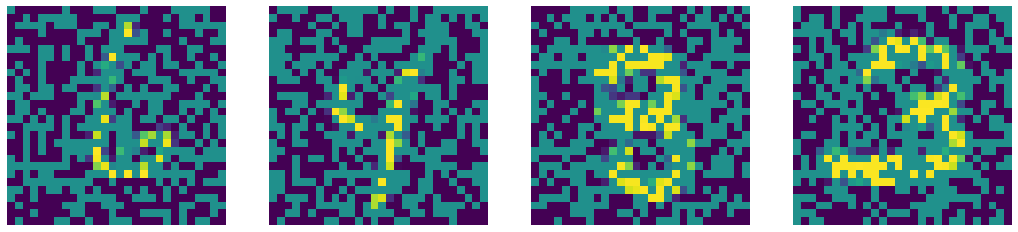

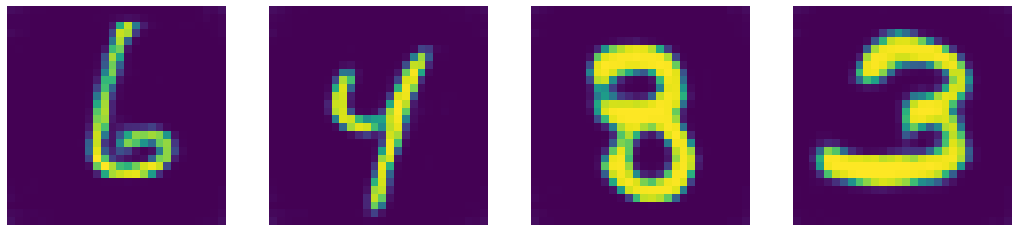

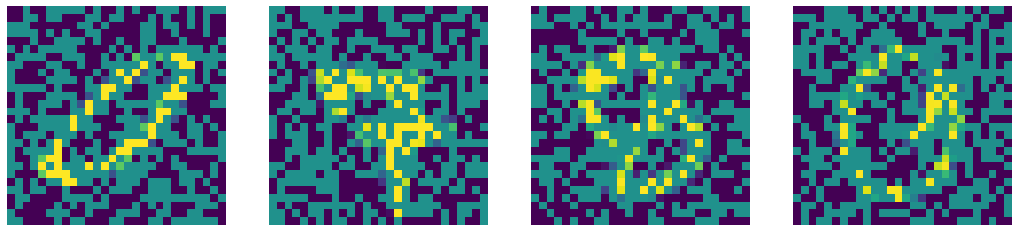

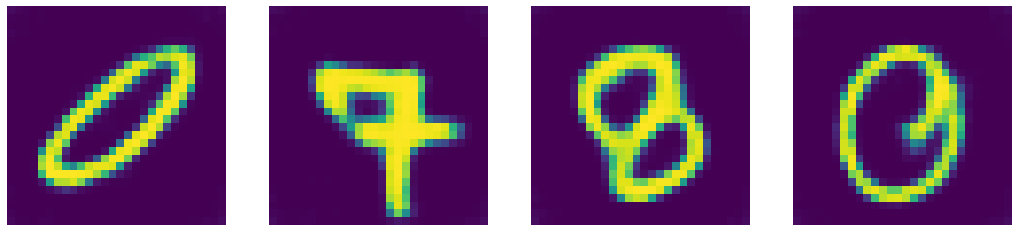

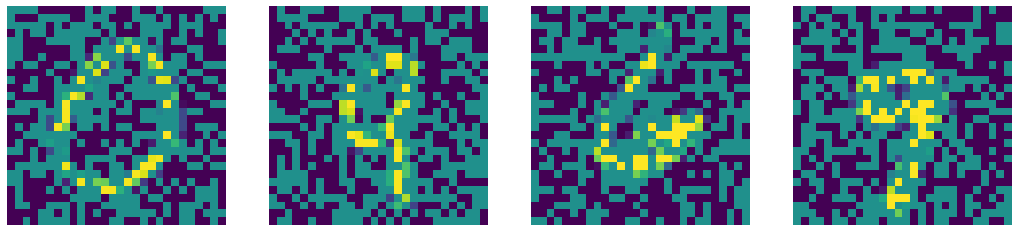

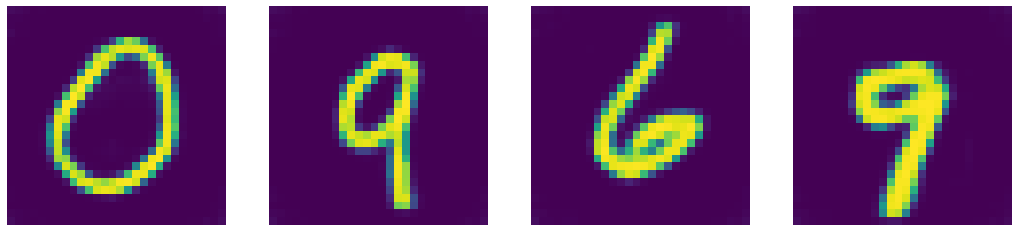

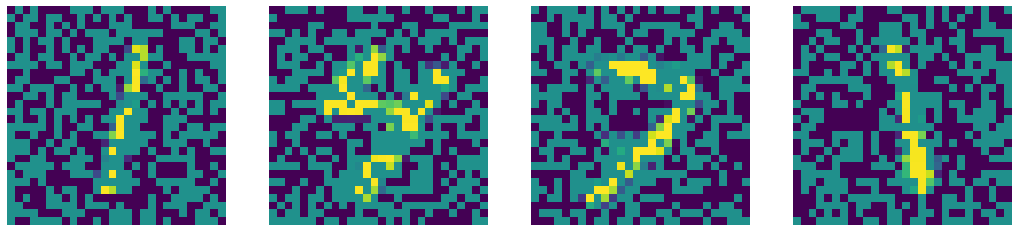

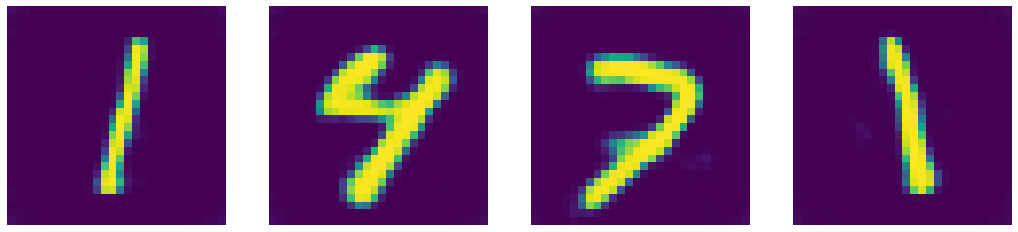

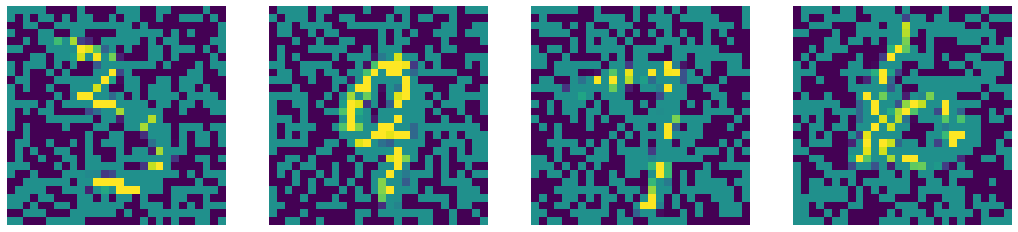

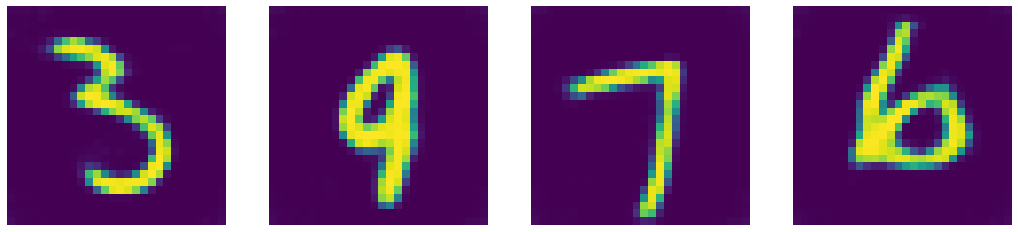

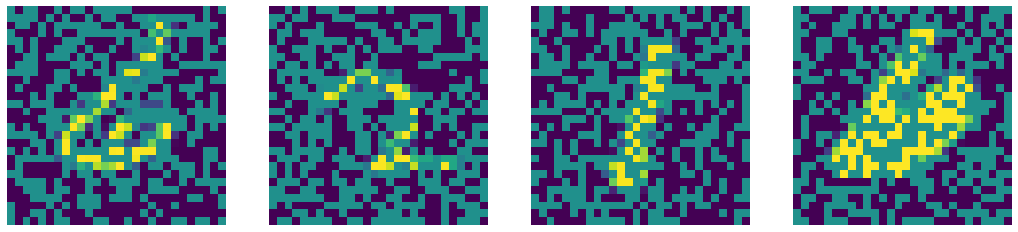

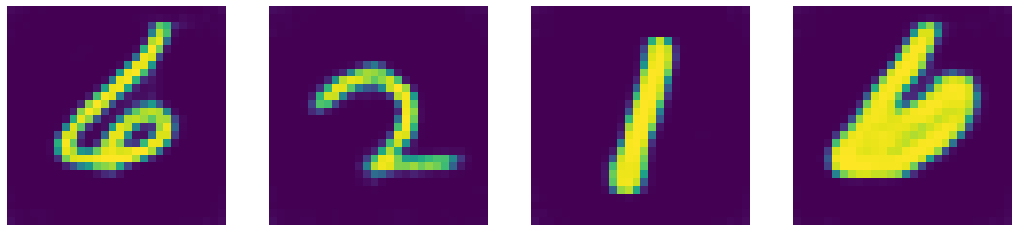

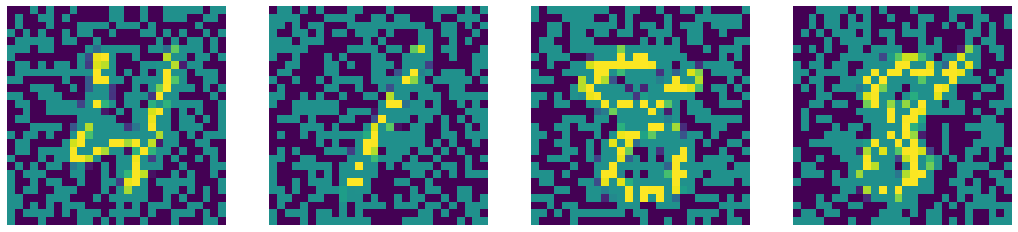

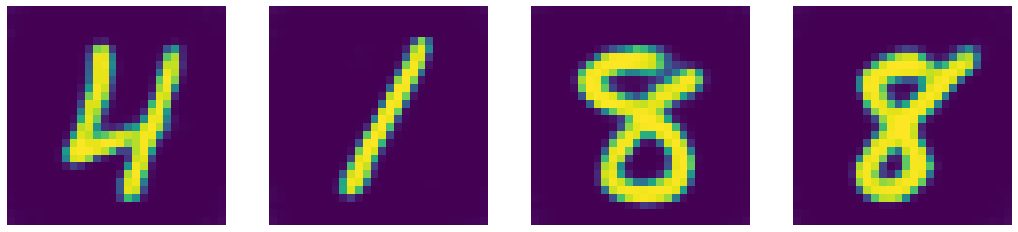

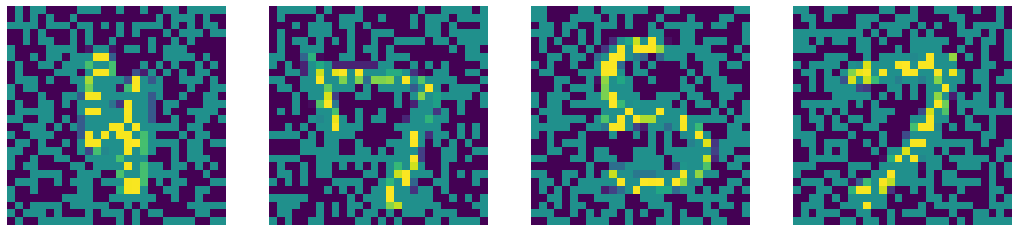

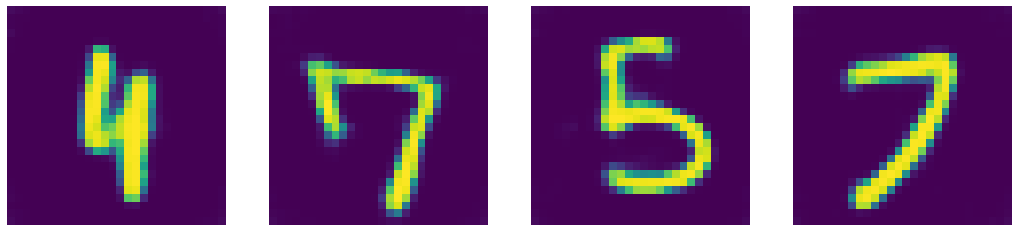

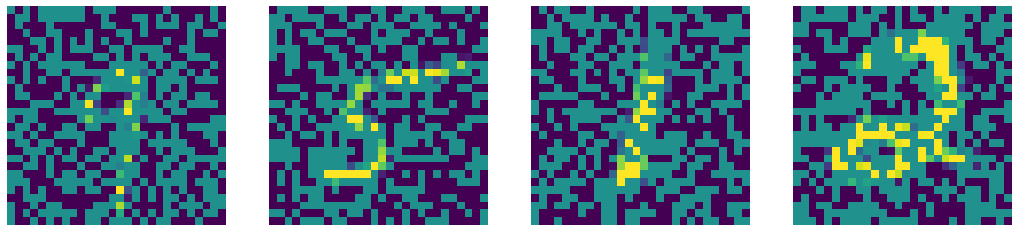

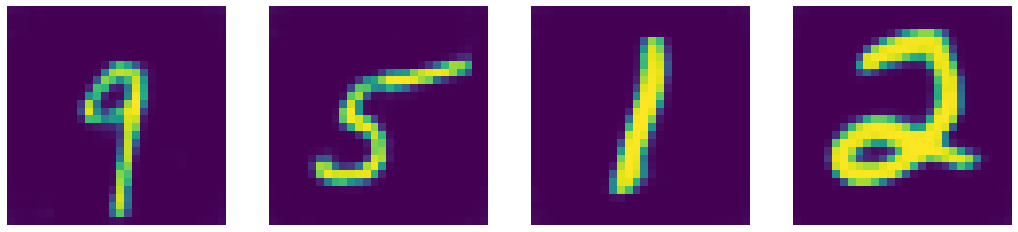

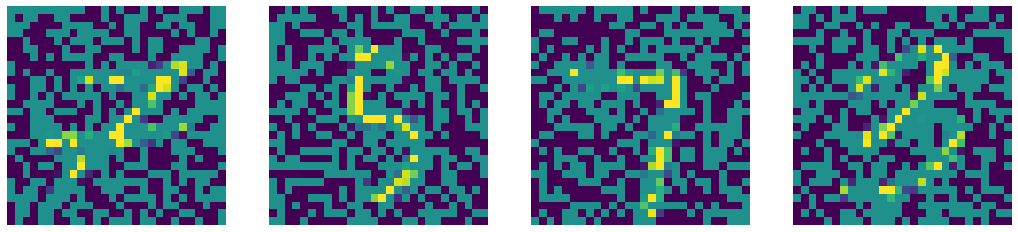

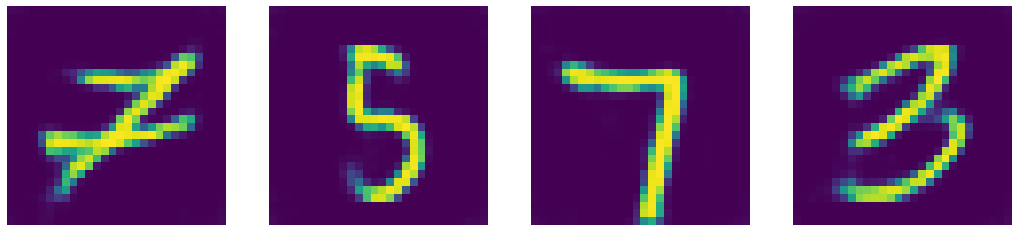

In [50]:
# Train standard or denoising autoencoder (AE)

num_epochs = 20
do = nn.Dropout()  # comment out for standard AE
for epoch in range(num_epochs):
    for batch in dataloader:
        img, _ = batch
        img = img.to(device)
        img = img.view(img.size(0), -1)
        noise = do(torch.ones(img.shape)).to(device)
        img_bad = (img * noise).to(device)  # comment out for standard AE
        img_bad = img_bad.view(img_bad.size(0), 1, 28, 28).to(device)
        img = img.view(img.size(0), 1, 28, 28).to(device)
        # ===================forward=====================
        output = model(img_bad)  # feed <img> (for std AE) or <img_bad> (for denoising AE)
        loss = criterion(output, img.data)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print(f'epoch [{epoch + 1}/{num_epochs}], loss:{loss.item():.4f}')
    display_images(img_bad, output)  # pass (None, output) for std AE, (img_bad, output) for denoising AE